<a href="https://colab.research.google.com/github/dcownden/PerennialProblemsOfLifeWithABrain/blob/book-review/sequences/P1C2_OptimizationAndEnvironment/P1C2_Sequence3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following is part of a test for an upcoming text book on computational neuroscience from an optimization and learning perspective. The book will start with evolution because ultimately, all aspects of the brain are shaped by evolution and, as we will see, evolution can also be seen as an optimization algorithm. We are sharing it now to get feedback on what works and what does not and the developments we should do.

____
# **1.2.3: Normative Thinking**

### **Objective:** Up until this point, we have predominantly viewed optimization as a tool for policy improvement, adapting behavior to better suit a particular environmental niche. This is a prescriptive view of optimization: "To improve the policy, implement these steps." However, optimization isn't solely prescriptive. It can also be used descriptively and predicatively. In this sequence we will learn about using optimization predictively. We call this 'Normative Thinking'.

If we make a series of reasonable assumptions—like behaviour being the result of learning processes which in turn are shaped by evolutionary forces, both of which adapt according to environmental demands—we can posit that the optimal behavior predicted by a model will align with the behaviour exhibited by real-world organisms. Crucially though, the validity of such predictions hinges on the extent to which the ***relevant*** intricacies of the evolutionary organism-environment dynamic are captured by the model.

In this sequence, we will:

* Investigate a new foraging scenario where policy performance can be mathematically-derived.

* Use deduction and reasoning to derive policy performance and determine the optimal policy.

* Observe how a simple propose-and-test algorithm, unaware of the structure of the problem, converges on the same optimal outcome as our analytical approach.

* Ponder the beauty and potential power of this connection between deductive reasoning about policies and 'empirical' observation. There are many different optimization methods and approaches, but all effective optimization approaches will lead to -mostly- the same place.

* Look at how optimization approaches fit within a broader framework of scientific understanding generally and what the means for neuroscientific understanding more generally.

# Setup

Run the following cell to setup and install the various dependencies and helper functions for this .

In [1]:
# @title Dependencies, Imports and Setup
# @markdown You don't need to worry about how this code works – but you do need to **run the cell**
!apt install libgraphviz-dev > /dev/null 2> /dev/null #colab
!pip install ipympl pygraphviz vibecheck datatops jupyterquiz > /dev/null 2> /dev/null #google.colab

import requests
from requests.exceptions import RequestException
import numpy as np
import itertools
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.animation import FuncAnimation
import seaborn as sns
import pandas as pd
import pygraphviz as pgv
import ipywidgets as widgets
import time
import logging
import random
import os
import copy
import torch
import warnings
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from io import BytesIO
from enum import Enum
from scipy.spatial.distance import cdist
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from tabulate import tabulate
from IPython.display import display, clear_output, Markdown, HTML, Image, IFrame
from jupyterquiz import display_quiz
from vibecheck import DatatopsContentReviewContainer
from pathlib import Path
from typing import List, Dict
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
# random seed settings and
# getting torch to use gpu if it's there


def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("This notebook isn't using and doesn't need a GPU. Good.")
  else:
    print("GPU is enabled in this notebook but not needed.")
    print("If possible, in the menu under `Runtime` -> ")
    print("`Change runtime type.`  select `CPU`")

  return device


SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()


def printmd(string):
  display(Markdown(string))


# the different utility .py files used in this notebook
filenames = ['gw_plotting.py', 'gw_board.py', 'gw_game.py',
             'gw_widgets.py', 'gw_NN_RL.py']
#filenames = []
# just run the code straight out of the response, no local copies needed!
for filename in filenames:
  url = f'https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/utils/{filename}'
  response = requests.get(url)
  # Check that we got a valid response
  if response.status_code == 200:
    code = response.content.decode()
    exec(code)
  else:
    print(f'Failed to download {url}')

# environment contingent imports
try:
  print('Running in colab')
  from google.colab import output
  output.enable_custom_widget_manager()
  from google.colab import data_table
  data_table.disable_dataframe_formatter()
  #from google.colab import output as colab_output
  #colab_output.enable_custom_widget_manager()
  IN_COLAB = True
except:
  IN_COLAB = False
  print('Not running in colab')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib widget
plt.style.use("https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/pplb.mplstyle")
plt.ioff() #need to use plt.show() or display explicitly
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)


def content_review(notebook_section: str):
  return DatatopsContentReviewContainer(
    "",  # No text prompt
    notebook_section,
    {
      "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
      "name": "neuro_book",
      "user_key": "xuk960xj",
    },
  ).render()
feedback_prefix = "P1C2_S3"




################################################################
# Graph Viz Helper Functions
################################################################
# @title Graphvis Helper Functions


def latex_to_png(latex_str, file_path, dpi, fontsize, figsize):
  """Convert a LaTeX string to a PNG image."""
  fig, ax = plt.subplots(figsize=figsize)
  ax.text(0.5, 0.5, f"${latex_str}$", size=fontsize, ha='center', va='center')
  ax.axis("off")
  #plt.tight_layout()
  plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
  plt.savefig(file_path, dpi=dpi, bbox_inches='tight', transparent=True, pad_inches=0.02)
  plt.close()

def add_latex_edge_labels(graph, edge_labels, dpi=150, fontsize=16, figsize=(0.4,0.2)):
  """Add LaTeX-rendered images as edge labels using the dummy node approach."""
  for edge in edge_labels:
    src, dest, latex_str = edge
    if graph.has_edge(src, dest):
      img_path = f"{src}_to_{dest}_{latex_str}.png"
      latex_to_png(latex_str, img_path, dpi=dpi, fontsize=fontsize, figsize=figsize)
      dummy_node_name = f"dummy_{src}_{dest}_{latex_str}"
      graph.add_node(dummy_node_name, shape="box", image=img_path, label="")
      graph.delete_edge(src, dest)
      graph.add_edge(src, dummy_node_name, dir="none", weight=10)
      graph.add_edge(dummy_node_name, dest, dir="forward", weight=10)
  return graph

def set_regular_node_sizes(graph, width=1.0, height=1.0):
  """Set the size of regular nodes (excluding dummy label nodes)."""
  for node in graph.nodes():
    if not node.startswith("dummy"):
      node.attr['width'] = width
      node.attr['height'] = height
  return graph

def create_and_render_graph(nodes_list, edges_list, latex_edge_labels,
                            node_colors = {},
                            node_labels = {},
                            output_path="graphviz_output.png", dpi=300,
                            figsize=(0.6, 0.3), fontsize=16):
  """
  Create a graph with given nodes, edges, and LaTeX edge labels, then render and save it.

  Parameters:
    nodes_list (list): List of nodes in the graph.
    edges_list (list): List of edges in the graph.
    latex_edge_labels (list): List of tuples containing edge and its LaTeX label.
    output_path (str): Path to save the rendered graph.
    dpi (int): DPI for rendering the graph.
    figsize (tuple): Figure size for the LaTeX labels.

  Returns:
    str: Path to the saved graph image.
  """

  # Graph Creation and Configuration
  G = pgv.AGraph(directed=True, strict=False, rankdir='LR', ranksep=0.5, nodesep=0.5)
  for node in nodes_list:
    color = node_colors.get(node, "black")
    label = node_labels.get(node, node)
    G.add_node(node, color=color, label=label)
  for edge in edges_list:
    G.add_edge(edge[0], edge[1])

  # Set size for regular nodes and add LaTeX-rendered image labels to the edges
  G = set_regular_node_sizes(G, width=1, height=1)
  G = add_latex_edge_labels(G, latex_edge_labels, dpi=dpi, figsize=figsize, fontsize=fontsize)

  # Additional graph attributes
  G.graph_attr['size'] = "8,8"
  G.graph_attr['dpi'] = str(dpi)

  # Render and save the graph
  G.layout(prog='dot')
  G.draw(output_path)

  return output_path




#######################################################################
# make PatchyForageBoard class locally before integrating in shared utils
#######################################################################
# @title PatchyForageBoard class




class PatchyForageBoard():
  """
  A collection of methods and parameters of a patchy foraging game board that
  define the logic of the game, and allows for multiple critters on the same
  board

  game state is represented by primarily by food locations, forager locations,
  predator locations, scores, and rounds left
  food patch locations are stored on a batch x n_rows x n_cols numpy array,
  forager and predator(when we have them) locations are stored as dictionaries
  with integer keys corresponding to a forager/predatore 1, 2, 3 etc, and then
  np.argwhere style tuples of arrays of (batch_array, row_array, col_array)
  giving the locations

  scores is a batchsize x num_critters numpy array giving the scores for each
  critter on each board in the batch (note off by one indexing)

  rounds_left is how many rounds are left in the game.

  Note:
    In 2d np.array first dim is row (vertical), second dim is col (horizontal),
    i.e. top left corner is (0,0), so take care when visualizing/plotting
    as np.array visualization inline with typical tensor notation but at odds
    with conventional plotting where (0,0) is bottom left, first dim, x, is
    horizontal, second dim, y, is vertical
  """

  ARRAY_PAD_VALUE = -200

  def __init__(self, batch_size=1,
               n_rows=10, n_cols=5,
               num_foragers=1,
               death_rate=0.04,
               food_patch_prob = 0.4,
               food_regen_prob=0.0,
               forage_success_prob = 0.7,
               food_extinct_prob = 0.1, rng=None):
    """Set the parameters of the game."""
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.batch_size = batch_size
    self.num_foragers = num_foragers
    self.death_rate = death_rate
    self.food_patch_prob = food_patch_prob
    self.forage_success_prob = forage_success_prob
    self.food_extinct_prob = food_extinct_prob
    self.food_regen_prob = food_regen_prob
    if rng is None:
      self.rng = np.random.default_rng(seed=SEED)
    else:
      self.rng = rng


  def init_loc(self, n_rows, n_cols, num, rng=None):
    """
    Samples random 2d grid locations without replacement

    Args:
      n_rows: int, number of rows in the grid
      n_cols: int, number of columns in the grid
      num:    int, number of samples to generate. Should throw an error if num > n_rows x n_cols
      rng:    instance of numpy.random's default rng. Used for reproducibility.

    Returns:
      int_loc: ndarray(int) of shape (num,), flat indices for a 2D grid flattened into 1D
      rc_index: tuple(ndarray(int), ndarray(int)), a pair of arrays with the first giving
        the row indices and the second giving the col indices. Useful for indexing into
        an n_rows by n_cols numpy array.
      rc_plotting: ndarray(int) of shape (num, 2), 2D coordinates suitable for matplotlib plotting
    """

    # Set up default random generator, use the boards default if none explicitly given
    if rng is None:
      rng = self.rng
    # Choose 'num' unique random indices from a flat 1D array of size n_rows*n_cols
    int_loc = rng.choice(n_rows * n_cols, num, replace=False)
    # Convert the flat indices to 2D indices based on the original shape (n_rows, n_cols)
    rc_index = np.unravel_index(int_loc, (n_rows, n_cols))
    # Transpose indices to get num x 2 array for easy plotting with matplotlib
    rc_plotting = np.array(rc_index).T
    # Return 1D flat indices, 2D indices for numpy array indexing and 2D indices for plotting
    return int_loc, rc_index, rc_plotting


  def get_init_board_state(self):
    """
    Set up starting board using game parameters

    Returns:
      state (dict):
      The state dictionary contains:
        - 'pieces': Current food patch locations as a batch x row x col numpy array.
        - 'scores': The current scores of the critters.
        - 'rounds_alive': The number of rounds each critter has been alive.
        - 'is_over': Flags indicating if the game is over for each board in the batch.
        - 'forager_locs': Dictionary of current locations of the foragers on the board.
        - 'misses_new_patch': List of counts for missed attempts at new patches for each critter.
        - 'misses_known_patch': List of counts for missed attempts at known patches for each critter.
        - 'at_new_patch': List of booleans indicating if each critter is at a new
    """
    # note that is_over applies at the batch level not the batch x forager level
    self.is_over = np.zeros(self.batch_size, dtype=bool)
    self.rounds_alive = np.zeros((self.batch_size, self.num_foragers), dtype=int)
    self.scores = np.zeros((self.batch_size, self.num_foragers), dtype=int)
    # create an empty board array for food locs
    self.pieces = np.zeros((self.batch_size, self.n_rows, self.n_cols),
                           dtype=int)
    # Place critters in top left corner of the board
    self.forager_locs = {}
    for c in (np.arange(self.num_foragers)+1):
      self.forager_locs[c] = (np.arange(self.batch_size, dtype=int),
                              np.zeros(self.batch_size, dtype=int),
                              np.zeros(self.batch_size, dtype=int))
    # Initial food patches on the board randomly
    # each grid has an independent prob of being a pathc (to make the math
    # easier later) so total number of patches on a board is binomially
    # distributed
    num_foods = self.rng.binomial(n=self.n_rows * self.n_cols,
                                  p=self.food_patch_prob,
                                  size=self.batch_size)
    for ii in np.arange(self.batch_size):
      int_loc, rc_idx, rc_plot = self.init_loc(self.n_rows, self.n_cols,
                                               num_foods[ii])
      # food patch start locations (do each patch separate in case we
      # want to have different kinds of patches)
      for f_ in np.arange(num_foods[ii]):
        self.pieces[(ii, rc_idx[0][f_],
                         rc_idx[1][f_])] = - 1
    # keep track of which foragers have missed how many times
    # at what kind of patch
    self.misses_new_patch = np.zeros((self.batch_size, self.num_foragers), dtype=int)
    self.misses_known_patch = np.zeros((self.batch_size, self.num_foragers), dtype=int)
    self.at_new_patch = np.ones((self.batch_size, self.num_foragers), dtype=bool)
    state = {'pieces': self.pieces.copy(),
             'scores': self.scores.copy(),
             'rounds_alive': self.rounds_alive.copy(),
             'is_over': self.is_over.copy(),
             'forager_locs': copy.deepcopy(self.forager_locs),
             'misses_new_patch': self.misses_new_patch.copy(),
             'misses_known_patch': self.misses_known_patch.copy(),
             'at_new_patch': self.at_new_patch.copy()}
    return state


  def set_state(self, board):
    """
    Sets the state given a board dictionary.

    Args:
      board (dict):
      The board dictionary contains:
        - 'pieces': Current food patch locations as a batch x row x col numpy array.
        - 'scores': The current scores of the critters.
        - 'rounds_alive': The number of rounds each critter has been alive.
        - 'is_over': Flags indicating if the game is over for each board in the batch.
        - 'forager_locs': Dictionary of current locations of the foragers on the board.
        - 'misses_new_patch': List of counts for missed attempts at new patches for each critter.
        - 'misses_known_patch': List of counts for missed attempts at known patches for each critter.
        - 'at_new_patch': List of booleans indicating if each critter is at a new patch.
    """
    self.pieces = board['pieces'].copy()
    self.forager_locs = copy.deepcopy(board['forager_locs'])
    self.rounds_alive = board['rounds_alive'].copy()
    self.scores = board['scores'].copy()
    self.is_over = board['is_over'].copy()
    self.misses_new_patch = board['misses_new_patch'].copy()
    self.misses_known_patch = board['misses_known_patch'].copy()
    self.at_new_patch = board['at_new_patch'].copy()


  def get_state(self):
    """
    Returns the current board state.

    Returns:
      state (dict):
      The state dictionary contains:
        - 'pieces': Current food patch locations as a batch x row x col numpy array.
        - 'scores': The current scores of the critters.
        - 'rounds_alive': The number of rounds each critter has been alive.
        - 'is_over': Flags indicating if the game is over for each board in the batch.
        - 'forager_locs': Dictionary of current locations of the foragers on the board.
        - 'misses_new_patch': List of counts for missed attempts at new patches for each critter.
        - 'misses_known_patch': List of counts for missed attempts at known patches for each critter.
        - 'at_new_patch': List of booleans indicating if each critter is at a new patch.
    """
    state = {'pieces': self.pieces.copy(),
             'scores': self.scores.copy(),
             'rounds_alive': self.rounds_alive.copy(),
             'is_over': self.is_over.copy(),
             'forager_locs': copy.deepcopy(self.forager_locs),
             'misses_new_patch': self.misses_new_patch.copy(),
             'misses_known_patch': self.misses_known_patch.copy(),
             'at_new_patch': self.at_new_patch.copy()}
    return state


  ################# CORE GAME STATE UPDATE LOGIC ##############################
  ################# execute_moves is main, uses these helper functions ########


  def execute_moves(self, moves, which_critter):
    """
    Execute the moves on the board. A move to the current location implies
    foraging. If foraging, check if foraging is successful, update scores,
    and check if the food goes extinct. If moving to a new location, simply
    update the critter's location.

    Args:
      moves (tuple): A tuple of three arrays:
        - batch_array: Specifies which board in the batch the move corresponds to.
        - row_array: Specifies the target row for each move.
        - col_array: Specifies the target column for each move.
        Each array in the tuple has the same length. A move is represented by
        the combination of a batch index, row index, and column index at the
        same position in their respective arrays.
      which_critter (int): Index to identify the critter. Starts from 1.

    Returns: Nothing, just updates state related attributes of the board object

    """
    #expand moves tuple
    batch_moves, row_moves, col_moves = moves

    # Get current locations of the critter
    current_locs = self.forager_locs[which_critter]

    # Iterate over each board in the batch
    for ii in np.arange(self.batch_size):
      # If the game is over for this board, skip
      if self.is_over[ii]:
        continue

      # increment rounds alive if not over
      self.rounds_alive[ii, which_critter - 1] += 1

      # Get new location directly from the moves
      new_row = int(row_moves[ii])
      new_col = int(col_moves[ii])

      # Check if the critter has moved to a new patch
      if (new_row, new_col) != (current_locs[1][ii], current_locs[2][ii]):
        # Moved to a new patch
        self.misses_new_patch[ii, which_critter - 1] = 0
        self.misses_known_patch[ii, which_critter - 1] = 0
        self.at_new_patch[ii, which_critter - 1] = True

      # If the critter's position has not changed, it's trying to forage
      elif (new_row, new_col) == (current_locs[1][ii], current_locs[2][ii]):
        # Check if there's food at the location
        if self.pieces[ii, new_row, new_col] < 0:
          # Check if foraging is successful
          if self.rng.random() < self.forage_success_prob:
            # Successful foraging, increase critter's score
            self.scores[ii, which_critter - 1] += 1
            # misses are zeroed and no longer at new patch
            self.misses_new_patch[ii, which_critter - 1] = 0
            self.misses_known_patch[ii, which_critter - 1] = 0
            self.at_new_patch[ii, which_critter - 1] = False
            # Check if food goes extinct (only on success)
            if self.rng.random() < self.food_extinct_prob:
              self.pieces[ii, new_row, new_col] = 0  # Set it to empty
          else:
            #unsuccessful foraging at patch with food
            if self.at_new_patch[ii, which_critter - 1]:
              # at a new patch
              self.misses_new_patch[ii, which_critter - 1] += 1
            else:
              # at a known patch
              self.misses_known_patch[ii, which_critter - 1] += 1
        else:
          #unsuccessful foraging at patch without food
            if self.at_new_patch[ii, which_critter - 1]:
              # at a new patch
              self.misses_new_patch[ii, which_critter - 1] += 1
            else:
              # at a known patch
              self.misses_known_patch[ii, which_critter - 1] += 1

      # Always check if session is over
      if self.rng.random() < self.death_rate:
        self.is_over[ii] = True

    # assume moves are legal and update locs for whole batch at once
    self.forager_locs[which_critter] = (batch_moves, row_moves, col_moves)

  ###### Getting Legal Moves and Perceptions #########################
  ####################################################################
  def get_neighbor_grc_indices(self, which_critter, radius, pad=False):
    """
    Returns all grid positions within a certain cityblock distance radius from
    the place corresponding to which_critter.

    Args:
        which_critter (int): The idex of the focal critter_food.
        radius (int): The cityblock distance.
        pad (bool): whether or not to pad the array, if padded all row, col
          indexes are valid for the padded array, useful for getting percept
          if not all indexes are correct for the original array, useful for
          figuring out legal moves.

    Returns:
        an array of indices, each row is a g, r, c index for the neighborhoods
        around the critters, can use the g value to know which board you are in.
        if pad=True also returns the padded array (the indices in that case) are
        for the padded array, so won't work on self.pieces, whereas if pad is
        False the indices will be for the offsets in reference to the original
        self.pieces, but note that some of these will be invalid, and will
        need to be filtered out (as we do in get_legal)
    """
    batch_size, n_rows, n_cols = self.pieces.shape
    batch, rows, cols = self.forager_locs[which_critter]
    # Create meshgrid for offsets
    if pad is True:
      padded_arr = np.pad(self.pieces, ((0, 0), (radius, radius),
        (radius, radius)), constant_values=self.ARRAY_PAD_VALUE)
      rows = rows + radius
      cols = cols + radius

    row_offsets, col_offsets = np.meshgrid(
        np.arange(-radius, radius + 1),
        np.arange(-radius, radius + 1),
        indexing='ij')

    # Filter for valid cityblock distances
    mask = np.abs(row_offsets) + np.abs(col_offsets) <= radius
    valid_row_offsets = row_offsets[mask]
    valid_col_offsets = col_offsets[mask]
    # Extend rows and cols dimensions for broadcasting
    extended_rows = rows[:, np.newaxis]
    extended_cols = cols[:, np.newaxis]
    # Compute all neighbors for each position in the batch
    neighbors_rows = extended_rows + valid_row_offsets
    neighbors_cols = extended_cols + valid_col_offsets

    indices = np.column_stack((np.repeat(np.arange(batch_size),
                                         neighbors_rows.shape[1]),
                               neighbors_rows.ravel(),
                               neighbors_cols.ravel()))
    if pad is False:
      return indices
    elif pad is True:
      return indices, padded_arr


  def get_legal_moves(self, which_critter, radius=1):
    """
    Identifies all legal moves for the critter.

    Returns:
      A numpy int array of size batch x 3(g,x,y) x 4(possible moves)

    Note:
      moves[0,1,3] is the x coordinate of the move corresponding to the
      fourth offset on the first board.
      moves[1,:,1] will give the g,x,y triple corresponding to the
      move on the second board and the second offset, actions are integers
    """

    critter_locs = np.array(self.forager_locs[which_critter])
    # turn those row, col offsets into a set of legal offsets
    legal_offsets = self.get_neighbor_grc_indices(which_critter, radius)
    legal_offsets = {tuple(m_) for m_ in legal_offsets}

    legal_destinations = np.where(np.ones(self.pieces.shape, dtype=bool))
    legal_destinations = {tuple(coords) for coords in zip(*legal_destinations)}
    # Add the current locations of the critters to legal_destinations
    current_locations = {tuple(loc) for loc in critter_locs.T}
    legal_destinations = legal_destinations.union(current_locations)

    # legal moves are both legal offsets and legal destinations
    legal_moves = legal_offsets.intersection(legal_destinations)
    return legal_moves


  def get_perceptions(self, critter_food, radius):
    idx, pad_pieces = self.get_neighbor_grc_indices(critter_food,
                                                    radius, pad=True)
    #percept_mask = np.zeros(pad_pieces.shape, dtype=bool)
    #percept_mask[idx[:,0], idx[:,1]], idx[:,2]] = True
    percept = pad_pieces[idx[:,0], idx[:,1], idx[:,2]]
    return(percept.reshape(self.batch_size, -1))




#######################################################################
# make PatchyForageGame class locally before integrating in shared utils
#######################################################################
# @title PatchyForageGame class




class PatchyForagingGame():
  """
  A collection of methods and parameters of a patchy foraging game that allow
  for interaction with and display of PatchyForageBoard objects.
  """


  def __init__(self, batch_size=1, n_rows=10, n_cols=5, num_foragers=1,
               death_rate=0.04, food_patch_prob=0.4, food_regen_prob=0.0,
               forage_success_prob=0.7, food_extinct_prob=0.1, rng=None):
    """
    Initializes an instance of the PatchyForagingGame with the specified parameters.
    Args:
    ... [same as in PatchyForageBoard]
    """
    self.batch_size = batch_size
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.num_foragers = num_foragers
    self.death_rate = death_rate
    self.food_patch_prob = food_patch_prob
    self.forage_success_prob = forage_success_prob
    self.food_extinct_prob = food_extinct_prob
    self.food_regen_prob = food_regen_prob
    if rng is None:
      self.rng = np.random.default_rng(seed=SEED)
    else:
      self.rng = rng

  def get_init_board(self):
    """
    Generates a starting board given the parameters of the game.
    Returns the initial state of the game.
    """
    board = PatchyForageBoard(batch_size=self.batch_size, n_rows=self.n_rows,
                              n_cols=self.n_cols, num_foragers=self.num_foragers,
                              death_rate=self.death_rate, food_patch_prob=self.food_patch_prob,
                              forage_success_prob=self.forage_success_prob,
                              food_extinct_prob=self.food_extinct_prob,
                              food_regen_prob=self.food_regen_prob, rng=self.rng)
    return board.get_init_board_state()


  def get_board_shape(self):
    """Shape of a single board, doesn't give batch size"""
    return (self.n_rows, self.n_cols)

  def get_action_size(self):
    """
    Returns the number of all possible actions, even though only a subset
    of these will ever be valid on a given turn.
    Actions correspond to integer indexes of board locations,
    moves to (batch,) row and column coordinate indexes of board locations.
    """
    return self.n_rows * self.n_cols

  def get_batch_size(self):
    return self.batch_size

  def get_scores(self, board):
    return board['scores'].copy()

  def get_rounds_alive(self, board):
    return board['rounds_alive'].copy()

  def get_square_symbol(self, piece, has_forager):
    """Returns the symbol representation of a board square."""
    if has_forager and piece < 0: return 'C'  # Critter on food patch
    if has_forager: return 'P'  # Forager on an empty square
    if piece == 0: return '.'  # Empty square
    if piece < 0: return 'F'  # Food patch
    return '?'  # Unknown piece type, for debugging

  def display(self, board, g=0):
    """Displays the g-th game in the batch of boards."""
    print("   ", end="")
    for c_ in range(self.n_cols):
      print(c_, end=" ")
    print("")
    print("-----------------------")
    for r_ in range(self.n_rows):
      print(r_, "|", end="")  # Print the row number
      for c_ in range(self.n_cols):
        piece = board['pieces'][g, r_, c_]  # Get the piece to print
        # Check if the square is occupied by a forager
        has_forager = False
        for forager_num, locs in board['forager_locs'].items():
          if g in locs[0] and r_ in locs[1] and c_ in locs[2]:
            has_forager = True
            break

        print(self.get_square_symbol(piece, has_forager), end=" ")
      print("|")
    print("-----------------------")
    print("Rounds Alive: " + str(board['rounds_alive'][g]))
    print("Score: " + str(board['scores'][g]))

  def get_critter_rc(self, board, g, which_critter):
    critter_locs = board['forager_locs'][which_critter]
    return critter_locs[1][g], critter_locs[2][g]

  def plot_board(self, board, g=0,
                 fig=None, ax=None, critter_specs=None, food=None, fov=None,
                 legend_type='included',
                 has_fov=False, #fog_of_war field_of_view
                 fov_opaque=False, #let human see through fog of war or not
                 show_food=True,
                 radius=2, figsize=(6,5), title=None,
                 name='Critter',
                 focal_critter_index = 0):
    """Uses plotting functions to make picture of the current board state"""
    batch_size, n_rows, n_cols = board['pieces'].shape
    plt.ioff()
    if fig is None and ax is None:
      fig, ax = make_grid(n_rows, n_cols, figsize=figsize, title=title)

    # get food locs and plot them
    rc_food_index = np.array(np.where(board['pieces'][g] <= -1))
    rc_food_plotting = np.array(rc_food_index).T
    if food is None:
      food = plot_food(fig, ax, rc_food_plotting, size=550, show_food=show_food)
    else:
      food = plot_food(fig, ax, rc_food_plotting, food, show_food=show_food)

    # generate critter plotting specs if we don't already have them
    if critter_specs is None:
      critter_specs = []
      markers = ['h', 'd']  # hexagon and diamond
      colors = sns.color_palette("colorblind")
      for i in range(self.num_foragers):
        critter_name = name if self.num_foragers == 1 else f'{name} {i+1}'
        spec = {'marker': markers[i % len(markers)],
                'color': colors[i // len(markers) % len(colors)],
                'name': critter_name,
                'int_id': i+1}
        critter_specs.append(spec)
    # get critter locs and plot them
    assert len(critter_specs) == self.num_foragers, "More/fewer specs than critters"
    for spec in critter_specs:
      rc_loc = np.array(self.get_critter_rc(board, g, spec['int_id'])).T
      spec.update({'rc_loc': rc_loc})
    critter_specs = plot_critters(fig, ax, critter_specs)

    #plot field of view if doing that
    if has_fov:
      # plot field of view around the 'active player'
      if fov is None:
        fov = plot_fov(fig, ax, critter_specs[focal_critter_index]['rc_loc'][0],
                       n_rows, n_cols, radius, has_fov, opaque=fov_opaque)
      else:
        fov = plot_fov(fig, ax, critter_specs[focal_critter_index]['rc_loc'][0],
                       n_rows, n_cols, radius, has_fov, opaque=fov_opaque, fov=fov)
    # make legend and draw and return figure
    if legend_type == 'included':
      fig.legend(loc = "outside right upper", markerscale=0.8)
      fig.canvas.draw()
      return fig, ax, critter_specs, food, fov
    elif legend_type == 'separate':
      fig_legend, ax_legend = plt.subplots(figsize=(1.5,1.5), layout='constrained')
      fig_legend.get_layout_engine().set(w_pad=0, h_pad=0, hspace=0, wspace=0)
      handles, labels = ax.get_legend_handles_labels()
      ax_legend.legend(handles, labels, loc='center', markerscale=0.8)
      ax_legend.axis('off')
      fig_legend.canvas.header_visible = False
      fig_legend.canvas.toolbar_visible = False
      fig_legend.canvas.resizable = False
      fig_legend.canvas.footer_visible = False
      fig_legend.canvas.draw()
      return fig, ax, critter_specs, food, fov, fig_legend, ax_legend
    else: #no legend
      fig.canvas.draw()
      return fig, ax, critter_specs, food, fov


  def get_legal_moves(self, board, which_critter=1, radius=1):
    """
    A Helper function to get the legal moves, as a set of batch, row, col triples
    for the given board. Does return moves that are technically legal
    but that will result in a blocking move

    Args:
      board: a dictionary containing
        - 'pieces': Current food patch locations as a batch x row x col numpy array.
        - 'scores': The current scores of the critters.
        - 'rounds_alive': The number of rounds each critter has been alive.
        - 'is_over': Flags indicating if the game is over for each board in the batch.
        - 'forager_locs': dictionary of current locations of the foragers on the board.

      which_critter (int): value of critter we are getting the valid actions for
      radius (int): how far, in city block distance the critter can move

    Returns:
      moves: set or tuples (g, r, c)
    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    b = PatchyForageBoard(batch_size=self.batch_size, n_rows=self.n_rows,
                          n_cols=self.n_cols, num_foragers=self.num_foragers,
                          death_rate=self.death_rate,
                          food_patch_prob=self.food_patch_prob,
                          forage_success_prob=self.forage_success_prob,
                          food_extinct_prob=self.food_extinct_prob,
                          food_regen_prob=self.food_regen_prob, rng=self.rng)
    b.set_state(board)
    legal_moves =  b.get_legal_moves(which_critter, radius)
    return legal_moves

  def get_valid_actions(self, board, which_critter=1, radius=1):
    """
    A Helper function to translate the g,x,y, tuples provided the
    get_legal_moves method into valid actions, represented
    as binary vectors of len num_actions.

    Args:
      board: a dictionary containing
        - 'pieces': Current food patch locations as a batch x row x col numpy array.
        - 'scores': The current scores of the critters.
        - 'rounds_alive': The number of rounds each critter has been alive.
        - 'is_over': Flags indicating if the game is over for each board in the batch.
        - 'forager_locs': dictionary of current locations of the foragers on the board.
      which_critter (int): value of critter we are getting the valid actions for
      radius (int): how far, in city block distance the critter can move

    Returns:
      valids: np.ndarray(binary) batch_size x num_actions, 1's represent
              valid moves
    """
    legal_moves =  self.get_legal_moves(board, which_critter, radius)
    g, r, c = zip(*legal_moves)
    valids = np.zeros((self.batch_size, self.n_rows * self.n_cols))
    valids[g, np.array(r) * self.n_cols + np.array(c)] = 1
    return valids


  def get_next_state(self, board, which_critter, actions):
    """
    Helper function using GridworldBoard.execute_moves to update board state
    given actions on a batch of boards, for a given critter

    Args:
      board: a dictionary containing
        - 'pieces': Current food patch locations as a batch x row x col numpy array.
        - 'scores': The current scores of the critters.
        - 'rounds_alive': The number of rounds each critter has been alive.
        - 'is_over': Flags indicating if the game is over for each board in the batch.
        - 'forager_locs': dictionary of current locations of the foragers on the board.
      which_critter: integer index of the critter type
      actions: list of flat integer indexes of critter's new board positions

    Returns:
      a board triple signifying next state

    Note:
      if len(actions) > batch_size of board the returned board state will have
      an expanded batch size, allowing multiple paths in the game tree to be
      explored in parallel

    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    assert batch_size == len(actions)
    b = PatchyForageBoard(batch_size=self.batch_size, n_rows=self.n_rows,
                          n_cols=self.n_cols, num_foragers=self.num_foragers,
                          death_rate=self.death_rate,
                          food_patch_prob=self.food_patch_prob,
                          forage_success_prob=self.forage_success_prob,
                          food_extinct_prob=self.food_extinct_prob,
                          food_regen_prob=self.food_regen_prob, rng=self.rng)
    b.set_state(board)
    moves = self.actions_to_moves(actions)
    b.execute_moves(moves, which_critter)
    return b.get_state()

  def actions_to_moves(self, actions):
    """
    Args:
      actions: a batch length list of integer indexes for the flattened boards,
      i.e. in the range(n_cols * n_rows) actions are often much easier to use
      as training targets for NN based RL agents.
    Returns
      moves: a 3-tuple of 1-d arrays each of length batch_size,
        the first array gives the specific board within the batch,
        the second array in the tuple gives the new row coord for each critter
        on each board and the third gives the new col coord. Note this is
        exactly the format expected by GridworldBoard.execute_moves, and
        is a canonical way of indexing arrays for quick numpy operations.
    """
    moves = (np.arange(len(actions)),
             np.floor_divide(actions, self.n_cols),
             np.remainder(actions, self.n_cols))
    return moves

  def moves_to_actions(self, moves):
    """
    Args:
      moves: a 3-tuple of 1-d arrays each of length batch_size,
        the first array gives the specific board within the batch,
        the second array in the tuple gives the new row coord for each critter
        on each board and the third gives the new col coord. Note this is
        exactly the format expected by GridworldBoard.execute_moves, and
        is a canonical way of indexing arrays for quick numpy operations.
    Returns:
      actions: a batch length list of integer indexes for the flattened boards,
      i.e. in the range(n_cols * n_rows) actions are often much easier to use
      as training targets for NN based RL agents.
    """
    _, rows, cols = moves
    actions = rows * self.n_cols + cols
    return actions

  def critter_oriented_get_next_state(self, board, which_critter, offsets):
    """
    Translates directions in reference to the critter's location into
    moves on the board in absolute terms, while checking for
    bouncing/reflecting then get's the next state.

    Args:
      board: a dictionary containing
        - 'pieces': Current food patch locations as a batch x row x col numpy array.
        - 'scores': The current scores of the critters.
        - 'rounds_alive': The number of rounds each critter has been alive.
        - 'is_over': Flags indicating if the game is over for each board in the batch.
        - 'forager_locs': dictionary of current locations of the foragers on the board.
      which_critter: integer index of the critter type
      offsets: batch length list of strings one 'up', 'down', 'left', 'right' 'still'

    Returns:
      a board triple signifying next state

    Note:
      Unlike get_next_state, this method does not allow for expansion
      of the game tree, i.e. len(offsets)==batch_size required
    """
    assert len(offsets) == board['pieces'].shape[0]
    batch_size, n_rows, n_cols = board['pieces'].shape
    b = PatchyForageBoard(batch_size=self.batch_size, n_rows=self.n_rows,
                          n_cols=self.n_cols, num_foragers=self.num_foragers,
                          death_rate=self.death_rate,
                          food_patch_prob=self.food_patch_prob,
                          forage_success_prob=self.forage_success_prob,
                          food_extinct_prob=self.food_extinct_prob,
                          food_regen_prob=self.food_regen_prob, rng=self.rng)
    b.set_state(board)
    moves = self.critter_direction_to_move(board, offsets, which_critter)
    b.execute_moves(moves, which_critter)
    return(b.get_state())

  def critter_direction_to_move(self, board, offsets, critter):
    """
    Translates directions in reference to the critter's location into
    moves on the board in absolute terms, while checking for
    bouncing/reflecting then returns moves. Doesn't check for collisions with
    other critters though. In general player's move methods should be checking
    valid moves and only making legal ones.

    Args:
      board: a dictionary containing
        - 'pieces': Current food patch locations as a batch x row x col numpy array.
        - 'scores': The current scores of the critters.
        - 'rounds_alive': The number of rounds each critter has been alive.
        - 'is_over': Flags indicating if the game is over for each board in the batch.
        - 'forager_locs': dictionary of current locations of the foragers on the board.
      which_critter: integer index of the critter type
      offsets: batch length list of strings,
        one of 'up', 'down', 'left', 'right', 'still'

    Returns:
      moves: a 3-tuple of 1-d arrays each of length batch_size,
        the first array gives the specific board within the batch,
        the second array in the tuple gives the new row coord for each critter
        on each board and the third gives the new col coord. Note this is
        exactly the format expected by GridworldBoard.execute_moves, and
        is a canonical way of indexing arrays for numpy.
    """
    assert len(offsets) == board['pieces'].shape[0]
    batch_size, n_rows, n_cols = board['pieces'].shape
    offset_dict = {'up': (0, -1, 0),
                   'down': (0, 1, 0),
                   'left': (0, 0, -1),
                   'right': (0, 0, 1),
                   'still': (0, 0, 0)}
    this_critter_locs = board['forager_locs'][critter]
    all_critter_locs = np.where(board['pieces'] >= 1)
    offsets_array = np.hstack([np.array(offset_dict[ost_]).reshape((3,1))
                           for ost_ in offsets])
    new_locs = np.array(this_critter_locs) + offsets_array
    #check bounces at boundaries
    new_locs[1,:] = np.where(new_locs[1] >=
                               n_rows, n_rows-2, new_locs[1])
    new_locs[2,:] = np.where(new_locs[2,:] >=
                               n_cols, n_cols-2, new_locs[2,:])
    new_locs[1,:] = np.where(new_locs[1,:] < 0, 1, new_locs[1,:])
    new_locs[2,:] = np.where(new_locs[2,:] < 0, 1, new_locs[2,:])
    moves = tuple(new_locs)
    return moves

  def critter_directions_to_actions(self, board, directions, critter):
    """
    Converts a list of direction strings to a list of action indices for the given board state and critter.

    Args:
      board (dict): The current state of the game.
      directions (list of str): List of directions, where each direction is one of 'up', 'down', 'left', 'right', 'still'.
      critter (int): The critter index.

    Returns:
      list of int: List of action indices corresponding to the directions.
    """
    # Ensure the length of directions matches the batch size
    assert len(directions) == board['pieces'].shape[0], "Mismatch between directions length and batch size"

    # Convert directions to moves
    moves = self.critter_direction_to_move(board, directions, critter)

    # Convert moves to actions
    actions = self.moves_to_actions(moves)

    return actions


  def get_valid_directions(self, board, which_critter):
    """
    Transforms output of get_valid_actions to a list of the valid directions
    for each board in the batch for a given critter.
    """
    offset_dict = {( 0, 1): 'right',
                   ( 0,-1): 'left',
                   ( 1, 0): 'down',
                   (-1, 0): 'up',
                   ( 0, 0): 'still'}
    batch_size, n_rows, n_cols = board['pieces'].shape
    valid_actions = self.get_valid_actions(board, which_critter)
    if batch_size != len(valid_actions):
      raise ValueError("Need Exactly one set of valid actions per board in batch")
    critter_locs = board['forager_locs'][which_critter]
    valid_directions = []
    for g, batch_valid in enumerate(valid_actions):
      valid_int_indices = np.where(batch_valid==1)[0]
      critter_loc = np.array([[critter_locs[1][g],critter_locs[2][g]]])
      # critter_loc shape is (1, 2)
      moves = np.column_stack([valid_int_indices // n_cols, valid_int_indices % n_cols])
      offsets = moves - critter_loc
      batch_valid_directions = [offset_dict[tuple(offset)] for offset in offsets]
      valid_directions.append(batch_valid_directions)
    return valid_directions


  def get_perceptions(self, board, radius, which_critter):
    batch_size, n_rows, n_cols = board['pieces'].shape
    b = PatchyForageBoard(batch_size=self.batch_size, n_rows=self.n_rows,
                          n_cols=self.n_cols, num_foragers=self.num_foragers,
                          death_rate=self.death_rate,
                          food_patch_prob=self.food_patch_prob,
                          forage_success_prob=self.forage_success_prob,
                          food_extinct_prob=self.food_extinct_prob,
                          food_regen_prob=self.food_regen_prob, rng=self.rng)
    b.set_state(board)
    return(b.get_perceptions(radius, which_critter))


  def play_game(self, players=[], visualize = False):
    """This method takes a list of players the same length as num_foragers,
        and then plays a batch of games with them and returns the final board
        states of each game"""
    if len(players) != self.num_foragers:
      raise ValueError("number of players different than expected")

    board = self.get_init_board()
    if visualize == True:
      self.display(board, 0)

    for p_idx, player_ in enumerate(players):
      if player_.critter_index != p_idx+1:
        print(player_.critter_index)
        print(p_idx + 1)
        raise ValueError("player order does not match assigned critter index")

    while np.any(board['is_over'] == False):
      for player_ in players:
        old_scores = board['scores']
        if player_.return_direction:
          directions = player_.play(board)
          a_player = self.critter_directions_to_actions(board, directions, player_.critter_index)
        else: # player returns actions directly
          a_player, _, _ = player_.play(board)
        board = self.get_next_state(board, player_.critter_index, a_player)
        if visualize == True:
          self.display(board, 0)
    return board


  def plot_visualizations(board):
    # Extracting scores and rounds_alive for all batches
    scores = board['scores']
    rounds_alive = board['rounds_alive']

    # Calculating average scores per round for each batch
    avg_scores_per_round = scores / rounds_alive

    # Histogram of Average Score Per Round
    plt.figure()
    plt.hist(avg_scores_per_round, bins=30, edgecolor='black')
    plt.xlabel('Average Score Per Round')
    plt.ylabel('Frequency')
    plt.title('Histogram of Average Score Per Round')
    plt.show()

    # Scatter Plot of Averages vs. Rounds Alive
    plt.figure()
    plt.scatter(rounds_alive, avg_scores_per_round, c='blue', alpha=0.5)
    plt.xlabel('Rounds Alive')
    plt.ylabel('Average Score Per Round')
    plt.title('Scatter Plot of Average Scores vs. Rounds Alive')
    plt.grid(True)
    plt.show()





#######################################################################
# make InteractivePatchyForage class locally before integrating in shared utils
#######################################################################
# @title Interactive Patchy Foraging




class InteractivePatchyForage():
  """
  A widget based object for interacting with a gridworld game
  """

  def __init__(self, PatchyForage_game, init_board=None, has_fov=False,
               radius=2, fov_opaque=False, show_food=True, show_misses=False,
               figsize=(6,5), critter_names=['Critter'], players=['human']):
    """
    Initializes a widget based object for interacting with a patchy foraging game

    Args:
      gridworld_game: an instance of PatchyForageGame object
        expects this to have batchsize 1
      init_board: (optional) a dictionary containing
        - 'pieces': Current food patch locations as a batch x row x col numpy array.
        - 'scores': The current scores of the critters.
        - 'rounds_alive': The number of rounds each critter has been alive.
        - 'is_over': Flags indicating if the game is over for each board in the batch.
        - 'forager_locs': dictionary of current locations of the foragers on the board.
      has_fov: bool, whether or not to display fog of war around the critter
      radius: int, number of squares the critter can "see" around it
      figsize: tuple (int, int), size of the figure
      critter_names: a list of strings that determines what the critter is called
        in the plot legend, order should align with players
      player: a list of either 'human', None, or a player object with a play
        method and a critter_index attribute. If 'human' use buttons,  if None
        default to making a RandomValidPlayer object, otherwise use the
        player class provided to make the player objects and use a start button.
        The list needs to be as long as the PatchyForage_game.num_foragers
        attribute. Order should align with critter_name.

      Note: fov only turns on for the 'active' player.
    """

    # Set GridworldGame object and initialize the board state
    self.pfg = PatchyForage_game
    self.has_fov = has_fov
    self.radius = radius
    self.fov_opaque = fov_opaque
    self.show_food = show_food
    self.percept_len = 2*self.radius*(self.radius+1)
    self.figsize = figsize
    # initialize players and plotting specs together to ensure alignment
    self.players = []
    self.any_human_players = False
    self.active_player_index = 0
    self.crit_specs = []
    markers = ['h', 'd']  # hexagon and diamond
    colors = sns.color_palette("colorblind")
    for i in range(self.pfg.num_foragers):
      spec = {'marker': markers[i % len(markers)],
              'color': colors[i // len(markers) % len(colors)],
              'name': critter_names[i],
              'int_id': i+1}
      self.crit_specs.append(spec)
      player = players[i] #implicit check that players is at least long enough
      if player is None:
        self.players.append(RandomValidPlayer(self.gwg, critter_index=i+1))
      elif player == 'human':
        self.players.append('human')
        # right now only ever have on human player with index 1
        self.any_human_players = True
      else:
        # player objects expected to have a critter_index attribute
        # we set it appropriately here so it aligns with the players list
        # used to create the widget
        player.critter_index = i+1
        self.players.append(player)
    self.final_scores = []
    # Initialize the sidebar for displaying misses if needed
    self.show_misses = show_misses
    if self.show_misses:
      self.misses_sidebar = widgets.Output(layout=widgets.Layout(
          min_width='12.5em', max_width='18.8em',
          min_height='6.3em', overflow='auto'))
      self.misses_new_patch = [0] * self.pfg.num_foragers
      self.misses_known_patch = ['--'] * self.pfg.num_foragers
      self.at_new_patch = [True] * self.pfg.num_foragers

    if init_board is None:
      self.board_state = self.pfg.get_init_board()
    else:
      self.board_state = init_board
    # Initialize widgets and buttons
    self.output = widgets.Output(layout=widgets.Layout(
      width = '20.0em', min_width='20.0em', max_width='21.0em',
      min_height='10.0em', overflow='auto'))
    self.scoreboard = widgets.Output(layout=widgets.Layout(
      min_width='12.5em', max_width='18.8em',
      min_height='6.3em', overflow='auto'))
    self.up_button = widgets.Button(description="Up",
      layout=widgets.Layout(width='6.3em'))
    self.down_button = widgets.Button(description="Down",
      layout=widgets.Layout(width='6.3em'))
    self.left_button = widgets.Button(description="Left",
      layout=widgets.Layout(width='6.3em'))
    self.right_button = widgets.Button(description="Right",
      layout=widgets.Layout(width='6.3em'))
    self.forage_button = widgets.Button(description="Forage",
      layout=widgets.Layout(width='6.3em'))
    self.start_button = widgets.Button(description="Start",
      layout=widgets.Layout(width='6.3em'))
    self.empty_space = widgets.Box(layout=widgets.Layout(height='2.5em'))

    # get plot canvas widgets and other plotting objects
    plt.ioff()
    if len(self.players) > 1:
      self.legend_type=None # don't keep regenerating the legend
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov,
       self.b_fig_legend, self.b_ax_legend) = self.pfg.plot_board(
          self.board_state, g=0, critter_specs=self.crit_specs,
          has_fov=self.has_fov, legend_type='separate',
          radius=self.radius, fov_opaque=self.fov_opaque, figsize=self.figsize,
          show_food=self.show_food)
    else:
      self.legend_type = 'included'
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov
        ) = self.pfg.plot_board(self.board_state, g=0,
                                critter_specs=self.crit_specs,
                                has_fov=self.has_fov,
                                fov_opaque=self.fov_opaque,
                                show_food=self.show_food,
                                radius=self.radius, figsize=self.figsize)
    # lump buttons together
    self.buttons = widgets.HBox([widgets.VBox([self.forage_button, self.left_button]),
                                 widgets.VBox([self.up_button, self.down_button]),
                                 widgets.VBox([self.empty_space, self.right_button])])
    # automatically pick different layouts for different situations
    if self.any_human_players:
      self.board_and_buttons = widgets.VBox([self.b_fig.canvas,
                                             self.buttons])
      if len(self.players) == 1:
        #one human player
        self.output_and_score = widgets.VBox([self.scoreboard, self.output])
        if self.show_misses:
            self.final_display = widgets.HBox([self.board_and_buttons,
                widgets.VBox([self.misses_sidebar, self.output_and_score])])
        else:
            self.final_display = widgets.VBox([self.board_and_buttons,
                                               self.output_and_score])
      else:
        # more than one player, one of them human
        self.V_board_output= widgets.VBox([self.board_and_buttons,
                                             self.output])
        self.V_scoreboard_start_legend = widgets.VBox([
        self.scoreboard, self.start_button, self.b_fig_legend.canvas])
        if self.show_misses:
          self.final_display = widgets.HBox([self.V_board_output,
                                             self.V_scoreboard_start_legend,
                                             self.misses_sidebar])
        else:
          self.final_display = widgets.HBox([self.V_board_output,
                                             self.V_scoreboard_start_legend])
    else: # all players are ai
      if len(self.players) == 1:
        # one ai player
        if self.show_misses:
          self.final_display = widgets.HBox(
              [widgets.VBox([self.b_fig.canvas, self.scoreboard]),
               widgets.VBox([self.misses_sidebar, self.output,
                             self.start_button])])
        else:
          self.H_score_output_start = widgets.HBox([
            self.scoreboard, self.output, self.start_button])
          self.final_display = self.HBox(
              [widgets.VBox([self.b_fig.canvas, self.H_score_output_start])])
      else:
        # more than one ai player
        self.V_board_output = widgets.VBox([self.b_fig.canvas, self.output])
        self.V_scoreboard_start_legend = widgets.VBox([
          self.scoreboard, self.start_button, self.b_fig_legend.canvas])
        if self.show_misses:
          self.final_display = widgets.HBox([self.V_board_output,
                                             self.V_scoreboard_start_legend,
                                             self.misses_sidebar])
        else:
          self.final_display = widgets.HBox([self.V_board_output,
                                             self.V_scoreboard_start_legend])
    # initialize text outputs
    with self.scoreboard:
      table = [['Best Eating Rate:'] + ['--'] * self.pfg.num_foragers,
               ['Last Eating Rate:'] + ['--'] * self.pfg.num_foragers,
               ['Average Eating Rate:'] + ['--'] * self.pfg.num_foragers,]
      if len(self.players) > 1:
        headers = [''] + [f'P{i+1}' for i in range(self.pfg.num_foragers)]
        print(tabulate(table, headers=headers))
      else: # len(self.players) == 1
        print(tabulate(table))
    with self.output:
      if self.any_human_players:
        print('Click a button to start playing')
      else:
        print('Click the start button to run the simulation')
    # If show_misses is enabled, initialize the misses_sidebar content
    if self.show_misses:
      with self.misses_sidebar:
        table = [['Misses (New Patch):'] + ['0'] * self.pfg.num_foragers,
                 ['Misses (Known Patch):'] + ['--'] * self.pfg.num_foragers]
        if len(self.players) > 1:
          headers = [''] + [f'P{i+1}' for i in range(self.pfg.num_foragers)]
          print(tabulate(table, headers=headers))
        else: # len(self.players) == 1
            print(tabulate(table))

    # Connect the buttons to functions that do something
    self.up_button.on_click(self.on_up_button_clicked)
    self.down_button.on_click(self.on_down_button_clicked)
    self.left_button.on_click(self.on_left_button_clicked)
    self.right_button.on_click(self.on_right_button_clicked)
    self.forage_button.on_click(self.on_forage_button_clicked)
    self.start_button.on_click(self.on_start_button_clicked)


  def update_state_based_on_move(self, direction):
    old_board = self.board_state.copy()
    # index of players is 0 through num_critter-1,
    # same player represented by value of index + 1 in
    if (isinstance(self.players[self.active_player_index], str) and
        'human' in self.players[self.active_player_index]):
      direction = direction
    else:
      if self.players[self.active_player_index].return_direction:
        directions = self.players[self.active_player_index].play(old_board)
      else:
        a_player, _, _ = self.players[self.active_player_index].play(old_board)
        # print(a_player)
        directions = self.pfg.action_to_critter_direction(old_board,
                                                        self.active_player_index+1,
                                                        a_player)
      # but we only want to apply their move to the appropriate board
      direction = directions[0]
    self.board_state = self.pfg.critter_oriented_get_next_state(
          self.board_state, self.active_player_index+1, [direction])
    return direction


  def update_output_and_scores(self, direction, old_board):
    old_scores = old_board['scores'][0]
    old_row, old_col = self.pfg.get_critter_rc(old_board, 0,
                                               self.active_player_index+1)
    new_scores = self.board_state['scores'][0] #first batch first critter type
    rounds_alive = self.board_state['rounds_alive'][0]
    row, col = self.pfg.get_critter_rc(self.board_state, 0,
                                       self.active_player_index+1)

    did_eat = False
    # Check if the forager moved or tried to forage and what happened
    if (row, col) != (old_row, old_col):
      # Moved to a new patch
      self.misses_new_patch[self.active_player_index] = 0
      self.misses_known_patch[self.active_player_index] = '--'
      self.at_new_patch[self.active_player_index] = True
      action_string = "tried to move " + direction + " to ({}, {})".format(row, col)
      eating_string = "They were too busy moving to look for food."
    elif (row, col) == (old_row, old_col):
      # they didn't move, tried to forage
      action_string = "tried to forage."
      if new_scores[self.active_player_index] > old_scores[self.active_player_index]:
        # They found food
        eating_string = "They found some food at the patch!"
        did_eat = True
        if self.at_new_patch[self.active_player_index]:
          # They found food at a new patch
          self.misses_new_patch[self.active_player_index] = '--'
          self.misses_known_patch[self.active_player_index] = 0
          self.at_new_patch[self.active_player_index] = False
        else:
          # They found food at a known patch
          # Reset count as they found food
          self.misses_known_patch[self.active_player_index] = 0
      else:
        # They didn't find food
        eating_string = "They didn't find any food at the patch."
        if self.at_new_patch[self.active_player_index]:
          # They are at a new patch
          self.misses_new_patch[self.active_player_index] += 1
        else:
          # They are at a known patch
          self.misses_known_patch[self.active_player_index] += 1

    #make the picture of the new board position
    (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov
     ) = self.pfg.plot_board(self.board_state, g=0,
                             fig=self.b_fig, ax=self.b_ax,
                             critter_specs=self.b_crit_specs, food=self.b_food,
                             fov=self.b_fov, has_fov=self.has_fov,
                             fov_opaque=self.fov_opaque,
                             show_food=self.show_food,
                             radius=self.radius, legend_type=self.legend_type)
    with self.output:
      clear_output()
      if len(self.players) == 1:
        print("The critter {}".format(action_string))
        print(eating_string)
        print("Rounds Alive: {}\nFood Eaten: {}\nFood Per Move: {:.2f}".format(
          rounds_alive[self.active_player_index],
          new_scores[self.active_player_index],
          new_scores[self.active_player_index] / rounds_alive[self.active_player_index]))
      else:  # more than one player
        print("Critter {} {}".format(self.active_player_index+1, action_string))
        print(eating_string)
        print("Rounds Alive: {}\nFood Eaten: {}".format(
          rounds_alive, new_scores))

    if self.show_misses:
      with self.misses_sidebar:
        clear_output()
        table = [['Misses (New Patch):'] + [str(miss) for miss in self.misses_new_patch],
                 ['Misses (Known Patch):'] + [str(miss) for miss in self.misses_known_patch]]
        if len(self.players) > 1:
          headers = [''] + [f'P{i+1}' for i in range(self.pfg.num_foragers)]
          print(tabulate(table, headers=headers))
        else: # len(self.players) == 1
            print(tabulate(table))


  def handle_game_end(self):
    """Handle the logic when the game is over."""
    self.final_scores.append(self.board_state['scores'][0] / self.board_state['rounds_alive'][0])
    self.board_state = self.pfg.get_init_board()
    for player in self.players:
      if hasattr(player, 'last_direction'):
        player.last_direction = ['right'] * self.pfg.batch_size
    if self.show_misses:
      self.misses_new_patch = [0] * self.pfg.num_foragers
      self.misses_known_patch = ['--'] * self.pfg.num_foragers
      self.at_new_patch = [True] * self.pfg.num_foragers
    with self.output:
      clear_output()
      print('Game Over. Final Food per Move {}'.format(self.final_scores[-1]))
      print('Resetting the board for another game')
    (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov
     ) = self.pfg.plot_board(self.board_state, 0, self.b_fig, self.b_ax,
                             self.b_crit_specs, self.b_food, self.b_fov,
                             has_fov=self.has_fov, radius=self.radius,
                             fov_opaque=self.fov_opaque,
                             show_food=self.show_food,
                             legend_type=self.legend_type)
    with self.scoreboard:
      clear_output()
      print('Games Played: ' + str(len(self.final_scores)))
      if len(self.players) == 1:
        if len(self.final_scores) > 0:
          table = [
            ['Best Eating Rate: ', '{:.2f}'.format(np.max(np.array(self.final_scores)))],
            ['Last Eating Rate: ', '{:.2f}'.format(self.final_scores[-1][0])],
            ['Average Eating Rate', '{:.2f}'.format(np.mean(np.array(self.final_scores)))]]
        else:
          table = [['Best Eating Rate:', '--'],
                   ['Last Eating Rate:', '--'],
                   ['Average Eating Rate:', '--']]
        print(tabulate(table))
      else: # len(self.players) > 1
        headers = [''] + [f'P{i+1}' for i in range(self.pfg.num_foragers)]
        if len(self.final_scores) > 0:
          table = []
          # Assuming the batch size is 1 for now
          current_scores = self.final_scores[-1]
          max_scores = np.max(np.array(self.final_scores), axis=0)
          average_scores = np.mean(np.array(self.final_scores), axis=0)
          table.append(['Besat Rates:'] +
          [str(score) for score in max_scores])
          table.append(['Last Rates:'] +
            [str(score) for score in current_scores])
          table.append(['Average Rates:'] +
              ['{:.2f}'.format(score) for score in average_scores])
        else:
          table = [
            ['High Score:'] + ['--'] * self.pfg.num_foragers,
            ['Last Score:'] + ['--'] * self.pfg.num_foragers,
            ['Average Score:'] + ['--'] * self.pfg.num_foragers,]
        print(tabulate(table, headers=headers))

  def disable_direction_buttons(self):
    self.up_button.disabled = True
    self.down_button.disabled = True
    self.left_button.disabled = True
    self.right_button.disabled = True
    self.forage_button.disabled = True

  def enable_direction_buttons(self):
    self.up_button.disabled = False
    self.down_button.disabled = False
    self.left_button.disabled = False
    self.right_button.disabled = False
    self.forage_button.disabled = False

  def on_up_button_clicked(self, *args):
    self.on_direction_button_click('up')

  def on_down_button_clicked(self, *args):
    self.on_direction_button_click('down')

  def on_left_button_clicked(self, *args):
    self.on_direction_button_click('left')

  def on_right_button_clicked(self, *args):
    self.on_direction_button_click('right')

  def on_forage_button_clicked(self, *args):
    self.on_direction_button_click('still')

  def execute_moves(self, human_direction=None):
    ai_direction = None
    while not self.board_state['is_over'][0]:
      old_board = self.board_state.copy()
      # Check if the current player is human
      if self.players[self.active_player_index] == 'human':
        if human_direction is None:
          # If the human direction is not provided,
          # it means the human has not yet made a move
          # Break out and wait for one
          break
        else:
          # The human made a move, so execute it and reset the human_direction
          self.update_state_based_on_move(human_direction)
          self.update_output_and_scores(human_direction, old_board)
          human_direction = None  # Reset for next loop iteration
      else:
        # AI player
        ai_direction = self.update_state_based_on_move('tbd')
        self.update_output_and_scores(ai_direction, old_board)

      # Move to the next player
      self.active_player_index = (self.active_player_index + 1) % len(self.players)

  def on_direction_button_click(self, direction):
    self.disable_direction_buttons()  # Disable buttons, no double clicks
    self.execute_moves(human_direction=direction)
    if self.board_state['is_over'][0]:
        self.handle_game_end()
    self.enable_direction_buttons()  # Re-enable buttons

  def on_start_button_clicked(self, *args):
    self.start_button.disabled = True
    self.execute_moves()
    if self.board_state['is_over'][0]:
        self.handle_game_end()
    self.start_button.disabled = False




################################################################
# refactor Monte Carlo for boards that support multiple critters
################################################################




class MonteCarlo():
  """
  Implementation of Monte Carlo Algorithm
  """


  def __init__(self, game, nnet, default_depth=5, random_seed=None):
    """
    Initialize Monte Carlo Parameters

    Args:
      game: Gridworld Game instance
        Instance of the gridworldGame class above;
      nnet: gridworldNet instance
        Instance of the gridworldNNet class above;
      args: dictionary
        Instantiates number of iterations and episodes, controls temperature threshold, queue length,
        arena, checkpointing, and neural network parameters:
        learning-rate: 0.001, dropout: 0.3, epochs: 10, batch_size: 64,
        num_channels: 512

    Returns:
      Nothing
    """
    self.game = game
    self.nnet = nnet
    self.default_depth = default_depth
    self.rng = np.random.default_rng(seed=random_seed)


  def pis_vs_from_board(self, board, critter):
    #helper function, to put board in canonical form that nn was trained on
    batch_size, n_rows, n_cols = board['pieces'].shape
    co_pieces = board['pieces'].copy()
    this_critter_locs = np.where(co_pieces == critter)
    all_critter_locs = np.where(co_pieces >= 1)
    # other critters are invisible to this player
    co_pieces[all_critter_locs] = 0
    # nnet trained to see self as 1
    co_pieces[this_critter_locs] = 1
    scalar_rounds_left = board['rounds_left'][0]
    co_rounds_left = scalar_rounds_left // self.game.num_critters
    if critter-1 < scalar_rounds_left % self.game.num_critters:
       # add an extra if we haven't had this players turn yet in the round cycle
       co_rounds_left = co_rounds_left + 1
    co_rounds_left = np.array([co_rounds_left]*batch_size)
    pis, vs = self.nnet.predict(co_pieces,
                                board['scores'][:,critter-1],
                                co_rounds_left)
    return pis, vs


  def simulate(self, board, actions, action_indexes, critter=1, depth=None):
    """
    Helper function to simulate one Monte Carlo rollout

    Args:
      board: triple (batch_size x x_size x y_size np.array of board position,
                     scalar of current score,
                     scalar of rounds left
      actions: batch size list/array of integer indexes for moves on each board
      these are assumed to be legal, no check for validity of moves
    Returns:
      temp_v:
        Terminal State
    """
    batch_size, x_size, y_size = board['pieces'].shape
    next_board = self.game.get_next_state(board, critter,
                                          actions, action_indexes)
    # in this version of the mc player, the existence of other players is
    # ignored, in another version of mc other players moves might be simulated
    next_board['active_player'] = critter-1

    if depth is None:
      depth = self.default_depth
    # potentially expand the game tree here,
    # but just do straight rollouts after this
    # doesn't expand to deal with all random food generation possibilities
    # just expands based on the actions given
    expand_bs, _, _ = next_board['pieces'].shape

    for i in range(depth):  # maxDepth
      if next_board['rounds_left'][0] <= 0:
        # check that game isn't over
        # assumes all boards have the same rounds left
        # no rounds left return scores as true values
        terminal_vs = next_board['scores'][:,critter-1].copy()
        return terminal_vs
      else:
        #pis, vs = self.nnet.predict(next_board['pieces'], next_board['scores'], next_board['rounds_left'])
        pis, vs = self.pis_vs_from_board(next_board, critter)
        valids = self.game.get_valid_actions(next_board, critter)
        masked_pis = pis * valids
        sum_pis = np.sum(masked_pis, axis=1)
        probs = np.array(
            [masked_pi / masked_pi.sum() if masked_pi.sum() > 0
             else valid / valid.sum()
             for valid, masked_pi in zip(valids, masked_pis)])
        samp = self.rng.uniform(size = expand_bs).reshape((expand_bs,1))
        sampled_actions = np.argmax(probs.cumsum(axis=1) > samp, axis=1)
      next_board = self.game.get_next_state(next_board, critter,
                                            sampled_actions)
      # in this version of the mc player, existence of other players is ignored
      # in another better version other players moves might be simulated, either
      # as copies of self, or as distinct environmental dynamics
      next_board['active_player'] = critter-1


    pis, vs = self.pis_vs_from_board(next_board, critter)
    #pis, vs = self.nnet.predict(next_board['pieces'], next_board['scores'],
    #                            next_board['rounds_left'])
    #print(vs.shape)
    return vs




# @title plotting functions
#################################################
# More plotting functions
#################################################


def plot_directions(fig, ax, loc_prob_dict, critter, deterministic=False,
                    name=None):
  """
  Plot vector field indicating critter direction probabilities.

  Args:
    fig, ax (matplotlib objects): Figure and axes objects for plotting.
    loc_prob_dict (dict): Dictionary with keys as (row, col) location tuples
      and values as lists of direction probabilities corresponding to the
      directions ['right', 'down', 'left', 'up'].
    critter (int): Identifier for which critter directions are associated with.
    deterministic (bool, optional): If True, the probabilities array is
      converted to 1-hot, and the arrows are plotted at the center of the cell
      and are larger. Defaults to False.
  """

  #looks like direction ignores inverted axis
  direction_vectors = {'right': (1, 0), 'down': (0, -1),
                       'left': (-1, 0), 'up': (0, 1)}
  # but offsets need to be aware of inverted
  direction_offsets = {'right': (0.1, 0), 'down': (0, 0.1),
                       'left': (-0.1, 0), 'up': (0, -0.1)}
  # Offsets for each critter type 1 and 2 to be used together, 0 by itself
  critter_offsets = {0: (0, 0), 1: (-0.05, -0.05), 2: (0.05, 0.05)}
  # same logic for colors
  critter_colors = {0: 'black', 1: 'red', 2: 'blue'}
  # Get the offset and color for this critter
  critter_offset = critter_offsets[critter]
  critter_color = critter_colors[critter]

  # Add legend only if critter is not 0
  custom_leg_handles = []
  if critter != 0:
    if name is None:
      name = f'Critter {critter}'
    legend_patch = mpatches.Patch(color=critter_color, label=name)
    # Add the legend for this critter
    custom_leg_handles.append(legend_patch)

  C, R, U, V, A = [], [], [], [], []

  for loc in loc_prob_dict.keys():
    row, col = loc
    probs = loc_prob_dict[loc]
    for dir_key, prob in probs.items():
      C.append(col + critter_offset[0] + direction_offsets[dir_key][0])
      R.append(row + critter_offset[1] + direction_offsets[dir_key][1])
      U.append(direction_vectors[dir_key][0])
      V.append(direction_vectors[dir_key][1])

      if deterministic:
        A.append(1 if prob == max(probs.values()) else 0)
      else:
        A.append(prob)

  linewidth = 1.5 if deterministic else 0.5
  scale = 15 if deterministic else 30

  ax.quiver(C, R, U, V, alpha=A, color=critter_color,
            scale=scale, linewidth=linewidth)
  return fig, ax, custom_leg_handles


def make_grid(num_rows, num_cols, figsize=(7,6), title=None):
  """Plots an n_rows by n_cols grid with cells centered on integer indices and
  returns fig and ax handles for further use
  Args:
    num_rows (int): number of rows in the grid (vertical dimension)
    num_cols (int): number of cols in the grid (horizontal dimension)

  Returns:
    fig (matplotlib.figure.Figure): figure handle for the grid
    ax: (matplotlib.axes._axes.Axes): axes handle for the grid
  """
  # Create a new figure and axes with given figsize
  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  # Set width and height padding, remove horizontal and vertical spacing
  fig.get_layout_engine().set(w_pad=4 / 72, h_pad=4 / 72, hspace=0, wspace=0)
  # Show right and top borders (spines) of the plot
  ax.spines[['right', 'top']].set_visible(True)
  # Set major ticks (where grid lines will be) on x and y axes
  ax.set_xticks(np.arange(0, num_cols, 1))
  ax.set_yticks(np.arange(0, num_rows, 1))
  # Set labels for major ticks with font size of 8
  ax.set_xticklabels(np.arange(0, num_cols, 1),fontsize=8)
  ax.set_yticklabels(np.arange(0, num_rows, 1),fontsize=8)
  # Set minor ticks (no grid lines here) to be between major ticks
  ax.set_xticks(np.arange(0.5, num_cols-0.5, 1), minor=True)
  ax.set_yticks(np.arange(0.5, num_rows-0.5, 1), minor=True)
  # Move x-axis ticks to the top of the plot
  ax.xaxis.tick_top()
  # Set grid lines based on minor ticks, make them grey, dashed, and half transparent
  ax.grid(which='minor', color='grey', linestyle='-', linewidth=2, alpha=0.5)
  # Remove minor ticks (not the grid lines)
  ax.tick_params(which='minor', bottom=False, left=False)
  # Set limits of x and y axes
  ax.set_xlim(( -0.5, num_cols-0.5))
  ax.set_ylim(( -0.5, num_rows-0.5))
  # Invert y axis direction
  ax.invert_yaxis()
  # If title is provided, set it as the figure title
  if title is not None:
    fig.suptitle(title)
  # Hide header and footer, disable toolbar and resizing of the figure
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  # Redraw the figure with these settings
  fig.canvas.draw()
  # Return figure and axes handles for further customization
  return fig, ax


def plot_food(fig, ax, rc_food_loc, food=None, size=None,
              show_food=True):
  """
  Plots "food" on a grid implied by the given fig, ax arguments

  Args:
    fig, ax: matplotlib figure and axes objects
    rc_food_loc: ndarry(int) of shape (N:num_food x 2:row,col)
    food: a handle for the existing food matplotlib PatchCollection object
    if one exists
  Returns:
    a handle for matplotlib PathCollection object of food scatter plot, either
    new if no handle was passed or updated if it was
  """
  # if no PathCollection handle passed in:
  if size is None:
    size=150
  if food is None:
    food = ax.scatter([], [], s=size, marker='o',
                      color='red', label='Food')
  if show_food:
    rc_food_loc = np.array(rc_food_loc, dtype=int)
    #matrix indexing convention is is [row-vertical, col-horizontal]
    #plotting indexing convention is (x-horizontal,y-vertical), hence flip
    food.set_offsets(np.fliplr(rc_food_loc))
  return food


def plot_critters(fig, ax, critter_specs: List[Dict[str, object]],
                  size=None) -> List[Dict[str, object]]:
  """
  Plots multiple types of "critters" on a grid implied by the given
  fig, ax arguments.

  Args:
    fig, ax: matplotlib figure and axes objects.
    critter_specs: List of dictionaries with keys 'location', 'name', 'color',
    'marker', 'int_id', 'rc_critter_loc' and optionally 'handle' for each
    critter.

  Returns:
    Updated critter_specs with handles.
  """
  if size is None:
    size=250
  for spec in critter_specs:
    # Ensure required keys are present
    for key in ['marker', 'color', 'name', 'rc_loc']:
      if key not in spec:
        raise ValueError(f"Key '{key}' missing in critter spec.")
    handle_ = spec.get('handle')
    if handle_ is None:
      handle_ = ax.scatter([], [], s=size, marker=spec['marker'],
                           color=spec['color'], label=spec['name'],
                           edgecolors='white', linewidths=1)
    handle_.set_offsets(np.flip(spec['rc_loc']))
    spec.update({'handle': handle_})
  return critter_specs


def plot_critter(fig, ax, rc_critter_loc,
                 critter=None, critter_name='Critter'):
  """
  Plots "critter" on a grid implied by the given fig, ax arguments

  Args:
    fig, ax: matplotlib figure and axes objects
    rc_critter_loc: ndarry(int) of shape (N:num_critters x 2:row,col)
    critter: a handle for the existing food matplotlib PatchCollection object
    if one exists
  Returns:
    a handle for matplotlib PathCollection object of critter scatter plot,
    either new if no handle was passed in or updated if it was.
  """
  if critter is None:
    critter = ax.scatter([], [], s=250, marker='h',
                         color='blue', label=critter_name)
  # matrix indexing convention is is [row-vertical, col-horizontal]
  # plotting indexing convention is (x-horizontal,y-vertical), hence flip
  critter.set_offsets(np.flip(rc_critter_loc))
  return critter


def plot_fov(fig, ax, rc_critter, n_rows, n_cols, radius, has_fov,
             opaque=False, fov=None):
  """
  Plots a mask on a grid implied by the given fig, ax arguments

  Args:
    fig, ax: matplotlib figure and axes objects
    rc_critter: ndarry(int) (row,col) of the critter
    mask: a handle for the existing mask matplotlib Image object if one exists
  Returns:
    a handle for matplotlib Image object of mask, either new if no handle
    was passed in or updated if it was.
  """

  # Initialize mask as a semi-transparent overlay for the entire grid
  mask_array = np.ones((n_rows, n_cols, 4))
  mask_array[:, :, :3] = 0.5  # light grey color
  if has_fov == True:
    if opaque:
      mask_array[:, :, 3] = 1.0  # 50% opacity
    else:
      mask_array[:, :, 3] = 0.5  # 50% opacity
    # Create arrays representing the row and column indices
    rows = np.arange(n_rows)[:, np.newaxis]
    cols = np.arange(n_cols)[np.newaxis, :]
    # Iterate over each critter location
    dist = np.abs(rows - rc_critter[0]) + np.abs(cols - rc_critter[1])
    # Set the region within the specified radius around the critter to transparent
    mask_array[dist <= radius, 3] = 0
  else:
    mask_array[:, :, 3] = 0

  if fov is None:
    fov = ax.imshow(mask_array, origin='lower', zorder=2)
  else:
    fov.set_data(mask_array)

  return fov


def remove_ip_clutter(fig):
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  fig.canvas.draw()




# @title GridworldBoard class
#######################################################################
# extend GridworldGame class locally before integrating in shared utils
#######################################################################




class GridworldBoard():
  """
  A collection methods and parameters of a gridworld game board that
  define the logic of the game, and allows for multiple critters on the same
  board

  board state is represented by primarily by pieces, score, and rounds left
  pieces is a batch x n_rows x n_cols numpy array positive integers are critter
  locations 0's are empty space and -1's are food.

  For pieces first dim is batch, second dim row , third is col,
  so pieces[0][1][7] is the square in row 2, in column 8 of the first board in
  the batch of boards.

  scores is a batchsize x num_critters numpy array giving the scores for each
  critter on each board in the batch (note off by one indexing)

  rounds_left is how many rounds are left in the game.

  active_player keeps track of which players turn it is

  Note:
    In 2d np.array first dim is row (vertical), second dim is col (horizontal),
    i.e. top left corner is (0,0), so take care when visualizing/plotting
    as np.array visualization inline with typical tensor notation but at odds
    with conventional plotting where (0,0) is bottom left, first dim, x, is
    horizontal, second dim, y, is vertical
  """


  class CritterFoodType(Enum):
    FOOD = "food"
    PREY = "prey"
    PREDATOR = "predator"

  ARRAY_PAD_VALUE = -200

  def __init__(self, batch_size=1,
               n_rows=7, n_cols=7,
               num_food=10, num_prey=1, num_pred=1,
               lifetime=30, rng=None):
    """Set the parameters of the game."""
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.batch_size = batch_size
    self.num_food = num_food
    self.num_prey = num_prey
    self.num_pred = num_pred
    self.num_critters = num_pred + num_prey
    self.lifetime = lifetime
    self.pred_prey_threshold = self.num_prey
    if rng is None:
      self.rng = np.random.default_rng(seed=SEED)
    else:
      self.rng = rng
    self.check_sum = np.sum(np.arange(start=-self.num_food,
                                      stop=self.num_critters+1))


  def init_loc(self, n_rows, n_cols, num, rng=None):
    """
    Samples random 2d grid locations without replacement

    Args:
      n_rows: int, number of rows in the grid
      n_cols: int, number of columns in the grid
      num:    int, number of samples to generate. Should throw an error if num > n_rows x n_cols
      rng:    instance of numpy.random's default rng. Used for reproducibility.

    Returns:
      int_loc: ndarray(int) of shape (num,), flat indices for a 2D grid flattened into 1D
      rc_index: tuple(ndarray(int), ndarray(int)), a pair of arrays with the first giving
        the row indices and the second giving the col indices. Useful for indexing into
        an n_rows by n_cols numpy array.
      rc_plotting: ndarray(int) of shape (num, 2), 2D coordinates suitable for matplotlib plotting
    """

    # Set up default random generator, use the boards default if none explicitly given
    if rng is None:
      rng = self.rng
    # Choose 'num' unique random indices from a flat 1D array of size n_rows*n_cols
    int_loc = rng.choice(n_rows * n_cols, num, replace=False)
    # Convert the flat indices to 2D indices based on the original shape (n_rows, n_cols)
    rc_index = np.unravel_index(int_loc, (n_rows, n_cols))
    # Transpose indices to get num x 2 array for easy plotting with matplotlib
    rc_plotting = np.array(rc_index).T
    # Return 1D flat indices, 2D indices for numpy array indexing and 2D indices for plotting
    return int_loc, rc_index, rc_plotting


  def get_init_board_state(self):
    """Set up starting board using game parameters"""
    #set rounds_left and score
    self.rounds_left = (np.ones(self.batch_size) *
                        self.lifetime)
    self.is_over = np.zeros(self.batch_size, dtype=bool)
    self.scores = np.zeros((self.batch_size, self.num_critters))
    # create an empty board array.
    self.pieces = np.zeros((self.batch_size, self.n_rows, self.n_cols),
                           dtype=int)
    # Place critter and initial food items on the board randomly
    for ii in np.arange(self.batch_size):
      # num_food+num_critter because we want critter and food locations
      int_loc, rc_idx, rc_plot = self.init_loc(
        self.n_rows, self.n_cols, self.num_food+self.num_critters)
      # critter random start locations
      for c_ in np.arange(self.num_critters):
        self.pieces[(ii, rc_idx[0][c_], rc_idx[1][c_])] = c_ + 1
      # food random start locations
      for f_ in np.arange(self.num_food):
        self.pieces[(ii, rc_idx[0][self.num_critters + f_],
                         rc_idx[1][self.num_critters + f_])] = -f_ - 1
    state = {'pieces': self.pieces.copy(),
             'scores': self.scores.copy(),
             'rounds_left': self.rounds_left.copy(),
             'is_over': self.is_over.copy()}
    return state


  def set_state(self, board):
    """ board is dictionary giving game state a triple of np arrays
      pieces:        numpy array (batch_size x n_rows x n_cols),
      scores:        numpy array (batch_size x num_critters)
      rounds_left:   numpy array (batch_size)
    """
    self.pieces = board['pieces'].copy()
    self.scores = board['scores'].copy()
    self.rounds_left = board['rounds_left'].copy()
    self.is_over = board['is_over'].copy()


  def get_state(self):
    """ returns a board state, which is a triple of np arrays
    pieces,       - batch_size x n_rows x n_cols
    scores,       - batch_size
    rounds_left   - batch_size
    """
    state = {'pieces': self.pieces.copy(),
             'scores': self.scores.copy(),
             'rounds_left': self.rounds_left.copy(),
             'is_over': self.is_over.copy()}
    return state


  def __getitem__(self, index):
    return self.pieces[index]


  ################# CORE GAME STATE UPDATE LOGIC ##############################
  ################# execute_moves is main, uses these helper functions ########
  def get_critter_food_type(self, critter_food):
    if critter_food <= -1:
        critter_food_type = self.CritterFoodType.FOOD
    elif critter_food > self.pred_prey_threshold:
        critter_food_type = self.CritterFoodType.PREDATOR
    else:
        critter_food_type = self.CritterFoodType.PREY
    return critter_food_type


  def get_type_masks(self):
    """
    Returns masks indicating the position types on the board.
    Returns:
        tuple: Tuple containing masks for empty spaces, food, prey, and predator.
    """
    empt_mask = self.pieces == 0
    food_mask = self.pieces <= -1
    prey_mask = (1 <= self.pieces) & (self.pieces <= self.pred_prey_threshold)
    pred_mask = self.pred_prey_threshold < self.pieces
    return empt_mask, food_mask, prey_mask, pred_mask


  def get_collisions(self, moves, critter_food, critter_food_type):
    """
    Determine the collision results and update scores accordingly.
    Args:
        moves (tuple): Tuple of arrays indicating the moves.
        critter_food (int): Index to identify the critter or food.
        critter_food_type (enum): Type of the critter or food
    Returns:
        tuple: Tuple containing move collision messages and separates out the
        moves by where they land i.e., empty spaces, food, prey, and predator.
    """
    batch_size, n_rows, n_cols = self.pieces.shape
    move_mask = np.zeros(self.pieces.shape, dtype=bool)
    move_mask[moves] = True
    (empt_mask, food_mask,
     prey_mask, pred_mask) = self.get_type_masks()

    move_coll_msg = np.zeros(batch_size)
    empt_moves = np.where(empt_mask & move_mask)
    food_moves = np.where(food_mask & move_mask)
    prey_moves = np.where(prey_mask & move_mask)
    pred_moves = np.where(pred_mask & move_mask)
    move_coll_msg[empt_moves[0]] = 1

    if critter_food_type == self.CritterFoodType.PREY:
      move_coll_msg[food_moves[0]] = 2
    elif critter_food_type == self.CritterFoodType.PREDATOR:
      move_coll_msg[food_moves[0]] = 3
      move_coll_msg[prey_moves[0]] = 4
    # all collision types are blocking for food types

    return (move_coll_msg, empt_moves, food_moves, prey_moves, pred_moves)


  def update_scores(self, move_coll_msg, critter_food,
                    critter_food_type, prey_moves):
    if critter_food_type == self.CritterFoodType.PREY:
      self.scores[:, critter_food-1] += (move_coll_msg == 2)
    elif critter_food_type == self.CritterFoodType.PREDATOR:
      # predators that eat get a point
      self.scores[:, critter_food-1] += (move_coll_msg == 4)
      # prey that are eaten lose 10 points
      who_eaten = self.pieces[prey_moves]
      self.scores[prey_moves[0], who_eaten-1] -= 10
    # food types don't get a score, it's a neuro book


  def move_pieces(self, critter_food, move_coll_msg, moves):
    """
    Move the pieces on the board based on the collision messages.

    Args:
        critter_food (int): Index to identify the critter or food.
        move_coll_msg (np.array): Array of collision messages.
        moves (tuple): Tuple of arrays indicating the moves.
    """
    old_locs = np.where(self.pieces == critter_food)
    vacated_old_locs = np.column_stack(old_locs)[np.where(move_coll_msg > 0)]
    vacated_old_locs_idx = (vacated_old_locs[:,0],
                            vacated_old_locs[:,1],
                            vacated_old_locs[:,2])
    self.pieces[vacated_old_locs_idx] = 0
    new_locs = np.column_stack(moves)[np.where(move_coll_msg > 0)]
    new_locs_idx = (new_locs[:,0], new_locs[:,1], new_locs[:,2])
    self.pieces[new_locs_idx] = critter_food


  def replace_destroyed(self, destroying_moves, old_pieces):
    """
    Replace the destroyed pieces on the board.

    Args:
        destroying_moves (tuple): Tuple of arrays indicating the moves that
        resulted in destruction.
    """
    batch_size, n_rows, n_cols = old_pieces.shape
    g_gone = np.zeros(batch_size)
    g_gone[destroying_moves[0]] = 1
    which_gone = old_pieces[destroying_moves]
    if np.sum(g_gone) > 0:
      num_empty_after = (n_rows*n_cols - self.num_food - self.num_critters + 1)
      p_new_locs = np.where(np.logical_and(
        self.pieces == 0, g_gone.reshape(batch_size, 1, 1)))
      food_sample_ = self.rng.choice(num_empty_after, size=int(np.sum(g_gone)))
      food_sample = food_sample_ + np.arange(int(np.sum(g_gone)))*num_empty_after
      new_loc_vals = self.pieces[(p_new_locs[0][food_sample],
                   p_new_locs[1][food_sample],
                   p_new_locs[2][food_sample])]
      # this requires that p_new_locs and destroying moves are both
      # lexographically sorted... but they are not always
      self.pieces[(p_new_locs[0][food_sample],
                   p_new_locs[1][food_sample],
                   p_new_locs[2][food_sample])] = which_gone


  def execute_moves(self, moves, critter_food):
    """
    Execute the moves on the board, handle collisions, update scores,
    and replace destroyed/eaten pieces.

    Args:
      moves (tuple): Tuple of arrays indicating the moves.
      critter_food (int): Index to identify the critter or food.
    """
    # what type of critter is moving
    critter_food_type = self.get_critter_food_type(critter_food)
    # what do they land on when the move
    (move_coll_msg, empt_moves, food_moves,
     prey_moves, pred_moves) = self.get_collisions(
        moves, critter_food, critter_food_type)
    # based on what they move onto increment/decrement scores
    self.update_scores(move_coll_msg, critter_food,
                       critter_food_type, prey_moves)
    # move the pieces
    old_pieces = self.pieces.copy()
    self.move_pieces(critter_food, move_coll_msg, moves)
    # eaten food and prey respawn
    if critter_food_type == self.CritterFoodType.PREY:
      self.replace_destroyed(food_moves, old_pieces)
    elif critter_food_type == self.CritterFoodType.PREDATOR:
      self.replace_destroyed(food_moves, old_pieces)
      self.replace_destroyed(prey_moves, old_pieces)
    if np.any(np.sum(self.pieces, axis=(1,2)) != self.check_sum):
      print('something went terribly wrong')
      print(old_pieces)
      print(critter_food)
      print(moves)
      print(self.pieces)


  def get_neighbor_grc_indices(self, critter_food, radius, pad=False):
    """
    Returns all grid positions within a certain cityblock distance radius from
    the place corresponding to critter_food.

    Args:
        critter_food (int): The idex of the focal critter_food.
        radius (int): The cityblock distance.
        pad (bool): whether or not to pad the array, if padded all row, col
          indexes are valid for the padded array, useful for getting percept
          if not all indexes are correct for the original array, useful for
          figuring out legal moves.

    Returns:
        an array of indices, each row is a g, r, c index for the neighborhoods
        around the critters, can use the g value to know which board you are in.
        if pad=True also returns the padded array (the indices in that case) are
        for the padded array, so won't work on self.pieces, whereas if pad is
        False the indices will be for the offsets in reference to the original
        self.pieces, but note that some of these will be invalid, and will
        need to be filtered out (as we do in get_legal)
    """
    batch_size, n_rows, n_cols = self.pieces.shape
    # Create meshgrid for offsets
    if pad is True:
      padded_arr = np.pad(self.pieces, ((0, 0), (radius, radius),
        (radius, radius)), constant_values=self.ARRAY_PAD_VALUE)
      batch, rows, cols = np.where(padded_arr == critter_food)
    else:
      batch, rows, cols = np.where(self.pieces == critter_food)
    row_offsets, col_offsets = np.meshgrid(
        np.arange(-radius, radius + 1),
        np.arange(-radius, radius + 1),
        indexing='ij')

    # Filter for valid cityblock distances
    mask = np.abs(row_offsets) + np.abs(col_offsets) <= radius
    valid_row_offsets = row_offsets[mask]
    valid_col_offsets = col_offsets[mask]
    # Extend rows and cols dimensions for broadcasting
    extended_rows = rows[:, np.newaxis]
    extended_cols = cols[:, np.newaxis]
    # Compute all neighbors for each position in the batch
    neighbors_rows = extended_rows + valid_row_offsets
    neighbors_cols = extended_cols + valid_col_offsets

    indices = np.column_stack((np.repeat(np.arange(batch_size),
                                         neighbors_rows.shape[1]),
                               neighbors_rows.ravel(),
                               neighbors_cols.ravel()))
    if pad is False:
      return indices
    elif pad is True:
      return indices, padded_arr


  def get_legal_moves(self, critter_food, radius=1):
    """
    Identifies all legal moves for the critter, taking into account which moves
    are blocking based on type.

    Returns:
      A numpy int array of size batch x 3(g,x,y) x 4(possible moves)

    Note:
      moves[0,1,3] is the x coordinate of the move corresponding to the
      fourth offset on the first board.
      moves[1,:,1] will give the g,x,y triple corresponding to the
      move on the second board and the second offset, actions are integers
    """

    critter_locs = np.array(np.where(self.pieces == critter_food))
    # turn those row, col offsets into a set of legal offsets
    legal_offsets = self.get_neighbor_grc_indices(critter_food, radius)
    legal_offsets = {tuple(m_) for m_ in legal_offsets}

    # Apply logic of where a successful move can be made, by which
    # type of critter, be they food, prey, predator or something else
    empt_mask, food_mask, prey_mask, pred_mask = self.get_type_masks()
    critter_food_type = self.get_critter_food_type(critter_food)
    #print(critter_food_type)
    if critter_food_type == self.CritterFoodType.FOOD:
      #food only drifts into empty places
      legal_destinations = np.where(empt_mask)
    elif critter_food_type == self.CritterFoodType.PREY:
      legal_destinations = np.where(empt_mask | food_mask)
    elif critter_food_type == self.CritterFoodType.PREDATOR:
      legal_destinations = np.where(empt_mask | food_mask | prey_mask)
    else:
      raise ValueError("Unexpected value for critter_food_type.")
    legal_destinations = {tuple(coords) for coords in zip(*legal_destinations)}
    # Add the current locations of the critters to legal_destinations
    current_locations = {tuple(loc) for loc in critter_locs.T}
    legal_destinations = legal_destinations.union(current_locations)

    # legal moves are both legal offsets and legal destinations
    legal_moves = legal_offsets.intersection(legal_destinations)
    return legal_moves


  def get_legal_offsets(self, critter_food, radius):
    """
    Identifies all legal offsets for a critter or food, so filter out moves
    that are off the board, but does not filter out collisions that would be
    blocking. For a random valid player likely better to use get_legal_moves,
    but this is much quicker, because it doesn't check collision types, for
    use by RL agents in training loops

    Returns:
      A numpy int array of size batch x 3(g,x,y) x 4(possible moves)

    Note:
      moves[0,1,3] is the x coordinate of the move corresponding to the
      fourth offset on the first board.
      moves[1,:,1] will give the g,x,y triple corresponding to the
      move on the second board and the second offset, actions are integers
    """
    batch_size, n_rows, n_cols = self.pieces.shape
    batch, rows, cols = np.where(self.pieces == critter_food)
    row_offsets, col_offsets = np.meshgrid(
        np.arange(-radius, radius + 1),
        np.arange(-radius, radius + 1),
        indexing='ij')
    # Filter for valid cityblock distances
    mask = np.abs(row_offsets) + np.abs(col_offsets) <= radius
    valid_row_offsets = row_offsets[mask]
    valid_col_offsets = col_offsets[mask]
    # Extend rows and cols dimensions for broadcasting
    extended_rows = rows[:, np.newaxis]
    extended_cols = cols[:, np.newaxis]
    # Compute all neighbors for each position in the batch
    potential_moves_rows = extended_rows + valid_row_offsets
    potential_moves_cols = extended_cols + valid_col_offsets

    # Filter offsets that would take the critter outside the board
    c1 = potential_moves_rows >= 0
    c2 = potential_moves_rows <= n_rows-1
    c3 = potential_moves_cols >= 0
    c4 = potential_moves_cols <= n_cols-1
    valid_move_mask = np.logical_and.reduce([c1, c2, c3, c4])

    legal_offsets_rows = potential_moves_rows[valid_move_mask]
    legal_offsets_cols = potential_moves_cols[valid_move_mask]
    batch_indexes = np.repeat(batch, valid_row_offsets.shape[0])
    legal_offsets = np.column_stack((batch_indexes[valid_move_mask.ravel()],
                                     legal_offsets_rows.ravel(),
                                     legal_offsets_cols.ravel()))
    return legal_offsets, valid_move_mask


  def get_perceptions(self, critter_food, radius):
    idx, pad_pieces = self.get_neighbor_grc_indices(critter_food,
                                                    radius, pad=True)
    #percept_mask = np.zeros(pad_pieces.shape, dtype=bool)
    #percept_mask[idx[:,0], idx[:,1]], idx[:,2]] = True
    percept = pad_pieces[idx[:,0], idx[:,1], idx[:,2]]
    return(percept.reshape(self.batch_size, -1))




# @title GridworldGame class
#######################################################################
# extend GridworldGame class locally before integrating in shared utils
#######################################################################



class GridworldGame():
  """
  A collection methods and parameters of a gridworld game that allow
  for interaction with and display of GridwordlBoard objects.
  """


  def __init__(self, batch_size=1, n_rows=7, n_cols=7,
               num_food=10, num_prey=1, num_pred=1,
               lifetime=30, rng=None, drift_player=None):
    """
    Initializes an instance of the class with the specified parameters.
    Args:
      batch_size (int, optional): Number of instances in a batch. Default is 1.
      n_rows (int, optional): Number of rows in the grid. Default is 7.
      n_cols (int, optional): Number of columns in the grid. Default is 7.
      num_food (int, optional): Number of food items. Default is 10.
      num_prey (int, optional): Number of different agents running around
        on each board in the batch eating food. Default is 1.
      num_pred (int, optional): Number of different agents running around
        on each board in the batch eating prey. Default is 1.
      lifetime (int, optional): Time before critter's life ends, in terms of
        time steps. Default is 30.
      rng (numpy random number generator, optional): Random number generator
        for reproducibility. If None, uses default RNG with a preset seed.
      drift_player (player object, optional): a 'player' who moves the food
        pieces around (drifting) if none, skip food movement
    """

    # Check for positive integer inputs
    assert all(isinstance(i, int) and i >= 0
               for i in [batch_size, n_rows, n_cols, num_food, num_prey, num_pred,
                         lifetime]), "All inputs must be non-negative integers."
    self.batch_size = batch_size
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.num_food = num_food
    self.num_prey = num_prey
    self.num_pred = num_pred
    self.num_critters = num_pred + num_prey
    self.pred_prey_threshold = self.num_prey
    # Check for num_food exceeding maximum possible value
    max_food = n_rows * n_cols - self.num_critters
    if num_food > max_food:
      print(f'num_food is too large, setting it to maximum possible value: {max_food}')
      num_food = max_food
    self.num_food = num_food
    self.lifetime = lifetime
    # Set up random number generator
    if rng is None:
      self.rng = np.random.default_rng(seed=SEED)
    else:
      self.rng = rng
    self.drift_player = drift_player


  def get_init_board(self):
    """
    Generates a starting board given the parameters of the game.
    Returns a tuple giving current state of the game
    """
    # current score, and rounds left in the episode
    b = GridworldBoard(batch_size=self.batch_size, n_rows=self.n_rows,
                       n_cols=self.n_cols, num_food=self.num_food,
                       num_prey=self.num_prey, num_pred=self.num_pred,
                       lifetime=self.lifetime, rng=self.rng)
    return b.get_init_board_state()


  def get_board_shape(self):
    """Shape of a single board, doesn't give batch size"""
    return (self.n_rows, self.n_cols)


  def get_action_size(self):
    """
    Returns the number of all possible actions, even though only  2-4 of
    these will ever be valid on a given turn.
    Actions correspond to integer indexes of board locations,
    moves to g,r,c coordinate indexes of board locations
    """
    return self.n_rows * self.n_cols


  def get_batch_size(self):
    """
    Returns the number of actions, only 0-4 of these will ever be valid.
    Actions correspond to integer indexes of board locations,
    moves to r,c indexes of board locations
    """
    return self.batch_size


  def string_rep(self, board, g=0):
    """ A bytestring representation board g's state in the batch of boards"""
    return (board['pieces'][g].tobytes() + board['scores'][g].tobytes() +
            board['rounds_left'][g].tobytes())


  def get_square_symbol(self, piece):
    """ Translate integer piece value to symbol for display"""
    if piece == -1:
      return "X"
    elif piece == 0:
      return "-"
    elif piece >= 1:
      return "0"
    else:
      return "???????????????????????????"


  def string_rep_readable(self, board, g=0):
    """ A human readable representation of g-th board's state in the batch"""
    board_s = "".join([self.get_square_symbol(square)
                        for row in board['pieces'][g]
                          for square in row])
    board_s = board_s + '_' + str(board['scores'][g])
    board_s = board_s + '_' + str(board['rounds_left'][g])
    return board_s


  def get_scores(self, board):
    return board['scores'].copy()


  def get_rounds_left(self, board):
    return board['rounds_left'].copy()


  def display(self, board, g=0):
    """Displays the g-th games in the batch of boards"""
    print("   ", end="")
    for c_ in range(self.n_cols):
      print(c_, end=" ")
    print("")
    print("-----------------------")
    for c_ in range(self.n_cols):
      print(c_, "|", end="")    # Print the row
      for r_ in range(self.n_rows):
        piece = board['pieces'][g,c_,r_]    # Get the piece to print
        #print(piece)
        print(self.get_square_symbol(piece), end=" ")
      print("|")
    print("-----------------------")
    print("Rounds Left: " + str(board['rounds_left'][g]))
    print("Score: " + str(board['scores'][g]))


  def get_critter_rc(self, board, g, critter_index):
    return np.squeeze(np.array(np.where(board['pieces'][g]==critter_index)))


  def plot_moves(self, board, player0, g=0, player1=None,
                 fig=None, ax=None, p0_name='Player 0', p1_name='Player 1',
                 figsize=(6,5), critter_name='Critter', title=None,
                 deterministic=False):
    """
    Uses plotting functions to make picture of the current board state, and what
    a critter would do at each non-food location in the current board state
    """
    def make_prob_dict(critter_locs, play):
      offset_dict = {(0, 1): 'right',
                     (0,-1): 'left',
                     ( 1, 0): 'down',
                     (-1, 0): 'up'}
      index_probs = play[2].copy()
      loc_prob_dict = {}
      # for each non food locations
      for g, loc_ in enumerate(critter_locs):
        # this is the location as an r, c tuple
        rc_tup = tuple((loc_[1], loc_[2]))
        # the relevant probabilities
        raw_probs = index_probs[g]
        probs = raw_probs[raw_probs > 0]
        indexes = np.argwhere(raw_probs > 0)
        # turn the probability indexes into r, c coords
        rows = np.floor_divide(indexes, gwg.n_cols)
        cols = np.remainder(indexes, gwg.n_cols)
        moves = np.squeeze(np.array([z for z in zip(rows, cols)]), axis=2)
        #compute the offsets and turn them to strings
        offsets = moves - loc_[1:]
        str_offsets = np.array(list(map(offset_dict.get, map(tuple, offsets))))
        # update the loc_prob_dict for plotting
        prob_dict = dict(zip(str_offsets, probs))
        loc_prob_dict.update({rc_tup: prob_dict})
      return loc_prob_dict

    batch_size, n_rows, n_cols = board['pieces'].shape
    plt.ioff()
    if fig is None and ax is None:
      fig, ax = make_grid(n_rows, n_cols, figsize=figsize, title=title)

    rc_food_index = np.array(np.where(board['pieces'][g] <= -1))
    rc_food_plotting = np.array(rc_food_index).T
    food = plot_food(fig, ax, rc_food_plotting)

    expanded_board = self.critter_everywhere_state_expansion(
      board, player0.critter_index, to_expand=g)
    critter_locs = np.argwhere(expanded_board['pieces']==player0.critter_index)
    #play the expanded state
    p0_play = player0.play(expanded_board)
    #get the prob dict
    p0_loc_prob_dict = make_prob_dict(critter_locs, p0_play)
    # same for player1 if there is one
    if player1 is not None:
      p1_play = player1.play(expanded_board)
      p1_loc_prob_dict = make_prob_dict(critter_locs, p1_play)

    existing_handels, _ = ax.get_legend_handles_labels()
    if player1 is None:
      fig, ax, leg_handles_0 = plot_directions(fig, ax, p0_loc_prob_dict,
        critter=0, deterministic=deterministic)
      leg_handles = existing_handels
    else:
      fig, ax, leg_handles_0 = plot_directions(fig, ax, p0_loc_prob_dict,
        critter=1, deterministic=deterministic, name=p0_name)
      fig, ax, leg_handles_1 = plot_directions(fig, ax, p1_loc_prob_dict,
        critter=2, deterministic=deterministic, name=p1_name)
      leg_handles = existing_handels + leg_handles_0 + leg_handles_1

    fig.legend(handles=leg_handles, loc="outside right upper")
    fig.canvas.draw()
    return fig, ax


  def plot_board(self, board, g=0,
                 fig=None, ax=None, critter_specs=None, food=None, fov=None,
                 legend_type='included',
                 has_fov=False, #fog_of_war feild_of_view
                 fov_opaque=False, #let human see trhough fog of war or not
                 radius=2, figsize=(6,5), title=None,
                 name='Critter',
                 focal_critter_index = 0):
    """Uses plotting functions to make picture of the current board state"""
    batch_size, n_rows, n_cols = board['pieces'].shape
    plt.ioff()
    if fig is None and ax is None:
      fig, ax = make_grid(n_rows, n_cols, figsize=figsize, title=title)

    # generate critter plotting specs if we don't already have them
    if critter_specs is None:
      critter_specs = []
      markers = ['h', 'd']  # hexagon and diamond
      colors = sns.color_palette("colorblind")
      for i in range(self.num_critters):
        critter_name = name if self.num_critters == 1 else f'{name} {i+1}'
        spec = {'marker': markers[i % len(markers)],
                'color': colors[i // len(markers) % len(colors)],
                'name': critter_name,
                'int_id': i+1}
        critter_specs.append(spec)
    # get critter locs and plot them
    assert len(critter_specs) == self.num_critters, "More/fewer specs than critters"
    for spec in critter_specs:
      rc_loc = np.array(np.where(board['pieces'][g] == spec['int_id'])).T
      spec.update({'rc_loc': rc_loc})
    critter_specs = plot_critters(fig, ax, critter_specs)

    # get food locs and plot them
    rc_food_index = np.array(np.where(board['pieces'][g] <= -1))
    rc_food_plotting = np.array(rc_food_index).T
    if food is None:
      food = plot_food(fig, ax, rc_food_plotting)
    else:
      food = plot_food(fig, ax, rc_food_plotting, food)

    #plot field of view if doing that
    if has_fov:
      # plot field of view around the 'active player'
      if fov is None:
        fov = plot_fov(fig, ax, critter_specs[focal_critter_index]['rc_loc'][0],
                       n_rows, n_cols, radius, has_fov, opaque=fov_opaque)
      else:
        fov = plot_fov(fig, ax, critter_specs[focal_critter_index]['rc_loc'][0],
                       n_rows, n_cols, radius, has_fov, opaque=fov_opaque, fov=fov)
    # make legend and draw and return figure
    if legend_type == 'included':
      fig.legend(loc = "outside right upper", markerscale=0.8)
      fig.canvas.draw()
      return fig, ax, critter_specs, food, fov
    elif legend_type == 'separate':
      fig_legend, ax_legend = plt.subplots(figsize=(1.5,1.5), layout='constrained')
      fig_legend.get_layout_engine().set(w_pad=0, h_pad=0, hspace=0, wspace=0)
      handles, labels = ax.get_legend_handles_labels()
      ax_legend.legend(handles, labels, loc='center', markerscale=0.8)
      ax_legend.axis('off')
      fig_legend.canvas.header_visible = False
      fig_legend.canvas.toolbar_visible = False
      fig_legend.canvas.resizable = False
      fig_legend.canvas.footer_visible = False
      fig_legend.canvas.draw()
      return fig, ax, critter_specs, food, fov, fig_legend, ax_legend
    else: #no legend
      fig.canvas.draw()
      return fig, ax, critter_specs, food, fov


  def get_legal_moves(self, board, critter=1, radius=1):
    """
    A Helper function to get the legal moves, as set of batch, row, col triples
    giving for the given board. Does return moves that are technically legal
    but that will result in a blocking move, this is good for a random valid
    player, so that the don't have a high probability of staying still if
    there are lots of blocking moves.

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
      critter (int): value of critter we are getting the valid actions for
      radius (int): how far, in city block distance the critter can move

    Returns:
      moves: set or tuples (g, r, c)
    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    b = GridworldBoard(batch_size=self.batch_size, n_rows=self.n_rows,
                       n_cols=self.n_cols, num_food=self.num_food,
                       num_prey=self.num_prey, num_pred=self.num_pred,
                       lifetime=self.lifetime, rng=self.rng)
    b.set_state(board)
    legal_moves =  b.get_legal_moves(critter, radius)
    return legal_moves


  def get_legal_offsets(self, board, critter=1, radius=1):
    """
    A Helper function to the legal moves, as an array where each row is
    a batch, row, col index giving legal moves on a given board. Includes
    blocking moves, but excludes offsets that will take the critter off the
    board

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
      critter (int): value of critter we are getting the valid actions for
      radius (int): how far, in city block distance the critter can move

    Returns:
      moves: set or tuples (g, r, c)
    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    b = GridworldBoard(batch_size=self.batch_size, n_rows=self.n_rows,
                       n_cols=self.n_cols, num_food=self.num_food,
                       num_prey=self.num_prey, num_pred=self.num_pred,
                       lifetime=self.lifetime, rng=self.rng)
    b.set_state(board)
    legal_offsets, valid_moves_mask =  b.get_legal_offsets(critter, radius)
    return legal_offsets, valid_moves_mask


  def get_valid_actions(self, board, critter=1, radius=1):
    """
    A Helper function to translate the g,x,y, tuples provided the
    GridworldBoard.get_legal_moves method into valid actions, represented
    as binary vectors of len num_actions.

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
      critter (int): value of critter we are getting the valid actions for
      radius (int): how far, in city block distance the critter can move

    Returns:
      valids: np.ndarray(binary) batch_size x num_actions, 1's represent
              valid moves
    """
    legal_moves =  self.get_legal_moves(board, critter, radius)
    g, r, c = zip(*legal_moves)
    valids = np.zeros((self.batch_size, self.n_rows * self.n_cols))
    valids[g, np.array(r) * self.n_cols + np.array(c)] = 1
    return valids


  def display_moves(self, board, critter=1, g=0):
    """Displays possible moves for the g-th games in the batch of boards"""
    batch_size, n_rows, n_cols = board['pieces'].shape
    A=np.reshape(self.get_valid_actions(board, critter)[g],
                 (n_rows, n_cols))
    print("  ")
    print("possible moves")
    print("   ", end="")
    for col in range(self.n_cols):
      print(col, end=" ")
    print("")
    print("-----------------------")
    for col in range(self.n_cols):
      print(col, "|", end="")    # Print the row
      for row in range(self.n_rows):
        piece = A[col][row]    # Get the piece to print
        print(self.get_square_symbol(piece), end=" ")
      print("|")
    print("-----------------------")


  def get_perceptions(self, board, radius, critter):
    batch_size, n_rows, n_cols = board['pieces'].shape
    b = GridworldBoard(batch_size=self.batch_size, n_rows=self.n_rows,
                       n_cols=self.n_cols, num_food=self.num_food,
                       num_prey=self.num_prey, num_pred=self.num_pred,
                       lifetime=self.lifetime, rng=self.rng)
    b.set_state(board)
    return(b.get_perceptions(radius, critter))


  def get_next_state(self, board, critter, actions, a_indx=None):
    """
    Helper function using GridworldBoard.execute_moves to update board state
    given actions on a batch of boards, for a given critter

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
      critter: integer index of the critter type
      actions: list of flat integer indexes of critter's new board positions
      a_indx: list of integer indexes indicating which actions are being taken
        on which boards in the batch

    Returns:
      a board triple signifying next state

    Note:
      if len(actions) > batch_size of board the returned board state will have
      an expanded batch size, allowing multiple paths in the game tree to be
      explored in parallel

    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    if board['rounds_left'][0] <= 0:
      # assumes all boards in the batch have the same rounds left
      # no rounds left return the board unchanged
      return board
    else:
      b = GridworldBoard(batch_size=len(actions), n_rows=n_rows,
                         n_cols=n_cols, num_food=self.num_food,
                         num_prey=self.num_prey, num_pred=self.num_pred,
                         lifetime=self.lifetime, rng=self.rng)

      if a_indx is None:
        # just one move on each board in the batch
        assert batch_size == len(actions)
        b.set_state(board)
      else:
        # potentially multiple moves on each board, expand the batch
        assert len(actions) == len(a_indx)
        new_pieces = np.array([board['pieces'][ai].copy() for ai in a_indx])
        new_scores = np.array([board['scores'][ai].copy() for ai in a_indx])
        new_rounds_left = np.array([board['rounds_left'][ai].copy() for ai in a_indx])
        new_active_player = copy(board['active_player'])
        new_state = {'pieces': new_pieces,
                     'scores': new_scores,
                     'rounds_left': new_rounds_left,
                     'active_player': new_active_player}
        b.set_state(new_state)
      moves = self.actions_to_moves(actions)
      b.execute_moves(moves, critter)
      return b.get_state()


  def actions_to_moves(self, actions):
    """
    Args:
      actions: a batch length list of integer indexes for the flattened boards,
      i.e. in the range(n_cols * n_rows) actions are often much easier to use
      as training targets for NN based RL agents.
    Returns
      moves: a 3-tuple of 1-d arrays each of length batch_size,
        the first array gives the specific board within the batch,
        the second array in the tuple gives the new row coord for each critter
        on each board and the third gives the new col coord. Note this is
        exactly the format expected by GridworldBoard.execute_moves, and
        is a canonical way of indexing arrays for quick numpy operations.
    """
    moves = (np.arange(len(actions)),
             np.floor_divide(actions, self.n_cols),
             np.remainder(actions, self.n_cols))
    return moves


  def moves_to_actions(self, moves):
    """
    Args:
      moves: a 3-tuple of 1-d arrays each of length batch_size,
        the first array gives the specific board within the batch,
        the second array in the tuple gives the new row coord for each critter
        on each board and the third gives the new col coord. Note this is
        exactly the format expected by GridworldBoard.execute_moves, and
        is a canonical way of indexing arrays for quick numpy operations.
    Returns:
      actions: a batch length list of integer indexes for the flattened boards,
      i.e. in the range(n_cols * n_rows) actions are often much easier to use
      as training targets for NN based RL agents.
    """
    _, rows, cols = moves
    actions = rows * self.n_cols + cols
    return actions


  def critter_oriented_get_next_state(self, board, critter, offsets):
    """
    Translates directions in reference to the critter's location into
    moves on the board in absolute terms, while checking for
    bouncing/reflecting then get's the next state.

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
      offsets: batch length list of strings one 'up', 'down', 'left', 'right'

    Returns:
      a board triple signifying next state

    Note:
      Unlike get_next_state, this method does not allow for expansion
      of the game tree, i.e. len(offsets)==batch_size required
    """
    assert len(offsets) == board['pieces'].shape[0]
    batch_size, n_rows, n_cols = board['pieces'].shape
    b = GridworldBoard(batch_size=self.batch_size, n_rows=self.n_rows,
                       n_cols=self.n_cols, num_food=self.num_food,
                       num_prey=self.num_prey, num_pred=self.num_pred,
                       lifetime=self.lifetime, rng=self.rng)
    b.set_state(board)
    moves = self.critter_direction_to_move(board, offsets, critter)
    b.execute_moves(moves, critter)
    return(b.get_state())


  def critter_direction_to_move(self, board, offsets, critter):
    """
    Translates directions in reference to the critter's location into
    moves on the board in absolute terms, while checking for
    bouncing/reflecting then returns moves. Doesn't check for collisions with
    other critters though. In general player's move methods should be checking
    valid moves and only making legal ones.

    Args:
      board: dict of np arrays representing board state
        'pieces':       batch_size x n_rows x n_cols
        'scores':       batch_size
        'rounds_left':  batch_size
      offsets: batch length list of strings,
        one of 'up', 'down', 'left', 'right'
      critter: integer index for the critter we want moves for

    Returns:
      moves: a 3-tuple of 1-d arrays each of length batch_size,
        the first array gives the specific board within the batch,
        the second array in the tuple gives the new row coord for each critter
        on each board and the third gives the new col coord. Note this is
        exactly the format expected by GridworldBoard.execute_moves, and
        is a canonical way of indexing arrays for numpy.

    Note:
      Unlike get_next_state, this method does not allow for expansion
      of the game tree, i.e. len(offsets)==batch_size required
    """
    assert len(offsets) == board['pieces'].shape[0]
    batch_size, n_rows, n_cols = board['pieces'].shape
    offset_dict = {'up': (0, -1, 0),
                   'down': (0, 1, 0),
                   'left': (0, 0, -1),
                   'right': (0, 0, 1),
                   'still': (0, 0, 0)}
    this_critter_locs = np.where(board['pieces'] == critter)
    all_critter_locs = np.where(board['pieces'] >= 1)
    offsets_array = np.hstack([np.array(offset_dict[ost_]).reshape((3,1))
                           for ost_ in offsets])
    new_locs = np.array(this_critter_locs) + offsets_array
    #check bounces at boundaries
    new_locs[1,:] = np.where(new_locs[1] >=
                               n_rows, n_rows-2, new_locs[1])
    new_locs[2,:] = np.where(new_locs[2,:] >=
                               n_cols, n_cols-2, new_locs[2,:])
    new_locs[1,:] = np.where(new_locs[1,:] < 0, 1, new_locs[1,:])
    new_locs[2,:] = np.where(new_locs[2,:] < 0, 1, new_locs[2,:])
    moves = tuple(new_locs)
    return moves


  def direction_probs_to_flat_probs(self, board, direction_probs, critter):
    """
    Converts direction probabilities in reference to the critter's location into
    probability arrays on the flattened board.

    Args:
      board: dict of np arrays representing board state
        'pieces':       batch_size x n_rows x n_cols
        'scores':       batch_size
        'rounds_left':  batch_size
      direction_probs: batch length list of dictionaries with keys
        ['up', 'down', 'left', 'right'] and corresponding probabilities.

    Returns:
      probs_arrays: list of arrays, where each array is of length n_rows*n_cols
                    and represents the flattened probability distribution for
                    board in the batch.
    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    offset_dict = {
        'up': np.array((0, -1, 0)),
        'down': np.array((0, 1, 0)),
        'left': np.array((0, 0, -1)),
        'right': np.array((0, 0, 1))}
    critter_locs = np.where(board['pieces'] == critter)
    probs_arrays = np.zeros((batch_size, n_rows * n_cols))
    for batch_index in range(batch_size):
      prob_array = np.zeros(n_rows * n_cols)
      for direction, prob in direction_probs[batch_index].items():
          offset = offset_dict[direction]
          new_loc = np.array(critter_locs)[:, batch_index] + offset
          # Check bounces at boundaries
          new_loc[1] = np.where(new_loc[1] >= n_rows, n_rows-2, new_loc[1])
          new_loc[2] = np.where(new_loc[2] >= n_cols, n_cols-2, new_loc[2])
          new_loc[1] = np.where(new_loc[1] < 0, 1, new_loc[1])
          new_loc[2] = np.where(new_loc[2] < 0, 1, new_loc[2])
          # Convert 2D location to flattened index
          flattened_index = new_loc[1] * n_cols + new_loc[2]
          prob_array[flattened_index] += prob
      probs_arrays[batch_index, :] = prob_array
    return list(probs_arrays)


  def action_to_critter_direction(self, board, critter, actions):
    """
    Translates an integer index action into up/down/left/right

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
      actions: a batch size ndarry of integer indexes for actions on each board

    Returns:
      offsets: a batch length list of strings 'up', 'down', 'left', 'right', 'still'
    """
    offset_dict = {(0, 0, 0): 'still',
                   (0, 0, 1): 'right',
                   (0, 0,-1): 'left',
                   (0, 1, 0): 'down',
                   (0,-1, 0): 'up'}
    batch_size, n_rows, n_cols = board['pieces'].shape
    critter_locs = np.where(board['pieces'] == critter)
    moves = (np.arange(len(actions)),
               np.floor_divide(actions, n_cols),
               np.remainder(actions, n_cols))
    # need to reverse this from above, moves is equiv to new_locs
    # new_locs = np.array(critter_locs) + offsets_array
    offsets_array = np.array(moves) - np.array(critter_locs)
    offsets = [offset_dict[tuple(o_)] for o_ in offsets_array.T]
    return offsets


  def get_valid_directions(self, board, critter):
    """
    Transforms output of get_valid_actions to a list of the valid directions
    for each board in the batch for a given critter.
    """
    offset_dict = {( 0, 1): 'right',
                   ( 0,-1): 'left',
                   ( 1, 0): 'down',
                   (-1, 0): 'up',
                   ( 0, 0): 'still'}
    batch_size, n_rows, n_cols = board['pieces'].shape
    valid_actions = self.get_valid_actions(board, critter)
    if batch_size != len(valid_actions):
      raise ValueError("Need Exactly one set of valid actions per board in batch")
    critter_locs = np.column_stack(np.where(board['pieces'] == critter))
    valid_directions = []
    for g, batch_valid in enumerate(valid_actions):
      valid_int_indices = np.where(batch_valid==1)[0]
      critter_loc = critter_locs[critter_locs[:, 0] == g, 1:]
      # critter_loc shape is (1, 2)
      critter_loc = np.squeeze(critter_loc)
      moves = np.column_stack([valid_int_indices // n_cols, valid_int_indices % n_cols])
      offsets = moves - critter_loc
      batch_valid_directions = [offset_dict[tuple(offset)] for offset in offsets]
      valid_directions.append(batch_valid_directions)
    return valid_directions


  def get_game_ended(self, board):
    """
    Helper function to signify if game has ended
    Returns a batch size np.array of -1 if not ended, and scores for each game
    in the batch if it is ended, note only returns scores if all games in the
    batch have ended
    """
    rounds_left = board['rounds_left']
    scores = board['scores']
    if np.any(rounds_left >= 1):
      return np.ones(self.batch_size) * -1.0
    else:
      return scores


  def critter_everywhere_state_expansion(self, board_state,
                                         critter=1, to_expand=0):
    """
    Expand a given board state by placing a critter at each non-food location.

    The function takes a game state and returns an expanded version of it. For
    each board in the state, it creates a new version of the board for every
    non-food location, placing a critter at that location. The scores and
    remaining rounds are copied for each new board. The result is a new game state
    with a larger number of boards, each representing a possible configuration
    with a critter at a different location.

    Args:
      board_state (dict): A dictionary containing the current game state.
      It should have the following keys:
        - 'pieces': a 3D numpy array (batch x n_col x n_row) representing the game
          board. -1 -> food, 0 -> empty cell, and 1 -> critter.
        - 'scores': 1D numpy array of the score for each board in the batch.
        - 'rounds_left': a 1D numpy array of the rounds left for
          each board in the batch.
      critter: integer index to place on the expanded board state
      to_expand (list (int)): list of batch indices to have state expanded

    Returns:
      dict: A dictionary containing the expanded game state with the same keys
        as the input. The number of boards will be larger than the input state.
    """
    pieces = board_state['pieces'].copy()
    scores = board_state['scores'].copy()
    rounds_left = board_state['rounds_left'].copy()
    active_player = copy.copy(board_state['active_player'])
    # Determine non-food locations
    non_food_locs = np.argwhere(pieces[to_expand] != -1)
    #scrub all existing critter locations,
    # maybe later only scrub specific critter type
    pieces[pieces >= 1] = 0
    # lists to store expanded states
    expanded_pieces = []
    expanded_scores = []
    expanded_rounds_left = []
    # Iterate over each non-food location
    for i in range(non_food_locs.shape[0]):
      # Create a copy of the board
      expanded_board = np.copy(pieces[to_expand])
      # Place the critter at the non-food location
      # later consider only placing at non-food,
      # non-other critter locs
      expanded_board[tuple(non_food_locs[i])] = critter
      # Add the expanded board to the list along score and rounds_left
      expanded_pieces.append(expanded_board)
      expanded_scores.append(scores[to_expand])
      expanded_rounds_left.append(rounds_left[to_expand])
    # Convert to arrays and create expanded board state
    expanded_state = {'pieces': np.stack(expanded_pieces),
                      'scores': np.array(expanded_scores),
                      'rounds_left': np.array(expanded_rounds_left),
                      'active_player': active_player}
    return expanded_state


  def play_game(self, players=[], collect_fov_data=False, fov_radius=2,
                visualize = False):
    """This method takes a list of players the same length as num_critters,
        and then plays a batch of games with them and returns the final board
        state"""
    if len(players) != self.num_critters:
      raise ValueError("number of players different than expected")

    board = self.get_init_board()
    if visualize == True:
      self.display(board, 0)

    if collect_fov_data is True:
      batch_size, n_rows, n_cols = board['pieces'].shape
      b = GridworldBoard(batch_size=self.batch_size, n_rows=self.n_rows,
                         n_cols=self.n_cols, num_food=self.num_food,
                         num_prey=self.num_prey, num_pred=self.num_pred,
                         lifetime=self.lifetime, rng=self.rng)
    for p_idx, player_ in enumerate(players):
      if player_.critter_index != p_idx+1:
        print(player_.critter_index)
        print(p_idx + 1)
        raise ValueError("player order does not match assigned critter index")

    for ii in range(self.lifetime):
      for player_ in players:
        old_scores = board['scores']
        if collect_fov_data is True:
          b.set_state(board)
          percepts = b.get_perceptions(fov_radius)

        a_player, _, _ = player_.play(board)
        board = self.get_next_state(board, player_.critter_index, a_player)
        if visualize == True:
          self.display(board, 0)
    return board




# @title player zoo
###########################################################################
# make a separate player zoo
###########################################################################

class FoodDriftPlayer():
  """
  A player the executes the drifting pattern of the food,
  Treating move made by the environment as though maybe by another player as
  a convenient coding abstraction... also just a good way to think about things
  This will drift the food on the board based on the given offsets probabilities.
  Collisions are handled by the execute moves logic of the board object

  Parameters:
  - offset_probs: Probabilities corresponding to each offset, note implicit
    order dependence here
  - wrapping, a boolean indicating whether drifting food can fall off the edge
    of the board and re-appear on the other side of the board.


  The play method returns a batch of moves
    - nothing, just updates self.pieces
  """

  def __init__(self, game, critter_index=-1, offset_probs=[1.0, 0, 0, 0, 0],
               wrapping=False, wrap_type='random'):
    self.game = game
    self.critter_index = critter_index
    assert (isinstance(critter_index, int) and
          self.game.num_food  <= critter_index <= -1), "Value is not a negative integer or exceeds the limit."
    self.offset_probs = offset_probs
    self.wrapping = wrapping
    self.wrap_type = wrap_type


  def play(self, board):
    possible_offsets = np.array([[ 0, -1,  0], # up
                                 [ 0,  1,  0], # down
                                 [ 0,  0, -1], # left
                                 [ 0,  0,  1], # right
                                 [ 0,  0,  0]]) # still
    batch_size, n_rows, n_cols = board['pieces'].shape
    # original food locations
    food_locations = np.argwhere(board['pieces'] == self.critter_index)
    # Sample offsets for each food location
    num_food = food_locations.shape[0]
    sampled_offsets = possible_offsets[self.rng.choice(
        np.arange(possible_offsets.shape[0]),
        size=num_food, replace=True, p=self.offset_probs)]
    # Possible new food locations
    p_new_locs = food_locations + sampled_offsets

    #out of bounds rows and cols
    oob_rows = (p_new_locs[:, 1] >= n_rows) | (p_new_locs[:, 1] < 0)
    oob_cols = (p_new_locs[:, 2] >= n_cols) | (p_new_locs[:, 2] < 0)

    if self.wrapping is True:
      if self.wrap_type == 'random':
        p_wrap_row_indexes = self.rng.choice(np.arange(n_rows),
                                             size=num_food)
        p_wrap_col_indexes = self.rng.choice(np.arange(n_cols),
                                             size=num_food)
        p_new_locs[oob_rows, 1] = p_wrap_row_indexes[oob_rows]
        p_new_locs[oob_cols, 1] = p_wrap_col_indexes[oob_cols]
      else:
        #deterministic wrapping
        p_new_locs[:, 1] = np.mod(p_new_locs[:, 1], n_rows)
        p_new_locs[:, 2] = np.mod(p_new_locs[:, 2], n_cols)
    else:
      # they don't move if they hit an edge
      p_new_locs[oob_rows, 1] = food_locations[oob_rows, 1]
      p_new_locs[oob_cols, 2] = food_locations[oob_cols, 2]

    a = p_new_locs[:,1] * n_cols + p_new_locs[:,2]
    a_1hots = np.zeros((batch_size, n_cols*n_rows))
    a_1hots[(range(batch_size), a)] = 1.0
    return a, a_1hots, a_1hots, p_new_locs


class RandomValidPlayer():
  """
  Instantiate random player for GridWorld, could be prey or pred... or even food
  It leans hard on the game's get valid method and then just samples from there
  """


  def __init__(self, game, critter_index=1, speed=1):
    self.game = game
    self.critter_index = critter_index
    self.speed = speed
    assert (isinstance(critter_index, int) and
        0 < critter_index <= game.num_critters), "Value is not a positive integer or exceeds the upper limit."


  def play(self, board):
    """
    Simulates a batch of random game plays based on the given board state.

    This function computes the probability of each valid move being played
    (uniform for valid moves, 0 for others), then selects a move randomly for
    each game in the batch based on these probabilities.

    Args:
      board (dict): A dictionary representing the state of the game. It
          contains:
          - 'pieces': A (batch_size, x_size, y_size) numpy array indicating
                      the pieces on the board.
          - 'scores' (not used directly in this function, but expected in dict)
          - 'rounds_left' (not used directly in this function, but expected in dict)

    Returns:
      tuple:
      - a (numpy array): An array of shape (batch_size,) containing randomly
                         chosen actions for each game in the batch.
      - a_1hots (numpy array): An array of shape (batch_size, action_size)
                               with one-hot encoded actions.
      - probs (numpy array): An array of the same shape as 'valids' containing
                             the probability of each move being played.
    """
    batch_size, x_size, y_size = board['pieces'].shape
    valids = self.game.get_valid_actions(board, self.critter_index, self.speed)
    action_size = self.game.get_action_size()

    probs = valids / np.sum(valids, axis=1).reshape(batch_size,1)

    a = [self.game.rng.choice(action_size, p=probs[ii])
                                for ii in range(batch_size)]
    a_1hots = np.zeros((batch_size, action_size))
    a_1hots[(range(batch_size), a)] = 1.0
    return np.array(a), a_1hots, probs




class GeneralLinearPlayer():
  """
  A Player playing a linear policy defined by the given weights. Content and
  size of percept is parameterized, as is speed. Whether it is treated as a
  prey or predator type by the game depends on the critter_index, specifically
  0 < critter_index <= game.pred_prey_threshold --> prey type
  game.pred_prey_threshold < critter_index --> predator type
  note that many game loops re-assign critter index based on the order of the
  player list handed to the game loop.
  """

  def __init__(self, game, critter_index=1, weights=None, fov_radius=1, speed=1,
               has_food_percept = True,  has_edge_percept=False,
               has_prey_percept = False, has_pred_percept=False,
               get_probs=False, deterministic=False):
    """
    Args:
      game: Gridworld Game instance
        Instance of the gridworldGame class above;
      weights: a numpy array that gives the connection strengths between the
      'perception' neurons and the direction 'neurons'
      fov_radius: int how far around itself the critter perceives
      speed: int how many grid cells a critter can move in a round
    Returns:
      Nothing
    """
    # all critters need these things
    self.game = game
    self.critter_index = critter_index
    assert (isinstance(critter_index, int) and
        0 < critter_index <= game.num_critters), "Value is not a positive integer or exceeds the upper limit."
    self.get_probs = get_probs
    # these things are specific to this kind of critter
    self.deterministic = deterministic
    self.fov_radius = fov_radius
    self.speed = speed
    self.W_out_shape = 2*self.speed**2 + 2*self.speed + 1
    self.W_in_shape = 2*self.fov_radius**2 + 2*self.fov_radius + 1
    self.has_food_percept = has_food_percept
    self.has_edge_percept = has_edge_percept
    self.has_prey_percept = has_prey_percept
    self.has_pred_percept = has_pred_percept
    self.W_layers = np.sum([has_food_percept, has_edge_percept,
                            has_prey_percept, has_pred_percept])
    if weights is None:
      self.W = np.ones((self.W_layers, self.W_out_shape, self.W_in_shape))
    else:
      self.W = weights
    if self.W.shape != (self.W_layers, self.W_out_shape, self.W_in_shape):
      raise ValueError("Weights don't match expected shape given fov, speed, and percepts")
    self.default_softmax_temp = 0.05


  def direction_value_from_percept(self, percepts, W):
    """
    Determine an action based on perception.

    Args:
      percept: A batch by self.W_in_shape array representing the perceptions of
        the organism. Indices correspond to spaces around the organism. The
        values in the array can be -200 (out-of-bounds), 0 (empty space),
        or negative integers (food), or positive integers below or equal
        game.pred_prey_threshold for prey organisms or positive integers above
        game.predy_prey_threshold for predator organisms
      W: a W_layers x W_out_shape x W_in_shape weight matrix of parameters
        representing the connection strengths between the perception inputs and
        the possible output actions.

    Returns:
      output: raw output activations, these filtered by which moves are valid
        and then softmax normalized later
    """
    expanded_percepts = []
    if self.has_food_percept:
      x_food = np.asarray((percepts <= -1) & (percepts > -200), float) # batch x len W_in
      expanded_percepts.append(x_food)
    if self.has_edge_percept:
      x_edge = np.asarray(percepts == -200, float) # batch x len W_in
      expanded_percepts.append(x_edge)
    if self.has_prey_percept:
      x_prey = np.asarray((percepts > 0) &
       (percepts <= self.game.pred_prey_threshold), float) # batch x len W_in
      expanded_percepts.append(x_prey)
    if self.has_pred_percept:
      x_pred = np.asarray(percepts > self.game.pred_prey_threshold, float) # batch x len W_in
      expanded_percepts.append(x_pred)
    percept_stack = np.stack(expanded_percepts) # W_layers x batch x len_W_in

    output_activations = np.tensordot(percept_stack, W, [[0, 2], [0, 2]])
    # output activations is batch by W_out, so each row gives the raw output
    # activations for that batch.
    return output_activations


  def play(self, board, temp=None, W=None):
    """
    Simulate Play on a Board

    Args:
      board: dict {'pieces':
      (batch x num_rows x num_cols) np.ndarray of board position,
                  'scores': batch len array of current scores,
                  'rounds_left': batch len array of rounds left

    Returns:
      sampled_actions: a batch, row, col index of the move taken
      by each player on each board
      a_1hots: a batch nrow*ncol array of 1hot indices of those same moves
      v_probs: sampling probabilities for those 1hots (If the policy
      is deterministic a_1hots is returned here as well... or if getting the
      probs is an un-needed fuss to compute)
    """
    if temp is None:
      temp = self.default_softmax_temp
    if W is None:
      W = self.W
    batch_size, n_rows, n_cols = board['pieces'].shape
    perceptions = self.game.get_perceptions(board, self.critter_index,
                                            self.fov_radius)
    direction_v = self.direction_value_from_percept(perceptions, W)
    #direction_v is batch x w_out, i.e. number of different moves
    legal_offsets, valid_moves_mask = self.game.get_legal_offsets(
        board, critter=self.critter_index, radius=self.speed)
    flat_dv = direction_v[valid_moves_mask]
    batch_indexes = legal_offsets[:,0]
    # turn offsets into flat indexes, i.e. ints in range(n_rows*n_cols)
    action_indexes = legal_offsets[:,1] * n_cols + legal_offsets[:,2]
    # Set invalid positions to -inf
    value_expand = np.ones((batch_size, n_rows*n_cols)) * -np.inf
    # Fragile order dependency here in how legal offsets and flat_dv 'line up'
    # and we can slot the direction values into value expand like this
    value_expand[(batch_indexes, action_indexes)] = flat_dv

    if self.deterministic:
      sampled_actions = np.argmax(value_expand, axis=1)
      a_1Hots = np.zeros((batch_size, n_rows * n_cols))
      a_1Hots[np.arange(batch_size), sampled_actions] = 1.0
      v_probs = a_1Hots
    else:
      # Subtract max for numerical stability
      value_expand_shift = value_expand - np.max(value_expand,
                                                 axis=1, keepdims=True)
      # softmax temp scaling
      value_expand_scale = value_expand_shift/temp
      exp_value = np.exp(value_expand_scale)
      # Normalize by the sum of the exponentiated values for each row
      v_probs = exp_value / np.sum(exp_value, axis=1, keepdims=True)
      v_probs = v_probs / np.sum(v_probs, axis=1, keepdims=True)
      samp = self.game.rng.uniform(size = batch_size).reshape((batch_size,1))
      sampled_actions = np.argmax(v_probs.cumsum(axis=1) > samp, axis=1)
      a_1Hots = np.zeros((batch_size, n_rows*n_cols))
      a_1Hots[(range(batch_size), sampled_actions)] = 1.0
    return sampled_actions, a_1Hots, v_probs




class EatNearPredPlayer():
  """
  A Player playing a parameterized policy defined by the given weights
  """


  def __init__(self, game, weights=None, fov_radius=1, critter_index=2,
               get_probs=False, deterministic=False):
    """
    Args:
      game: Gridworld Game instance
        Instance of the gridworldGame class above;
      weights: 4 x 12 numpy array (assumes fov_radius = 2), that gives the
        connection strengths between the 'perception' neurons and the direction
        'neurons'
      fov_radius: int how far around itself the critter perceives, weights is
        expecting fov_radius = 1
    Returns:
      Nothing
    """
    # all critters need these things
    self.game = game
    self.critter_index = critter_index
    assert (isinstance(critter_index, int) and
        0 < critter_index <= game.num_critters), "Value is not a positive integer or exceeds the upper limit."
    self.get_probs = get_probs
    # these things are specific to this kind of critter
    self.deterministic = deterministic
    if weights is None:
      self.W = np.array(
      [[20.,  0., 0.,  0.,  0.],
       [ 0., 20., 0.,  0.,  0.],
       [ 0.,  0., 0.,  0.,  0.],
       [ 0.,  0., 0., 20.,  0.],
       [ 0.,  0., 0.,  0., 20.]])
    else:
      self.W = weights
    self.fov_radius = fov_radius
    self.default_softmax_temp = 0.05


  def direction_value_from_percept(self, percepts, W):
    """
    Determine an action based on perception.

    Args:
      percept: A batch by 1D len 12 array representing the perceptions of the
      organism. Indices correspond to spaces around the organism. The values in
      the array can be -2 (out-of-bounds), 0 (empty space), or -1 (food).
      W: a 4 x 12 weight matrix parameter representing the connection strengths
        between the 12 perceptions inputs and the 4 possible output actions.

    Returns:
      direction_probs: array of probabilities of taking each action.
    """
    # a human interpretable overview of the percept structure
    #percept_struct = [
    #  'up', 'left', 'center', 'right',  'down']
    # a human interpretable overview of the out structure
    #output_struct = ['up', 'left', 'center' 'right', 'down']
    # boolean representation of percept, no edges, no food, no other predators
    # just 1's where prey is,
    # x is batch x 5
    x = np.asarray(((percepts >= 1) &
     (percepts <= self.game.pred_prey_threshold)), int)
    # W is 5 x 5
    # this does the broadcasting we want
    output_activations = (W @ x.T).T
    # output activations is batch by 4
    return output_activations


  def play(self, board, temp=None, W=None):
    """
    Simulate Play on a Board

    Args:
      board: dict {'pieces':
      (batch x num_rows x num_cols) np.ndarray of board position,
                  'scores': batch len array of current scores,
                  'rounds_left': batch len array of rounds left

    Returns:
      sampled_actions: a batch, row, col index of the move taken
      by each player on each board
      a_1hots: a batch nrow*ncol array of 1hot indices of those same moves
      v_probs: sampling probabilities for those 1hots (If the policy
      is deterministic a_1hots is returned here as well... or if getting the
      probs is an un-needed fuss to compute)
    """
    if temp is None:
      temp = self.default_softmax_temp
    if W is None:
      W = self.W
    batch_size, n_rows, n_cols = board['pieces'].shape
    perceptions = self.game.get_perceptions(board, self.critter_index,
                                            self.fov_radius)
    # note the fragile order based dependency on how legal offsets is written,
    # and how output activations are interpreted
    direction_v = self.direction_value_from_percept(perceptions, W)
    flat_ds = direction_v.T.ravel()

    critter_locs = np.array(np.where(board['pieces'] == self.critter_index))
    legal_offsets = np.stack([
    critter_locs + np.array([np.array([0, -1,  0])]*batch_size).T, # up
    critter_locs + np.array([np.array([0,  0, -1])]*batch_size).T, # left
    critter_locs + np.array([np.array([0,  0,  0])]*batch_size).T, # still
    critter_locs + np.array([np.array([0,  0,  1])]*batch_size).T, # right
    critter_locs + np.array([np.array([0,  1,  0])]*batch_size).T, # down
    ])
    legal_offsets = np.vstack(np.transpose(legal_offsets, (0, 2, 1)))

    # conditions for offsets on the board
    c1 = legal_offsets[:,1] >= 0
    c2 = legal_offsets[:,1] <= n_rows-1
    c3 = legal_offsets[:,2] >= 0
    c4 = legal_offsets[:,2] <= n_cols-1
    all_c = np.logical_and.reduce([c1, c2, c3, c4])

    batch_indexes = legal_offsets[:,0][all_c]
    # turn offsets into flat indexes, i.e. ints in range(n_rows*n_cols)
    action_indexes = legal_offsets[:,1][all_c] * n_cols + legal_offsets[:,2][all_c]
    direction_values = flat_ds[all_c]
    # the fragile order dependency is here in that legal offsets and flat_ds
    # 'line up' and can both be indexed by 'all_c' and we get what we want
    value_expand = np.zeros((batch_size, n_rows*n_cols))
    # i.e. we can slot the direction values into value expand like this
    value_expand[(batch_indexes, action_indexes)] = direction_values
    # valids is a batch x (n_rows * n_cols) binary np array, so we use it to
    # index value_expand and set non-valid values to -inf
    valids = gwg.get_valid_actions(board, self.critter_index)
    # Set invalid positions to -inf
    valid_value_expand = np.where(valids == 1, value_expand, -np.inf)
    if self.deterministic:
      sampled_actions = np.argmax(valid_value_expand, axis=1)
      a_1Hots = np.zeros((batch_size, n_rows * n_cols))
      a_1Hots[np.arange(batch_size), sampled_actions] = 1.0
      v_probs = a_1Hots
    else:
      # Subtract max for numerical stability
      value_expand_shift = valid_value_expand - np.max(valid_value_expand,
                                                       axis=1, keepdims=True)
      # softmax temp scaling
      value_expand_scale = value_expand_shift/temp
      exp_value = np.exp(value_expand_scale)
      # Normalize by the sum of the exponentiated values for each row
      v_probs = exp_value / np.sum(exp_value, axis=1, keepdims=True)
      v_probs = v_probs / np.sum(v_probs, axis=1, keepdims=True)
      samp = self.game.rng.uniform(size = batch_size).reshape((batch_size,1))
      sampled_actions = np.argmax(v_probs.cumsum(axis=1) > samp, axis=1)
      a_1Hots = np.zeros((batch_size, n_rows*n_cols))
      a_1Hots[(range(batch_size), sampled_actions)] = 1.0
    return sampled_actions, a_1Hots, v_probs




class RandomDirectionPlayer():
  """
  Instantiate random player for GridWorld
  """

  def __init__(self, game, critter_index=1):
    self.game = game
    self.critter_index = critter_index
    assert (isinstance(critter_index, int) and
        0 < critter_index <= game.num_critters), "Value is not a positive integer or exceeds the upper limit."

  def play(self, board):
    """
    Simulates a batch of random game plays based on the given board state.

    This function assigns a uniform probability to going up down left or right
    independent of whether it is at an edge or corner or not. Then because of
    bouncing off edges it will have a higher probability of moving away from
    edges as opposed to along them than the random valid move player.

    Args:
      board (dict): A dictionary representing the state of the game. It
          contains:
          - 'pieces': A (batch_size, x_size, y_size) numpy array indicating
                      the pieces on the board.
          - 'scores' (not used directly in this function, but expected in dict)
          - 'rounds_left' (not used directly in this function, but expected in dict)

    Returns:
      tuple:
      - a (numpy array): An array of shape (batch_size,) containing randomly
                         chosen actions for each game in the batch.
      - a_1hots (numpy array): An array of shape (batch_size, action_size)
                               with one-hot encoded actions.
      - probs (numpy array): An array of the same shape as 'valids' containing
                             the probability of each move being played.
    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    action_probs = {'up': 0.25, 'down': 0.25, 'left': 0.25, 'right': 0.25}

    critter_oriented_moves = self.game.rng.choice(list(action_probs.keys()),
                                                  size=(batch_size))
    direction_probs = [action_probs] * batch_size
    moves = self.game.critter_direction_to_move(board, critter_oriented_moves,
                                                self.critter_index)
    probs = self.game.direction_probs_to_flat_probs(board, direction_probs,
                                                    self.critter_index)
    sampled_actions = self.game.moves_to_actions(moves)
    a_1hots = np.zeros((batch_size, n_rows*n_cols))
    a_1hots[(range(batch_size), sampled_actions)] = 1.0

    return sampled_actions, a_1hots, probs




class MonteCarloBasedPlayer():
  """
  Simulate Player based on Monte Carlo Algorithm

  Note: Has dependencies in the gw_NN_RL.py util, namely a policy/value
  network and the Monte Carlo class.
  """

  def __init__(self, game, nnet,
               critter_index=1,
               default_depth=1,
               default_rollouts=1,
               default_K=4,
               default_temp=1.0,
               random_seed=None):
    """
    Initialize Monte Carlo Parameters

    Args:
      game: Gridworld Game instance
        Instance of the gridworldGame class above;
      nnet: gridworldNet instance
        Instance of the gridworldNNet class above;
      args: dictionary
        Instantiates number of iterations and episodes, controls temperature threshold, queue length,
        arena, checkpointing, and neural network parameters:
        learning-rate: 0.001, dropout: 0.3, epochs: 10, batch_size: 64,
        num_channels: 512

    Returns:
      Nothing
    """
    self.game = game
    self.critter_index = critter_index
    assert (isinstance(critter_index, int) and
        0 < critter_index <= game.num_critters), "Value is not a positive integer or exceeds the upper limit."
    self.nnet = nnet
    self.default_depth = default_depth
    self.default_rollouts = default_rollouts
    self.mc = MonteCarlo(self.game, self.nnet, self.default_depth)
    self.default_K = default_K
    self.default_temp = default_temp
    self.rng = np.random.default_rng(seed=random_seed)


  def play(self, board,
           num_rollouts=None,
           rollout_depth=None,
           K=None,
           softmax_temp=None):
    """
    Simulates a batch Monte Carlo based plays on the given board state.

    Computes the probability of each valid move being played using a softmax
    activation on the Monte Carlo based value (Q) of each action then selects a
    move randomly for each game in the batch based on those probabilities.

    Args:
      board (dict): A dictionary representing the state of the game. It
          contains:
          - 'pieces': A (batch_size, x_size, y_size) numpy array indicating
                      the pieces on the board.
          - 'scores' (not used directly in this function, but expected in dict)
          - 'rounds_left' (not used directly in this function, but expected in dict)

    Returns:
      tuple:
      - a (numpy array): An array of shape (batch_size,) containing randomly
                         chosen actions for each game in the batch.
      - a_1hots (numpy array): An array of shape (batch_size, action_size)
                               with one-hot encoded actions.
      - probs (numpy array): An array of the same shape as 'valids' containing
                             the probability of each move being played.
    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    if num_rollouts is None:
      num_rollouts = self.default_rollouts
    if rollout_depth is None:
      rollout_depth = self.default_depth
    if K is None:
      K = self.default_K
    if softmax_temp is None:
      softmax_temp = self.default_temp

    # figure out top k actions according to normalize action probability
    # given by our policy network prediction
    #co_pieces = board['pieces'].copy()
    #this_critter_locs = np.where(co_pieces == self.critter_index+1)
    #all_critter_locs = np.where(co_pieces >= 1)
    # other critters are invisible to this player
    #co_pieces[all_critter_locs] = 0
    # nnet trained to see self as 1
    #co_pieces[this_critter_locs] = 1
    #scalar_rounds_left = board['rounds_left'][0]
    #co_rounds_left = scalar_rounds_left // self.game.num_critters
    #if self.critter_index-1 < scalar_rounds_left % self.game.num_critters:
       # add an extra if we haven't had this players turn yet in the round cycle
    #   co_rounds_left = co_rounds_left + 1
    #co_rounds_left = np.array([co_rounds_left]*batch_size)
    #pis, vs = self.nnet.predict(co_pieces,
    #                            board['scores'][:,self.critter_index-1],
    #                            co_rounds_left)
    pis, vs = self.mc.pis_vs_from_board(board, self.critter_index)
    valids = self.game.get_valid_actions(board, self.critter_index)
    masked_pis = pis * valids  # Masking invalid moves
    sum_pis = np.sum(masked_pis, axis=1)
    num_valid_actions = np.sum(valids, axis=1)
    effective_topk = np.array(np.minimum(num_valid_actions, K), dtype= int)
    probs = np.array([masked_pi / masked_pi.sum() if masked_pi.sum() > 0
                      else valid / valid.sum()
                      for valid, masked_pi in zip(valids, masked_pis)])
    partioned = np.argpartition(probs,-effective_topk)
    topk_actions = [partioned[g,-(ii+1)]
                      for g in range(batch_size)
                        for ii in range(effective_topk[g])]
    topk_actions_index = [ii
                            for ii, etk in enumerate(effective_topk)
                              for _ in range(etk)]
    values = np.zeros(len(topk_actions))
    # Do some rollouts
    for _ in range(num_rollouts):
      values = values + self.mc.simulate(board, topk_actions,
                                         topk_actions_index,
                                         critter=self.critter_index,
                                         depth=rollout_depth)
    values = values / num_rollouts

    value_expand = np.zeros((batch_size, n_rows*n_cols))
    value_expand[(topk_actions_index, topk_actions)] = values
    value_expand_shift = value_expand - np.max(value_expand, axis=1, keepdims=True)
    value_expand_scale = value_expand_shift/softmax_temp
    v_probs = np.exp(value_expand_scale) / np.sum(
        np.exp(value_expand_scale), axis=1, keepdims=True)
    v_probs = v_probs * valids
    v_probs = v_probs / np.sum(v_probs, axis=1, keepdims=True)
    samp = self.rng.uniform(size = batch_size).reshape((batch_size,1))
    sampled_actions = np.argmax(v_probs.cumsum(axis=1) > samp, axis=1)
    a_1Hots = np.zeros((batch_size, n_rows*n_cols))
    a_1Hots[(range(batch_size), sampled_actions)] = 1.0
    return sampled_actions, a_1Hots, v_probs




class SimpleRulePlayer():
  """
  A Predator Player based on the following simple policy:
  If there is any prey immediately nearby move towards it,
  otherwise move to a random valid location.
  """

  def __init__(self, game, fov_radius=1, critter_index=1):
    self.game = game
    self.critter_index = critter_index
    assert (isinstance(critter_index, int) and
        0 < critter_index <= game.num_critters), "Value is not a positive integer or exceeds the upper limit."
    self.fov_radius = fov_radius


  def simple_action_from_percept(self, percept):
    """
    Determine an action based on perception.

    Args:
      percept: A 1D array (len 4 if fov_radius = 1)representing the perception
        of the organism. Indices correspond to spaces around the organism. The
        values in the array can be -200 (out-of-bounds), 0 (empty space),
        negative integers > -200 (food),
        positive integers <= self.game.pred_prey_threshold are prey
        positive integers > self.game.pred_prey_threshold are predators

    Returns:
      action: a str, one of 'up', 'down', 'left', 'right'. If food in one or
        more of the spaces immediately beside the organism, the function will
        return a random choice among these directions. If there is no food
        nearby, the function will return a random direction.
    """
    # a human interpretable overview of the percept structure if fov = 2
    percept_struct = ['up', 'left', 'right', 'down']
    # Defines directions corresponding to different perception indices
    direction_struct = [
      'None', 'None', 'up', 'None',
      'None', 'left', 'right', 'None',
      'None', 'down', 'None', 'None']
    # these are what count as nearby in the percept
    nearby_directions = ['near up', 'near left', 'near right', 'near down']
    # Get the corresponding indices in the percept array
    nearby_indices = [percept_struct.index(dir_) for dir_ in nearby_directions]
    # Identify the directions where food is located
    food_indices = [index for index in nearby_indices if percept[index] <= -1]
    food_directions = [direction_struct[index] for index in food_indices]

    action_probs = {'up': 0.0, 'down': 0.0, 'left': 0.0, 'right': 0.0}
    if len(food_directions) > 0:  # If there is any food nearby
      # If there is any food nearby randomly choose a direction with food
      action = self.game.rng.choice(food_directions)  # Move towards a random one
      for direction in food_directions:
        action_probs[direction] = 1.0 /len(food_directions)
    else:
      # If there is no food nearby, move randomly
      action = self.game.rng.choice(['up', 'down', 'left', 'right'])
      for direction in ['up', 'down', 'left', 'right']:
        action_probs[direction] = 0.25

    return action, action_probs


  def play(self, board):
    """
    Simulate Play on a Board

    Args:
      board: dict {'pieces':
      (batch x num_rows x num_cols) np.ndarray of board position,
                  'scores': batch len array of current scores,
                  'rounds_left': batch len array of rounds left

    Returns:
      sampled_actions: a batch, row, col index of the move taken
      by each player on each board
      a_1hots: a batch nrow*ncol array of 1hot indices of those same moves
      probs: sampling probabilities for those 1hots (If the policy
      is deterministic a_1hots is returned here as well... or if getting the
      probs is an un-needed fuss to compute)

    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    perceptions = self.game.get_perceptions(board, self.fov_radius,
                                            self.critter_index)

    critter_oriented_moves = []
    direction_probs = []
    for g in range(batch_size):
      action, action_probs = self.simple_action_from_percept(perceptions[g])
      critter_oriented_moves.append(action)
      direction_probs.append(action_probs)
    moves = self.game.critter_direction_to_move(board, critter_oriented_moves,
                                                direction_probs,
                                                self.critter_index)
    probs = self.game.direction_probs_to_flat_probs(board, direction_probs)
    sampled_actions = self.game.moves_to_actions(moves)
    a_1hots = np.zeros((batch_size, n_rows*n_cols))
    a_1hots[(range(batch_size), sampled_actions)] = 1.0

    return sampled_actions, a_1hots, probs




class PerceptParamPlayer():
  """
  A Player playing a parameterized policy defined by the given weights
  """


  def __init__(self, game, weights=None, fov_radius=2, critter_index=1):
    """
    Args:
      game: Gridworld Game instance
        Instance of the gridworldGame class above;
      weights: 4 x 12 numpy array (assumes fov_radius = 2), that gives the
        connection strengths between the 'perception' neurons and the direction
        'neurons'
      fov_radius: int how far around itself the critter perceives, weights is
        expecting fov_radius = 2
    Returns:
      Nothing
    """
    self.game = game
    self.critter_index = critter_index
    assert (isinstance(critter_index, int) and
        0 < critter_index <= game.num_critters), "Value is not a positive integer or exceeds the upper limit."
    if weights is None:
      self.W = np.array(
      [[1., 1., 4., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 4., 1., 1.],
       [0., 1., 0., 0., 1., 4., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 4., 1., 0., 0., 1., 0.]])
    else:
      self.W = weights
    self.fov_radius = fov_radius
    self.default_softmax_temp = 0.05


  def param_action_from_percept(self, percept, valid_directions, W,
                                softmax_temp=None):
    """
    Determine an action based on perception.

    Args:
      percept: A 1D len 12 array representing the perception of the organism.
        Indices correspond to spaces around the organism. The values in the
        array can be -2 (out-of-bounds), 0 (empty space), or -1 (food).
      W: a 4 x 12 weight matrix parameter representing the connection strengths
        between the 12 perceptions inputs and the 4 possible output actions.

    Returns:
      direction: a str, one of 'up', 'down', 'left', 'right'. If food in one or
        more of the spaces immediately beside the organism, the function will
        return a random choice among these directions. If there is no food
        nearby, the function will return a random direction.
      direction_probs: dictionary with probabilities of taking each action.
    """
    if len(valid_directions) == 0:
      # if there is no where legit to move, stay put
      return 'still', {direction: 0 for direction in output_struct}

    if softmax_temp is None:
      # very low temp, basically deterministic for this range of values
      softmax_temp = self.default_softmax_temp
    # a human interpretable overview of the percept structure
    percept_struct = [
      'far up', 'left up', 'near up', 'right up',
      'far left', 'near left', 'near right', 'far right',
      'left down', 'near down', 'right down', 'far down']
    # a human interpretable overview of the out structure
    output_struct = ['up', 'down', 'left', 'right']
    # boolean representation of percept, no edges, just 1's where food is,
    # zero otherwise, also means other organisms are invisible
    x = np.asarray(percept <= -1, int)
    output_activations = W @ x

    # softmax shift by max, scale by temp
    shift_scale_ex = np.exp((output_activations -
                             np.max(output_activations))/softmax_temp)
    # set invalid direction activations to zero
    invalid_directions = [direction for direction in output_struct
                           if direction not in valid_directions]
    invalid_indices = [output_struct.index(direction)
                        for direction in valid_directions]
    sm = shift_scale_ex / shift_scale_ex.sum() #normalized
    # set invalid direction probabilities to zero
    invalid_directions = [direction for direction in output_struct
                           if direction not in valid_directions]
    invalid_indices = [output_struct.index(direction)
                        for direction in invalid_directions]
    sm[invalid_indices] = 0
    probs_sm = sm / sm.sum(axis=0) #re-normalized again for fp issues
    direction = self.game.rng.choice(output_struct, p=probs_sm)
    direction_probs = {direction: prob
                        for direction, prob in zip(output_struct, probs_sm)}
    return direction, direction_probs


  def play(self, board, temp=None):
    """
    Simulate Play on a Board

    Args:
      board: dict {'pieces':
      (batch x num_rows x num_cols) np.ndarray of board position,
                  'scores': batch len array of current scores,
                  'rounds_left': batch len array of rounds left

    Returns:
      sampled_actions: a batch, row, col index of the move taken
      by each player on each board
      a_1hots: a batch nrow*ncol array of 1hot indices of those same moves
      v_probs: sampling probabilities for those 1hots (If the policy
      is deterministic a_1hots is returned here as well... or if getting the
      probs is an un-needed fuss to compute)
    """
    if temp is None:
      temp = self.default_softmax_temp
    batch_size, n_rows, n_cols = board['pieces'].shape
    perceptions = self.game.get_perceptions(board, self.fov_radius,
                                            self.critter_index)
    critter_oriented_moves = []
    direction_probs = []

    # Get valid actions for each game in the batch
    valid_directions = self.game.get_valid_directions(board, self.critter_index)
    for g in range(batch_size):
      direction, batch_direction_probs = self.param_action_from_percept(
        perceptions[g], valid_directions[g], self.W, softmax_temp=temp)
      critter_oriented_moves.append(direction)
      direction_probs.append(batch_direction_probs)
    moves = self.game.critter_direction_to_move(board, critter_oriented_moves,
                                                self.critter_index)
    probs = self.game.direction_probs_to_flat_probs(board, direction_probs, self.critter_index)
    sampled_actions = self.game.moves_to_actions(moves)
    a_1hots = np.zeros((batch_size, n_rows*n_cols))
    a_1hots[(range(batch_size), sampled_actions)] = 1.0

    return sampled_actions, a_1hots, probs




# @title interactive gridworld widgets

########################################
# widgets refactor for multi-critter
#########################################
# Interactive Gridworld Game Widgets




class InteractiveGridworld():
  """
  A widget based object for interacting with a gridworld game
  """

  def __init__(self, gridworld_game, init_board=None, has_fov=False,
               radius=2, fov_opaque=False, collect_fov_data=False,
               figsize=(6,5), critter_names=['Critter'], players=['human']):
    """
    Initializes a widget based object for interacting with a gridworld game

    Args:
      gridworld_game: an instance of GridworldGame object
        expects this to have batchsize 1
      init_board: (optional) a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
        if left out will initialize with a random board state
      has_fov: bool, whether or not to display fog of war around the critter
      radius: int, number of squares the critter can "see" around it
      figsize: tuple (int, int), size of the figure
      critter_names: a list of strings that determines what the critter is called
        in the plot legend, order should align with players
      player: a list of either 'human', None, or a player object with a play
        method and a critter_index attribute. If 'human' use buttons,  if None
        default to making a RandomValidPlayer object, otherwise use the
        player class provided to make the player objects and use a start button.
        The list needs to be as long as the gridworld_game.num_critters
        attribute. Order should align with critter_name.

      Note: fov is going to look pretty janky with more than one player, maybe
      we get fov to only turn on for the 'active' player?
    """

    # Set GridworldGame object and initialize the board state
    self.gwg = gridworld_game
    self.has_fov = has_fov
    self.radius = radius
    self.fov_opaque = fov_opaque
    self.percept_len = 2*self.radius*(self.radius+1)
    self.collect_fov_data = collect_fov_data
    self.figsize = figsize
    # initialize players and plotting specs together to ensure alignment
    self.players = []
    self.any_human_players = False
    self.active_player_index = 0
    self.crit_specs = []
    markers = ['h', 'd']  # hexagon and diamond
    colors = sns.color_palette("colorblind")
    for i in range(self.gwg.num_critters):
      spec = {'marker': markers[i % len(markers)],
              'color': colors[i // len(markers) % len(colors)],
              'name': critter_names[i],
              'int_id': i+1}
      self.crit_specs.append(spec)
      player = players[i] #implict check that players is at least long enough
      if player is None:
        self.players.append(RandomValidPlayer(self.gwg, critter_index=i+1))
      elif player == 'human':
        self.players.append('human')
        # right now only ever have on human player with index 1
        self.any_human_players = True
      else:
        # player objects expected to have a critter_index attribute
        # we set it appropriately here so it aligns with the players list
        # used to create the widget
        player.critter_index = i+1
        self.players.append(player)
    self.final_scores = []
    if init_board is None:
      self.board_state = self.gwg.get_init_board()
    else:
      self.board_state = init_board
    if self.collect_fov_data is True:
      # keep raw records of percept and eating for manipulation later
      self.percept_eat_records = []
      # keep data in contingency table of how many food items were in
      # the percept, and whether or not food was eaten
      self.fov_eat_table_data = np.zeros((2, self.percept_len+1))
    # Initialize widgets and buttons
    self.output = widgets.Output(layout=widgets.Layout(
      width = '20.0em', min_width='20.0em', max_width='21.0em',
      min_height='10.0em', overflow='auto'))
    self.scoreboard = widgets.Output(layout=widgets.Layout(
      min_width='12.5em', max_width='18.8em',
      min_height='6.3em', overflow='auto'))
    self.fov_eat_table_display = widgets.Output(layout=widgets.Layout(
      min_width='25.0em', min_height='18.8em', overflow='auto'))
    self.up_button = widgets.Button(description="Up",
      layout=widgets.Layout(width='6.3em'))
    self.down_button = widgets.Button(description="Down",
      layout=widgets.Layout(width='6.3em'))
    self.left_button = widgets.Button(description="Left",
      layout=widgets.Layout(width='6.3em'))
    self.right_button = widgets.Button(description="Right",
      layout=widgets.Layout(width='6.3em'))
    self.start_button = widgets.Button(description="Start",
      layout=widgets.Layout(width='6.3em'))

    # get plot canvas widgets and other plotting objects
    plt.ioff()
    if self.collect_fov_data and self.any_human_players:
      self.legend_type = None # don't keep regenerating the legend
      # do legend separately if showing observations and no human player
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov,
       self.b_fig_legend, self.b_ax_legend) = self.gwg.plot_board(
          self.board_state, g=0, critter_specs=self.crit_specs,
          legend_type='separate', figsize=self.figsize, has_fov=self.has_fov,
          radius=self.radius, fov_opaque=self.fov_opaque)
    elif len(self.players) > 1:
      self.legend_type=None # don't keep regenerating the legend
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov,
       self.b_fig_legend, self.b_ax_legend) = self.gwg.plot_board(
          self.board_state, g=0, critter_specs=self.crit_specs,
          has_fov=self.has_fov, legend_type='separate',
          radius=self.radius, fov_opaque=self.fov_opaque, figsize=self.figsize)
    else:
      self.legend_type = 'included'
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov
        ) = self.gwg.plot_board(self.board_state, g=0,
                                critter_specs=self.crit_specs,
                                has_fov=self.has_fov,
                                fov_opaque=self.fov_opaque,
                                radius=self.radius, figsize=self.figsize)
    # lump buttons together
    self.buttons = widgets.HBox([self.left_button,
                               widgets.VBox([self.up_button, self.down_button]),
                               self.right_button])
    # automatically pick different layouts for different situations
    if self.any_human_players:
      self.board_and_buttons = widgets.VBox([self.b_fig.canvas,
                                             self.buttons])
      if len(self.players) == 1:
        #one human player
        self.output_and_score = widgets.HBox([self.scoreboard, self.output])
        self.no_table_final_display = widgets.VBox([self.board_and_buttons,
                                                  self.output_and_score])
        if self.collect_fov_data == True:
          # a single human player collecting data
          self.final_display = widgets.HBox([self.no_table_final_display,
                                           self.fov_eat_table_display])
        else: # self.collect_fov_data == False:
          # a single human player not collecting data
          self.final_display = self.no_table_final_display
      else:
        # more than one player, one of them human
        self.V_board_output = widgets.VBox([self.board_and_buttons,
                                             self.output])
        self.V_scoreboard_start_legend = widgets.VBox([
        self.scoreboard, self.start_button, self.b_fig_legend.canvas])
        self.final_display = widgets.HBox([self.V_board_output,
                                             self.V_scoreboard_start_legend])
    else: # player is some kind of ai
      if self.collect_fov_data == True:
        # an ai player with recording
        # in this case legend is separate
        self.V_score_start_output_legend = widgets.VBox([self.scoreboard,
          self.start_button,  self.output, self.b_fig_legend.canvas])
        self.V_board_table = widgets.VBox([self.b_fig.canvas,
                                           self.fov_eat_table_display])
        self.final_display = widgets.HBox([self.V_board_table,
                                           self.V_score_start_output_legend])
      else:
        if len(self.players) == 1:
          # an ai player without recording
          self.H_score_output_start = widgets.HBox([
            self.scoreboard, self.output, self.start_button])
          self.final_display = widgets.VBox([
            self.b_fig.canvas, self.H_score_output_start])
        else:
          # more than one ai player
          self.V_board_output = widgets.VBox([self.b_fig.canvas, self.output])
          self.V_scoreboard_start_legend = widgets.VBox([
              self.scoreboard, self.start_button, self.b_fig_legend.canvas])
          self.final_display = widgets.HBox([self.V_board_output,
                                             self.V_scoreboard_start_legend])

    # initialize text outputs
    with self.scoreboard:
      table = [['High Score:'] + ['--'] * self.gwg.num_critters,
               ['Last Score:'] + ['--'] * self.gwg.num_critters,
               ['Average Score:'] + ['--'] * self.gwg.num_critters,]
      if len(self.players) > 1:
        headers = [''] + [f'P{i+1}' for i in range(self.gwg.num_critters)]
        print(tabulate(table, headers=headers))
      else: # len(self.players) == 1
        print(tabulate(table))
    with self.output:
      if self.any_human_players:
        print('Click a button to start playing')
      else:
        print('Click the start button to run the simulation')
    with self.fov_eat_table_display:
      printmd("**Observations**")
      table_data = [[str(ii),
                     str(self.fov_eat_table_data[0,ii]),
                     str(self.fov_eat_table_data[1,ii])] for ii in range(11)]
      table = ([['Food in Percept', 'Food Not Eaten', 'Food Eaten']] +
               table_data)
      print(tabulate(table))

    # Connect the buttons to functions that do something
    self.up_button.on_click(self.on_up_button_clicked)
    self.down_button.on_click(self.on_down_button_clicked)
    self.left_button.on_click(self.on_left_button_clicked)
    self.right_button.on_click(self.on_right_button_clicked)
    self.start_button.on_click(self.on_start_button_clicked)


  def button_output_update(self, which_button):
    old_board = self.board_state.copy()
    # index of players is 0 through num_critter-1,
    # same player represented by value of index + 1 in
    old_scores = old_board['scores'][0]
    if self.collect_fov_data is True:
      batch_size, n_rows, n_cols = old_board['pieces'].shape
      b = GridworldBoard(batch_size, n_rows, n_cols,
                         self.gwg.num_food, self.gwg.lifetime,
                         rng=self.gwg.rng)
      b.set_state(old_board)
      percept = b.get_perceptions(self.radius)[0]

    if (isinstance(self.players[self.active_player_index], str) and
        'human' in self.players[self.active_player_index]):
      direction = which_button
    else:
      a_player, _, _ = self.players[self.active_player_index].play(old_board)
      # print(a_player)
      a_player = self.gwg.action_to_critter_direction(old_board,
                                                      self.active_player_index+1,
                                                      a_player)
      # but we only want to apply their move to the appropriate board
      direction = a_player[0]

    self.board_state = self.gwg.critter_oriented_get_next_state(
          self.board_state, self.active_player_index+1, [direction])
    new_scores = self.board_state['scores'][0] #first batch first critter type
    rounds_left = self.board_state['rounds_left'][0]
    num_moves = np.floor(self.gwg.lifetime -
                         rounds_left / self.gwg.num_critters)
    if new_scores[self.active_player_index] > old_scores[self.active_player_index]:
      #eating happened
      eating_string = "They ate the food/prey there!"
      did_eat = 1
    else: #eating didn't happen
      eating_string = "There's no food/prey there."
      did_eat = 0
    row, col = self.gwg.get_critter_rc(self.board_state, 0,
                                       self.active_player_index+1)
    (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov
     ) = self.gwg.plot_board(self.board_state, g=0,
                             fig=self.b_fig, ax=self.b_ax,
                             critter_specs=self.b_crit_specs, food=self.b_food,
                             fov=self.b_fov, has_fov=self.has_fov,
                             fov_opaque=self.fov_opaque,
                             radius=self.radius, legend_type=self.legend_type)
    if self.collect_fov_data is True:
      p_e_data = {'perception': percept.copy(),
                  'state': old_board,
                  'did_eat': bool(did_eat)}
      self.percept_eat_records.append(p_e_data)
      percept_int = np.sum(percept==-1) # number of food items in FoV
      self.fov_eat_table_data[did_eat, percept_int] += 1

    with self.output:
      clear_output()
      if len(self.players) == 1:
        print("The critter (tried) to move " + direction +
              " and is now at ({}, {}).".format(row,col))
        print(eating_string)
        print("Rounds Left: {}\nFood Eaten: {}\nFood Per Move: {:.2f}".format(
            rounds_left, new_scores[self.active_player_index],
            new_scores[self.active_player_index] / num_moves))
      else: # more than one players
        print("Critter {} (tried) to move ".format(self.active_player_index+1) +
              direction +
              " and is now at ({}, {}).".format(row, col))
        print(eating_string)
        print("Rounds Left: {}\nFood Eaten: {}".format(
            rounds_left, new_scores))
    if rounds_left == 0:
      self.final_scores.append(new_scores)
      with self.output:
        clear_output
        print('Game Over. Final Score {}'.format(new_scores))
        print('Resetting the board for another game')
        self.board_state = self.gwg.get_init_board()
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov
       ) = self.gwg.plot_board(self.board_state, 0, self.b_fig, self.b_ax,
                               self.b_crit_specs, self.b_food, self.b_fov,
                               has_fov=self.has_fov, radius=self.radius,
                               fov_opaque=self.fov_opaque,
                               legend_type=self.legend_type)
    with self.scoreboard:
        clear_output()
        print('Games Played: ' + str(len(self.final_scores)))
        if len(self.players) == 1:
          if len(self.final_scores) > 0:
            table = [
              ['High Score:', str(np.max(np.array(self.final_scores)))],
              ['Last Score:', str(self.final_scores[-1])],
              ['Average Score',
              '{:.2f}'.format(np.mean(np.array(self.final_scores)))]]
          else:
            table = [['High Score:', '--'],
                     ['Last Score:', '--'],
                     ['Average Score:', '--']]
          print(tabulate(table))
        else: # len(self.players) > 1
          headers = [''] + [f'P{i+1}' for i in range(self.gwg.num_critters)]
          if len(self.final_scores) > 0:
            table = []
            # Assuming the batch size is 1 for now
            current_scores = self.final_scores[-1]
            max_scores = np.max(np.array(self.final_scores), axis=0)
            average_scores = np.mean(np.array(self.final_scores), axis=0)
            table.append(['High Scores:'] +
              [str(score) for score in max_scores])
            table.append(['Last Scores:'] +
              [str(score) for score in current_scores])
            table.append(['Average Scores:'] +
              ['{:.2f}'.format(score) for score in average_scores])
          else:
            table = [
              ['High Score:'] + ['--'] * self.gwg.num_critters,
              ['Last Score:'] + ['--'] * self.gwg.num_critters,
              ['Average Score:'] + ['--'] * self.gwg.num_critters,]
          print(tabulate(table, headers=headers))

    with self.fov_eat_table_display:
      clear_output()
      printmd("**Observations**")
      table_data = [[str(ii),
                     str(self.fov_eat_table_data[0,ii]),
                     str(self.fov_eat_table_data[1,ii])] for ii in range(11)]
      table = ([['Food in Percept', 'Food Not Eaten', 'Food Eaten']] +
               table_data)
      print(tabulate(table))

  def disable_direction_buttons(self):
    self.up_button.disabled = True
    self.down_button.disabled = True
    self.left_button.disabled = True
    self.right_button.disabled = True

  def enable_direction_buttons(self):
    self.up_button.disabled = False
    self.down_button.disabled = False
    self.left_button.disabled = False
    self.right_button.disabled = False

  def human_ai_player_loop(self, direction):
    self.disable_direction_buttons()  # Disable buttons, no double clicks
    # Execute the move of the human who clicked the button
    self.button_output_update(direction)
    # Move to the next player
    def update_player_and_rounds():
      """Update the player index and decrement rounds if a full loop is completed."""
      self.active_player_index = (self.active_player_index + 1) % len(self.players)
      if self.active_player_index == 0:
        self.board_state['rounds_left'] -= 1
    update_player_and_rounds()
    # Do AI moves if there are any
    while self.players[self.active_player_index] != 'human':
      self.button_output_update('tbd')
      # Move to the next player
      update_player_and_rounds()
    # Next player is human turn buttons on for them
    self.enable_direction_buttons()

  def on_up_button_clicked(self, *args):
    self.human_ai_player_loop('up')

  def on_down_button_clicked(self, *args):
    self.human_ai_player_loop('down')

  def on_left_button_clicked(self, *args):
    self.human_ai_player_loop('left')

  def on_right_button_clicked(self, *args):
    self.human_ai_player_loop('right')

  def on_start_button_clicked(self, *args):
    self.start_button.disabled = True
    for ii in range(self.gwg.lifetime*self.gwg.num_critters):
      self.button_output_update('tbd')
      time.sleep(0.2)
    self.start_button.disabled = False




class Head2HeadGridworld():
  """
  A widget for interacting with a gridworld game while an artificial player
  plays on an identical board or watching two artificial players play, again
  with identical starting positions (though RNG not synched between the two
  boards, so not like duplicate bridge). We are not going to worry about having
  more than 1 critter type playing in head to head, (maybe we will to talk
  about cooperation... maybe).
  """

  def __init__(self, gridworld_game, init_board=None,
               player0='human', p0_short_name='YOU', p0_long_name=None,
               player1=None, p1_short_name='THEM', p1_long_name=None,
               has_fov=False, radius=2, fov_opaque=False,
               collect_fov_data=False, critter_name='Critter',
               figsize=(5,4.5), has_temp_slider=False):
    """
    Initializes a widget based object for interacting with a gridworld game

    Args:
      gridworld_game: an instance of GridworldGame object
        expects this to have batch_size of 2
      init_board: (optional) a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
        if left out will initialize with a random board state
      player0: object with a play method that takes a board state
        as an argument and returns a move. If none will use a random player
        if the special string 'human' is passed make arrow keys for that player
      player1: same deal as player0, never more than 1 human player
      has_fov: bool, whether or not to display field of view around the critter
      radius: int, number of squares the critter can "see" around it
    """
    # Set GridworldGame object and initialize the board state
    self.gwg = gridworld_game
    self.final_scores = []
    self.player0 = player0
    self.p0_short_name = p0_short_name
    self.p0_long_name = p0_long_name
    self.player1 = player1
    self.p1_short_name = p1_short_name
    self.p1_long_name = p1_long_name
    self.no_human = True
    if self.player0 == 'human':
      assert self.player1 != 'human'
      self.no_human = False
    if self.player1 == 'human':
      assert self.player0 != 'human'
      self.no_human = False
    self.p0_next_move = None
    self.p1_next_move = None
    self.has_fov = has_fov
    self.radius = radius
    self.fov_opaque = fov_opaque
    self.percept_len = 2*self.radius*(self.radius+1)
    self.collect_fov_data = collect_fov_data
    self.critter_name = critter_name
    self.figsize = figsize
    if player0 is None:
      self.player0 = RandomValidPlayer(self.gwg)
    else:
      self.player0 = player0
    if player1 is None:
      self.player1 = RandomValidPlayer(self.gwg)
    else:
      self.player1 = player1
    self.has_temp_slider = has_temp_slider

    if self.collect_fov_data is True:
      self.percept_eat_records = []
      self.fov_eat_table_data = np.zeros((2, self.percept_len+1))
    if init_board is None:
      self.board_state = self.gwg.get_init_board()
    else:
      self.board_state = init_board
    #print(self.board_state)

    # both players have same starting board
    self.board_state['pieces'][1] = self.board_state['pieces'][0].copy()

    # Initialize widgets and buttons
    if self.has_temp_slider:
      self.sft_slider_label = widgets.Label(value='Softmax Temperature')
      self.sft_slider = widgets.FloatSlider(value=1.0, min=0.05,
                                            max=5.0, step=0.05)
      self.softmax_temp_slider = widgets.VBox([self.sft_slider_label,
                                               self.sft_slider])
    self.output0 = widgets.Output(layout=widgets.Layout(
      width = '20.0em', min_width='20.0em', max_width='21.0em',
      min_height='10.0em', overflow='auto'))
    self.output1 = widgets.Output(layout=widgets.Layout(
      width = '20.0em', min_width='20.0em', max_width='21.0em',
      min_height='10.0em', overflow='auto'))
    self.scoreboard = widgets.Output(layout=widgets.Layout(
      min_width='20em', max_width='21em', min_height='6.3em', overflow='auto'))
    self.up_button = widgets.Button(description="Up",
                                    layout=widgets.Layout(width='6.3em'))
    self.down_button = widgets.Button(description="Down",
                                      layout=widgets.Layout(width='6.3em'))
    self.left_button = widgets.Button(description="Left",
                                      layout=widgets.Layout(width='6.3em'))
    self.right_button = widgets.Button(description="Right",
                                       layout=widgets.Layout(width='6.3em'))
    self.start_button = widgets.Button(description="Start",
      layout=widgets.Layout(width='6.3em', margin='0.6em 0 0 0'))  # 0.6em top margin

    #set up buttons and outputs and layouts
    self.buttons = widgets.HBox([self.left_button,
                               widgets.VBox([self.up_button, self.down_button]),
                               self.right_button])
    plt.ioff()
    (self.b_fig0, self.b_ax0, self.b_crit_specs0, self.b_food0, self.b_fov0,
     self.b_fig_legend, self.b_ax_legend) = self.gwg.plot_board(
        self.board_state, g=0, legend_type='separate', figsize=self.figsize,
        has_fov=self.has_fov, radius=self.radius, fov_opaque=self.fov_opaque,
        name=self.critter_name, title=self.p0_long_name)
    (self.b_fig1, self.b_ax1, self.b_crit_specs1, self.b_food1, self.b_fov1
     ) = self.gwg.plot_board(self.board_state, g=1, legend_type=None,
                             figsize=self.figsize, has_fov=self.has_fov,
                             radius=self.radius, fov_opaque=self.fov_opaque,
                             title=self.p1_long_name)
    # player 0 is human
    self.board_buttons_and_output0 = widgets.VBox(
      [self.b_fig0.canvas, self.buttons, self.output0])
    # player 1 is human
    self.board_buttons_and_output1 = widgets.VBox(
      [self.b_fig1.canvas, self.buttons, self.output1])
    # non human players
    self.board_and_output0 = widgets.VBox([self.b_fig0.canvas, self.output0])
    self.board_and_output1 = widgets.VBox([self.b_fig1.canvas, self.output1])

    self.legend_and_scores = widgets.VBox([self.b_fig_legend.canvas,
                                           self.scoreboard])
    if self.has_temp_slider:
      self.legend_scores_start = widgets.VBox([self.b_fig_legend.canvas,
                                               self.scoreboard,
                                               self.softmax_temp_slider,
                                               self.start_button])
    else:
      self.legend_scores_start = widgets.VBox([self.b_fig_legend.canvas,
                                               self.scoreboard,
                                               self.start_button])
    if self.player0 == 'human':
      self.final_display = widgets.HBox([self.board_buttons_and_output0,
                                         self.legend_and_scores,
                                         self.board_and_output1])
    elif self.player1 == 'human':
      self.final_display = widgets.HBox([self.board_and_output0,
                                         self.legend_and_scores,
                                         self.board_buttons_and_output1])
    else: # no human player
      self.final_display = widgets.HBox([self.board_and_output0,
                                          self.legend_scores_start,
                                          self.board_and_output1])
    # initial text outputs
    # if there's a temp slider check who, if anyone uses it
    self.p0_uses_temp = False
    self.p1_uses_temp = False
    if self.has_temp_slider:
      if self.player0=='human':
        pass
      else:
        try:
          _ = self.player0.play(self.board_state, temp=1.0)
          self.p0_uses_temp = True
        except TypeError: pass
      if self.player1 == 'human':
        pass
      else:
        try:
          _ = self.player1.play(self.board_state, temp=1.0)
          self.p1_uses_temp = True
        except TypeError: pass
      if not self.p0_uses_temp and not self.p1_uses_temp:
        with self.output0:
          print("Warning: neither player supports temperature adjustment. "
                "The slider will have no effect.")
    with self.output0:
      if self.no_human == False:
        print('Click a button to start.')
      else:
        print('Click the start button to run the simulation')
    with self.scoreboard:
      print('Games Played: ' + str(len(self.final_scores)))
      table = [['', self.p0_short_name, self.p1_short_name],
          ['High Score:', '--', '--'],
          ['Last Score:', '--', '--'],
          ['Avg. Score:', '--', '--']]
      print(tabulate(table))

    # Connect the buttons to functions that do something
    self.up_button.on_click(self.on_up_button_clicked)
    self.down_button.on_click(self.on_down_button_clicked)
    self.left_button.on_click(self.on_left_button_clicked)
    self.right_button.on_click(self.on_right_button_clicked)
    self.start_button.on_click(self.on_start_button_clicked)


  def button_output_update(self, which_button):
    old_board = self.board_state.copy()
    old_scores = old_board['scores'][:,0] #both batches only one critter type
    self.active_player = old_board['active_player']
    self.disable_buttons()
    if self.player0 == 'human':
      a_player0 = which_button
    else:
      if self.p0_next_move is not None:
        a_player0_ = self.p0_next_move
        self.p0_next_move = None
      else:
        with self.output0:
          print("AI is thinking...")
        if self.p0_uses_temp:
          a_player0_, _, _ = self.player0.play(old_board,
                                               temp=self.sft_slider.value)
        else:
          a_player0_, _, _ = self.player0.play(old_board)
      a_player0_ = self.gwg.action_to_critter_direction(old_board,
                                                        self.active_player+1,
                                                        a_player0_)
      a_player0 = a_player0_[0]
    if self.player1 == 'human':
      a_player1 = which_button
    else:
      if self.p1_next_move is not None:
        a_player1_ = self.p1_next_move
        self.p1_next_move = None
      else:
        with self.output1:
          print("AI is thinking...")
        if self.p1_uses_temp:
          a_player1_, _, _ = self.player1.play(old_board,
                                               temp=self.sft_slider.value)
        else:
          a_player1_, _, _ = self.player1.play(old_board)
      a_player1_ = self.gwg.action_to_critter_direction(old_board,
                                                        self.active_player+1,
                                                        a_player1_)
      a_player1 = a_player1_[1]
    self.enable_buttons()

    self.board_state = self.gwg.critter_oriented_get_next_state(
        self.board_state, self.active_player+1, [a_player0, a_player1])

    # Try to precompute next AI player move(s) if there are any rounds left
    if self.board_state['rounds_left'][0] > 0:
      if self.player0 != 'human':
        if self.p0_uses_temp:
          self.p0_next_move, _, _ = self.player0.play(
            self.board_state, temp=self.sft_slider.value)
        else:
          self.p0_next_move, _, _ = self.player0.play(self.board_state)
      if self.player1 != 'human':
        if self.p1_uses_temp:
          self.p1_next_move, _, _ = self.player1.play(
            self.board_state, temp=self.sft_slider.value)
        else:
          self.p1_next_move, _, _ = self.player1.play(self.board_state)

    if self.collect_fov_data is True:
      batch_size, n_rows, n_cols = old_board['pieces'].shape
      b = GridworldBoard(batch_size, n_rows, n_cols,
                         self.gwg.num_food, self.gwg.lifetime,
                         rng=self.gwg.rng)
      b.set_state(old_board)
      percept = b.get_perceptions(self.radius)

    new_scores = self.board_state['scores'][:,0] #both batches one critter type
    rounds_left = self.board_state['rounds_left'][0]
    num_moves = self.gwg.lifetime - rounds_left

    if new_scores[0] > old_scores[0]:
      eating_string0 = "They ate the food there!"
    else:
      eating_string0 = "There's no food there."
    if new_scores[1] > old_scores[1]:
      eating_string1 = "They ate the food there!"
    else:
      eating_string1 = "There's no food there."
    did_eat = int(new_scores[0] > old_scores[0])

    row0, col0 = self.gwg.get_critter_rc(self.board_state, 0, 1)
    (self.b_fig0, self.b_ax0, self.b_crit_specs0, self.b_food0, self.b_fov0
     ) = self.gwg.plot_board(self.board_state, 0, self.b_fig0, self.b_ax0,
                             self.b_crit_specs0, self.b_food0, self.b_fov0,
                             has_fov=self.has_fov, radius=self.radius,
                             fov_opaque=self.fov_opaque,
                             legend_type=None)
    row1, col1 = self.gwg.get_critter_rc(self.board_state, 1, 1)
    (self.b_fig1, self.b_ax1, self.b_crit_specs1, self.b_food1, self.b_fov1
     ) = self.gwg.plot_board(self.board_state, 1, self.b_fig1, self.b_ax1,
                             self.b_crit_specs1, self.b_food1, self.b_fov1,
                             has_fov=self.has_fov, radius=self.radius,
                             fov_opaque=self.fov_opaque,
                             legend_type=None)

    with self.output0:
      clear_output()
      if self.player0 == 'human':
        print("You clicked the " + which_button +
              " button and your critter is now at ({}, {}).".format(row0,col0))
      else:
        print("This player (tried) to move " + a_player0 +
              " and is now at ({}, {}).".format(row0,col0))
      print(eating_string0)
      print("Rounds Left: {} \nFood Eaten: {} \nFood Per Move: {:.2f}".format(
          rounds_left, new_scores[0], new_scores[0] / num_moves))
    with self.output1:
      clear_output()
      if self.player1 == 'human':
        print("You clicked the " + which_button +
              " button and your critter is now at ({}, {}).".format(row1,col1))
      else:
        print("This player (tried) to move " + a_player1 +
              " and is now at ({}, {}).".format(row1,col1))
      print(eating_string1)
      print("Rounds Left: {} \nFood Eaten: {} \nFood Per Move: {:.2f}".format(
        rounds_left, new_scores[1], new_scores[1] / num_moves))

    if self.collect_fov_data is True:
      p_e_data = (percept.copy(), did_eat, old_board)
      self.percept_eat_records.append(p_e_data)
      percept_int = np.sum(percept==-1, axis=1)
      self.fov_eat_table_data[did_eat, percept_int] += 1

    if rounds_left == 0:
      self.final_scores.append(new_scores)
      self.board_state = self.gwg.get_init_board()
      self.board_state['pieces'][1] = self.board_state['pieces'][0].copy()
      (self.b_fig0, self.b_ax0, self.b_crit_specs0, self.b_food0, self.b_fov0
       ) = self.gwg.plot_board(self.board_state, 0, self.b_fig0, self.b_ax0,
                              self.b_crit_specs0, self.b_food0, self.b_fov0,
                              has_fov=self.has_fov, radius=self.radius,
                              fov_opaque=self.fov_opaque,
                              legend_type=None)
      (self.b_fig1, self.b_ax1, self.b_crit_specs1, self.b_food1, self.b_fov1
       ) = self.gwg.plot_board(self.board_state, 1, self.b_fig1, self.b_ax1,
                               self.b_crit_specs1, self.b_food1, self.b_fov1,
                               has_fov=self.has_fov, radius=self.radius,
                               fov_opaque=self.fov_opaque,
                               legend_type=None)
      with self.output0:
        clear_output
        print('Game Over. Final Score {}'.format(new_scores[0]))
        print('Resetting the board for another game')
      with self.output1:
        clear_output
        print('Game Over. Final Score {}'.format(new_scores[1]))
        print('Resetting the board for another game')
    with self.scoreboard:
      clear_output()
      self.b_fig_legend.canvas.draw()
      print('Games Played: ' + str(len(self.final_scores)))
      if len(self.final_scores) > 0:
        table = [['', self.p0_short_name, self.p1_short_name],
          ['High Score:', str(np.max(np.array(self.final_scores)[:,0])),
                          str(np.max(np.array(self.final_scores)[:,1]))],
          ['Last Score:', str(self.final_scores[-1][0]),
                          str(self.final_scores[-1][1])],
          ['Average Score',
            '{:.2f}'.format(np.mean(np.array(self.final_scores)[:,0])),
            '{:.2f}'.format(np.mean(np.array(self.final_scores)[:,1]))]]
      else:
        table = [['', self.p0_short_name, self.p1_short_name],
          ['High Score:', '--', '--'],
          ['Last Score:', '--', '--'],
          ['Average Score:', '--', '--']]
      print(tabulate(table))


  def on_up_button_clicked(self, *args):
    self.button_output_update('up')

  def on_down_button_clicked(self, *args):
    self.button_output_update('down')

  def on_left_button_clicked(self, *args):
    self.button_output_update('left')

  def on_right_button_clicked(self, *args):
    self.button_output_update('right')

  def on_start_button_clicked(self, *args):
    self.start_button.disabled = True
    if self.has_temp_slider:
      self.softmax_temp_slider.disabled = True
    for ii in range(self.gwg.lifetime):
      self.button_output_update('tbd')
      time.sleep(0.2)
    self.start_button.disabled = False
    if self.has_temp_slider:
      self.softmax_temp_slider.disabled = False

  def disable_buttons(self):
    self.up_button.disabled = True
    self.down_button.disabled = True
    self.left_button.disabled = True
    self.right_button.disabled = True

  def enable_buttons(self):
    self.up_button.disabled = False
    self.down_button.disabled = False
    self.left_button.disabled = False
    self.right_button.disabled = False




class ExploreWeightsWidget:
  def __init__(self, game):
    self.game = game
    self.n_rows, self.n_cols = 4, 12  # four directions, twelve fov cells
    self.row_labels = ['Up', 'Down', 'Left', 'Right']
    self.col_labels = [
      'Far<br>Up', 'Left<br>Up', 'Near<br>Up', 'Right<br>Up',
      'Far<br>Left', 'Near<br>Left', 'Near<br>Right', 'Far<br>Right',
      'Left<br>Down', 'Near<br>Down', 'Right<br>Down', 'Far<br>Down'
      ]

    # Create column headers
    col_header = [widgets.Label(value='', layout=widgets.Layout(width='50px'))] + \
                 [widgets.HTML(value=label, layout=widgets.Layout(width='60px', min_height='60px')) for label in self.col_labels]

    self.text_fields = [widgets.HBox(col_header)]

    for label in self.row_labels:
      row_fields = [widgets.FloatText(value=0.0, step=0.1, layout=widgets.Layout(width='60px'))
                    for _ in range(self.n_cols)]
      row_label = widgets.Label(value=f"{label}:", layout=widgets.Layout(width='50px'))
      self.text_fields.append(widgets.HBox([row_label] + row_fields))

    # Create a button to start the game
    self.run_button = widgets.Button(description="Run Game")
    self.run_button.on_click(self.run_game)

    # set up fig and create placeholders for vertical lines and histograms
    colors = sns.color_palette("colorblind")
    self.current_color = colors[0]
    self.best_color = colors[1]
    self.prev_color = colors[2]
    self.fig, self.ax = plt.subplots(figsize=(6,4))
    self.ax.set_xlim([0,25])
    self.ax.set_ylim([0,1])
    remove_ip_clutter(self.fig)
    self.current_avg_line = self.ax.axvline(-1, color=self.current_color,
                                            linestyle='dashed', linewidth=3,
                                            label='Current')
    self.prev_avg_line = self.ax.axvline(-1, color=self.prev_color,
                                         linestyle='dashed', linewidth=3,
                                         label='Previous')
    self.best_avg_line = self.ax.axvline(-1, color=self.best_color,
                                         linestyle='dashed', linewidth=3,
                                         label='Best')
    if self.game.batch_size > 1:
      #only do hist for batches
      self.current_hist_bars = self.ax.bar([0]*10, [0]*10,
                                           color=self.current_color,
                                           label='Current Run')
      self.prev_hist_bars = self.ax.bar([0]*10, [0]*10, color=self.prev_color,
                                        label='Previous Run', alpha=0.5)
    self.fig.legend(loc='outside right upper')
    self.fig.canvas.draw()

    # Output widget to display game output and any other information
    self.out = widgets.Output()

    # keep track of important values
    self.best_avg_score = float('-inf')
    self.best_params = None
    self.prev_scores = []
    self.scores = np.array([])

    # Button to set the best weights
    self.best_button = widgets.Button(description="Set Best Weights")
    self.best_button.on_click(self.set_best_weights)

    # Add a ToggleButton for symmetry
    self.symmetry_toggle = widgets.ToggleButton(value=False,
                                                description='Enforce Symmetry',
                                                disabled=False,
                                                button_style='',
                                                tooltip='Toggle symmetry enforcement',
                                                icon='check')
    self.symmetry_toggle.observe(self.toggle_symmetry, 'value')

    self.final_display = widgets.VBox([
      *self.text_fields,
      widgets.HBox([self.run_button, self.best_button, self.symmetry_toggle]),
      self.fig.canvas,
      self.out])

    self.links = []  # To keep track of the jslink objects


  def run_game(self, *args):
    weights = []
    for hbox in self.text_fields[1:]:  # Skip the header row
      row_weights = [field.value for field in hbox.children[1:]]  # Skip the label at the first position
      weights.append(row_weights)
    weights = np.array(weights)
    ppp = PerceptParamPlayer(self.game, weights=weights)
    # Run the game
    final_board = self.game.play_game(players=[ppp], visualize=False)

    self.scores = final_board['scores'].flatten()
    avg_score = np.mean(self.scores)

    if avg_score > self.best_avg_score:
      self.best_avg_score = avg_score
      self.best_params = weights

    if self.game.batch_size > 1:
      # Compute and update histogram data
      counts, edges = np.histogram(self.scores, bins=10)
      counts = counts/np.sum(counts)
      prev_counts, prev_edges = np.histogram(self.prev_scores[-1], bins=10) if len(self.prev_scores) > 0 else ([0]*10, edges)
      prev_sum = np.sum(prev_counts)
      if prev_sum > 0:
        prev_counts = prev_counts / np.sum(prev_counts)
      # Update the height of bars for the current scores
      for bar, height, left in zip(self.current_hist_bars, counts, edges[:-1]):
          bar.set_height(height)
          bar.set_x(left)
          bar.set_width(edges[1] - edges[0])
      # Update the height of bars for the previous scores
      for bar, height, left in zip(self.prev_hist_bars, prev_counts, prev_edges[:-1]):
          bar.set_height(height)
          bar.set_x(left)
          bar.set_width(prev_edges[1] - prev_edges[0])
    # set vline data
    self.current_avg_line.set_xdata([avg_score])
    if len(self.prev_scores) > 0:
        prev_avg_score = np.mean(self.prev_scores[-1])
        self.prev_avg_line.set_xdata([prev_avg_score])
    self.best_avg_line.set_xdata([self.best_avg_score])

    #update the fig
    self.fig.legend(loc='outside right upper')
    self.fig.canvas.draw()
    # Display the output
    with self.out:
      clear_output()

      if self.game.batch_size > 1:
        print(f"Average Score This Time: {avg_score}")
        if len(self.prev_scores) > 0:
          prev_avg_score = np.mean(self.prev_scores[-1])
          print(f"Average Score Last Time: {prev_avg_score}")
        print(f"Best Ever Average Score: {self.best_avg_score}")
      else:
        print(f"Score This Run: {avg_score}")
        if len(self.prev_scores) > 0:
          print(f"Score Last Run: {prev_avg_score}")
        print(f"Best Score: {self.best_avg_score}")

    self.prev_scores.append(self.scores.copy())


  def link_symmetric_widgets(self, change):
    # Each row's symmetry permutation indices
    symmetry_indices = {
      'Up':    [ 0,  1,  2,  1,  3,  4,  4,  3,  5,  6,  5,  7],
      'Down':  [ 7,  5,  6,  5,  3,  4,  4,  3,  1,  2,  1,  0],
      'Left':  [ 3,  1,  4,  5,  0,  2,  6,  7,  1,  4,  5,  3],
      'Right': [ 3,  5,  4,  1,  7,  6,  2,  0,  5,  4,  1,  3]}

    if change['new']:  # If the toggle button is activated
      base_row = self.text_fields[1].children[1:]  # The 'Up' row
      base_perm = np.array(symmetry_indices['Up'])  # Convert to a NumPy array for easier manipulation

      for row_label, hbox in zip(self.row_labels, self.text_fields[1:]):  # Include all rows
        link_row = hbox.children[1:]  # Skip the label
        perm = np.array(symmetry_indices[row_label])  # Convert to a NumPy array for easier manipulation
        for i, j in enumerate(perm):
          base_index = np.flatnonzero(base_perm == j)[0]
          if row_label != 'Up' or base_index != i:  # Skip self-links
            link = widgets.jslink((base_row[base_index], 'value'), (link_row[i], 'value'))
            self.links.append(link)


  def unlink_symmetric_widgets(self):
    for link in self.links:
      link.unlink()
    self.links.clear()


  def toggle_symmetry(self, change):
    if change.new:
      self.link_symmetric_widgets(change)
    else:
      self.unlink_symmetric_widgets()


  def set_best_weights(self, *args):
    if self.best_params is not None:
      for i, hbox in enumerate(self.text_fields[1:]):
        for j, field in enumerate(hbox.children[1:]):
          field.value = self.best_params[i][j]





class ComplexMoveInteractiveGridworld():
  """
  A widget based object for interacting with a gridworld game when more
  complicated (fast) moves are allowed
  """

  def __init__(self, gridworld_game, init_board=None, has_fov=False,
               radius=2, fov_opaque=False, collect_fov_data=False,
               figsize=(6,5), critter_names=['Critter'], players=['human']):
    """
    Initializes a widget based object for interacting with a gridworld game

    Args:
      gridworld_game: an instance of GridworldGame object
        expects this to have batchsize 1
      init_board: (optional) a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
        if left out will initialize with a random board state
      has_fov: bool, whether or not to display fog of war around the critter
      radius: int, number of squares the critter can "see" around it
      figsize: tuple (int, int), size of the figure
      critter_names: a list of strings that determines what the critter is called
        in the plot legend, order should align with players
      player: a list of either 'human', None, or a player object with a play
        method and a critter_index attribute. If 'human' use buttons,  if None
        default to making a RandomValidPlayer object, otherwise use the
        player class provided to make the player objects and use a start button.
        The list needs to be as long as the gridworld_game.num_critters
        attribute. Order should align with critter_name.

      Note: fov is going to look pretty janky with more than one player, maybe
      we get fov to only turn on for the 'active' player?
    """

    # Set GridworldGame object and initialize the board state
    self.gwg = gridworld_game
    self.has_fov = has_fov
    self.radius = radius
    self.fov_opaque = fov_opaque
    self.percept_len = 2*self.radius*(self.radius+1)
    self.collect_fov_data = collect_fov_data
    self.figsize = figsize
    # initialize players and plotting specs together to ensure alignment
    self.players = []
    self.any_human_players = False
    self.active_player_index = 0
    self.crit_specs = []
    markers = ['h', 'd']  # hexagon and diamond
    colors = sns.color_palette("colorblind")
    for i in range(self.gwg.num_critters):
      spec = {'marker': markers[i % len(markers)],
              'color': colors[i // len(markers) % len(colors)],
              'name': critter_names[i],
              'int_id': i+1}
      self.crit_specs.append(spec)
      player = players[i] #implict check that players is at least long enough
      if player is None:
        self.players.append(RandomValidPlayer(self.gwg, critter_index=i+1))
      elif player == 'human':
        self.players.append('human')
        # right now only ever have on human player with index 1
        self.any_human_players = True
      else:
        # player objects expected to have a critter_index attribute
        # we set it appropriately here so it aligns with the players list
        # used to create the widget
        player.critter_index = i+1
        self.players.append(player)
    self.final_scores = []
    if init_board is None:
      self.board_state = self.gwg.get_init_board()
    else:
      self.board_state = init_board
    if self.collect_fov_data is True:
      # keep raw records of percept and eating for manipulation later
      self.percept_eat_records = []
      # keep data in contingency table of how many food items were in
      # the percept, and whether or not food was eaten
      self.fov_eat_table_data = np.zeros((2, self.percept_len+1))
    # Initialize widgets and buttons
    self.output = widgets.Output(layout=widgets.Layout(
      width = '21.0em', min_width='21.0em', max_width='22.0em',
      min_height='10.0em', overflow='auto'))
    self.scoreboard = widgets.Output(layout=widgets.Layout(
      min_width='12.5em', max_width='18.8em',
      min_height='6.3em', overflow='auto'))
    self.fov_eat_table_display = widgets.Output(layout=widgets.Layout(
      min_width='25.0em', min_height='18.8em', overflow='auto'))
    self.up_button = widgets.Button(description="Up",
      layout=widgets.Layout(width='6.3em'))
    self.down_button = widgets.Button(description="Down",
      layout=widgets.Layout(width='6.3em'))
    self.left_button = widgets.Button(description="Left",
      layout=widgets.Layout(width='6.3em'))
    self.right_button = widgets.Button(description="Right",
      layout=widgets.Layout(width='6.3em'))
    self.move_options = ['Stay', 'Up', 'Down', 'Left', 'Right']
    self.move1_dropdown = widgets.Dropdown(
      options=self.move_options,
      value='Stay',
      description='First Move Part:')
    self.move2_dropdown = widgets.Dropdown(
      options=self.move_options,
      value='Stay',
      description='Second Move Part:')
    self.confirm_button = widgets.Button(description="Confirm Move")
    self.start_button = widgets.Button(description="Start",
      layout=widgets.Layout(width='6.3em'))
    self.game_running = False

    # get plot canvas widgets and other plotting objects
    plt.ioff()
    if self.collect_fov_data and self.any_human_players:
      self.legend_type = None # don't keep regenerating the legend
      # do legend separately if showing observations and no human player
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov,
       self.b_fig_legend, self.b_ax_legend) = self.gwg.plot_board(
          self.board_state, g=0, critter_specs=self.crit_specs,
          legend_type='separate', figsize=self.figsize, has_fov=self.has_fov,
          radius=self.radius, fov_opaque=self.fov_opaque,
          focal_critter_index=self.active_player_index)
    elif len(self.players) > 1:
      self.legend_type=None # don't keep regenerating the legend
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov,
       self.b_fig_legend, self.b_ax_legend) = self.gwg.plot_board(
          self.board_state, g=0, critter_specs=self.crit_specs,
          has_fov=self.has_fov, legend_type='separate',
          radius=self.radius, fov_opaque=self.fov_opaque, figsize=self.figsize,
          focal_critter_index=self.active_player_index)
    else:
      self.legend_type = 'included'
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov
        ) = self.gwg.plot_board(self.board_state, g=0,
                                critter_specs=self.crit_specs,
                                has_fov=self.has_fov,
                                fov_opaque=self.fov_opaque,
                                radius=self.radius, figsize=self.figsize,
                                focal_critter_index=self.active_player_index)
    # lump buttons together
    self.buttons = widgets.HBox([self.left_button,
                               widgets.VBox([self.up_button, self.down_button]),
                               self.right_button])
    # automatically pick different layouts for different situations
    if self.any_human_players:
      self.board_and_buttons = widgets.VBox([self.b_fig.canvas, self.buttons])
      if self.players[0] != 'human':
        # first player isn't human disable direction buttons
        self.disable_direction_buttons()

      if len(self.players) == 1:
        #one human player
        self.output_and_score = widgets.HBox([self.scoreboard, self.output])
        self.no_table_final_display = widgets.VBox([self.board_and_buttons,
                                                  self.output_and_score])
        if self.collect_fov_data == True:
          # a single human player collecting data
          self.final_display = widgets.HBox([self.no_table_final_display,
                                           self.fov_eat_table_display])
        else: # self.collect_fov_data == False:
          # a single human player not collecting data
          self.final_display = self.no_table_final_display
      else:
        # more than one player, at least one of them human
        self.V_board_output = widgets.VBox([self.board_and_buttons,
                                             self.output])
        self.V_scoreboard_start_legend = widgets.VBox([
        self.scoreboard, self.start_button, self.b_fig_legend.canvas])
        self.final_display = widgets.HBox([self.V_board_output,
                                             self.V_scoreboard_start_legend])
    else: # player is some kind of ai
      if self.collect_fov_data == True:
        # an ai player with recording
        # in this case legend is separate
        self.V_score_start_output_legend = widgets.VBox([self.scoreboard,
          self.start_button,  self.output, self.b_fig_legend.canvas])
        self.V_board_table = widgets.VBox([self.b_fig.canvas,
                                           self.fov_eat_table_display])
        self.final_display = widgets.HBox([self.V_board_table,
                                           self.V_score_start_output_legend])
      else:
        if len(self.players) == 1:
          # an ai player without recording
          self.H_score_output_start = widgets.HBox([
            self.scoreboard, self.output, self.start_button])
          self.final_display = widgets.VBox([
            self.b_fig.canvas, self.H_score_output_start])
        else:
          # more than one ai player
          self.V_board_output = widgets.VBox([self.b_fig.canvas, self.output])
          self.V_scoreboard_start_legend = widgets.VBox([
              self.scoreboard, self.start_button, self.b_fig_legend.canvas])
          self.final_display = widgets.HBox([self.V_board_output,
                                             self.V_scoreboard_start_legend])

    # initialize text outputs
    with self.scoreboard:
      table = [['High Score:'] + ['--'] * self.gwg.num_critters,
               ['Last Score:'] + ['--'] * self.gwg.num_critters,
               ['Average Score:'] + ['--'] * self.gwg.num_critters,]
      if len(self.players) > 1:
        headers = [''] + [f'P{i+1}' for i in range(self.gwg.num_critters)]
        print(tabulate(table, headers=headers))
      else: # len(self.players) == 1
        print(tabulate(table))
    with self.output:
      if self.any_human_players:
        print('Click a button to start playing')
      else:
        print('Click the start button to run the simulation')
    with self.fov_eat_table_display:
      printmd("**Observations**")
      table_data = [[str(ii),
                     str(self.fov_eat_table_data[0,ii]),
                     str(self.fov_eat_table_data[1,ii])] for ii in range(11)]
      table = ([['Food in Percept', 'Food Not Eaten', 'Food Eaten']] +
               table_data)
      print(tabulate(table))

    # Connect the buttons to functions that do something
    self.up_button.on_click(self.on_up_button_clicked)
    self.down_button.on_click(self.on_down_button_clicked)
    self.left_button.on_click(self.on_left_button_clicked)
    self.right_button.on_click(self.on_right_button_clicked)
    self.start_button.on_click(self.on_start_button_clicked)


  def button_output_update(self, which_button):
    old_board = self.board_state.copy()
    next_player_index = (self.active_player_index + 1) % len(self.players)
    # index of players is 0 through num_critter-1,
    # same player represented by value of index + 1 in
    old_scores = old_board['scores'][0]
    if self.collect_fov_data is True:
      batch_size, n_rows, n_cols = old_board['pieces'].shape
      b = GridworldBoard(batch_size, n_rows, n_cols,
                         self.gwg.num_food, self.gwg.lifetime,
                         rng=self.gwg.rng)
      b.set_state(old_board)
      percept = b.get_perceptions(self.radius)[0]

    direction = None
    if (isinstance(self.players[self.active_player_index], str) and
        'human' in self.players[self.active_player_index]):
      direction = which_button
      self.board_state = self.gwg.critter_oriented_get_next_state(
          self.board_state, self.active_player_index+1, [direction])
    else:
      a_player, _, _ = self.players[self.active_player_index].play(old_board)
      self.board_state = self.gwg.get_next_state(
          self.board_state, self.active_player_index+1, a_player)
      a_r = np.floor_divide(a_player[0], self.gwg.n_cols)
      a_c = np.remainder(a_player[0], self.gwg.n_cols)

    new_scores = self.board_state['scores'][0] #first batch first critter type
    rounds_left = self.board_state['rounds_left'][0]
    num_moves = np.floor(self.gwg.lifetime -
                         rounds_left / self.gwg.num_critters)
    if new_scores[self.active_player_index] > old_scores[self.active_player_index]:
      #eating happened
      eating_string = "They ate the food/prey there!"
      did_eat = 1
    else: #eating didn't happen
      eating_string = "There's no food/prey there."
      did_eat = 0
    row, col = self.gwg.get_critter_rc(self.board_state, 0,
                                       self.active_player_index+1)
    (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov
     ) = self.gwg.plot_board(self.board_state, g=0,
                             fig=self.b_fig, ax=self.b_ax,
                             critter_specs=self.b_crit_specs, food=self.b_food,
                             fov=self.b_fov, has_fov=self.has_fov,
                             fov_opaque=self.fov_opaque,
                             radius=self.radius, legend_type=self.legend_type,
                             focal_critter_index=next_player_index)
    if self.collect_fov_data is True:
      p_e_data = {'perception': percept.copy(),
                  'state': old_board,
                  'did_eat': bool(did_eat)}
      self.percept_eat_records.append(p_e_data)
      percept_int = np.sum(percept==-1) # number of food items in FoV
      self.fov_eat_table_data[did_eat, percept_int] += 1

    with self.output:
      clear_output()
      if len(self.players) == 1:
        if direction is not None:
          print("The critter (tried) to move " +
                direction +
                " and is now at ({}, {}).".format(row, col))
        else:
          print("The critter (tried) to move " +
                "to " + "({}, {})".format(a_r, a_c) +
                " and is now at ({}, {}).".format(row, col))
        print(eating_string)
        print("Rounds Left: {}\nScores: {:.2f}".format(
            rounds_left, new_scores[self.active_player_index]))
      else: # more than one players
        if direction is not None:
          print("Critter {} (tried) to move ".format(self.active_player_index+1) +
                direction +
                " and is now at ({}, {}).".format(row, col))
        else:
          print("Critter {} (tried) to move ".format(self.active_player_index+1) +
                "to " + "({}, {})".format(a_r, a_c) +
                " and is now at ({}, {}).".format(row, col))
        print(eating_string)
        print("Rounds Left: {}\nScores: {}".format(
            rounds_left, new_scores))
    if rounds_left == 0:
      self.final_scores.append(new_scores)
      self.game_running = False
      with self.output:
        clear_output
        print('Game Over. Final Score {}'.format(new_scores))
        print('Resetting the board for another game')
        self.board_state = self.gwg.get_init_board()
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov
       ) = self.gwg.plot_board(self.board_state, 0, self.b_fig, self.b_ax,
                               self.b_crit_specs, self.b_food, self.b_fov,
                               has_fov=self.has_fov, radius=self.radius,
                               fov_opaque=self.fov_opaque,
                               legend_type=self.legend_type,
                               focal_critter_index=next_player_index)
      # start_button can be clicked now
      self.start_button.disabled = False
    with self.scoreboard:
        clear_output()
        print('Games Played: ' + str(len(self.final_scores)))
        if len(self.players) == 1:
          if len(self.final_scores) > 0:
            table = [
              ['High Score:', str(np.max(np.array(self.final_scores)))],
              ['Last Score:', str(self.final_scores[-1])],
              ['Average Score',
              '{:.2f}'.format(np.mean(np.array(self.final_scores)))]]
          else:
            table = [['High Score:', '--'],
                     ['Last Score:', '--'],
                     ['Average Score:', '--']]
          print(tabulate(table))
        else: # len(self.players) > 1
          headers = [''] + [f'P{i+1}' for i in range(self.gwg.num_critters)]
          if len(self.final_scores) > 0:
            table = []
            # Assuming the batch size is 1 for now
            current_scores = self.final_scores[-1]
            max_scores = np.max(np.array(self.final_scores), axis=0)
            average_scores = np.mean(np.array(self.final_scores), axis=0)
            table.append(['High Scores:'] +
              [str(score) for score in max_scores])
            table.append(['Last Scores:'] +
              [str(score) for score in current_scores])
            table.append(['Average Scores:'] +
              ['{:.2f}'.format(score) for score in average_scores])
          else:
            table = [
              ['High Score:'] + ['--'] * self.gwg.num_critters,
              ['Last Score:'] + ['--'] * self.gwg.num_critters,
              ['Average Score:'] + ['--'] * self.gwg.num_critters,]
          print(tabulate(table, headers=headers))

    with self.fov_eat_table_display:
      clear_output()
      printmd("**Observations**")
      table_data = [[str(ii),
                     str(self.fov_eat_table_data[0,ii]),
                     str(self.fov_eat_table_data[1,ii])] for ii in range(11)]
      table = ([['Food in Percept', 'Food Not Eaten', 'Food Eaten']] +
               table_data)
      print(tabulate(table))

    # last thing after all display stuff is done
    self.update_player_and_rounds()

  def disable_direction_buttons(self):
    self.up_button.disabled = True
    self.down_button.disabled = True
    self.left_button.disabled = True
    self.right_button.disabled = True

  def enable_direction_buttons(self):
    self.up_button.disabled = False
    self.down_button.disabled = False
    self.left_button.disabled = False
    self.right_button.disabled = False

  def update_player_and_rounds(self):
    """Update the player index and decrement rounds if a full loop is completed."""
    self.active_player_index = (self.active_player_index + 1) % len(self.players)
    if self.active_player_index == len(self.players) - 1:
      self.board_state['rounds_left'] -= 1

  def human_ai_player_loop(self, direction):
    self.disable_direction_buttons()  # Disable buttons, no double clicks
    self.game_running = True
    # Execute the move of the human who clicked the button
    self.button_output_update(direction)
    # Move to the next player
    # Do AI moves if there are any
    while self.players[self.active_player_index] != 'human' and self.game_running:
      self.button_output_update('tbd')
      time.sleep(0.5)
    # Next player is human turn buttons on for them
    self.enable_direction_buttons()

  def start_game(self):
    # If first player is AI start button kicks off this loop
    self.game_running = True
    while self.players[self.active_player_index] != 'human' and self.game_running:
      self.button_output_update('tbd')
      time.sleep(0.5)
    # Next player is human, turn buttons on for them
    self.enable_direction_buttons()

  def on_up_button_clicked(self, *args):
    self.human_ai_player_loop('up')

  def on_down_button_clicked(self, *args):
    self.human_ai_player_loop('down')

  def on_left_button_clicked(self, *args):
    self.human_ai_player_loop('left')

  def on_right_button_clicked(self, *args):
    self.human_ai_player_loop('right')

  def on_start_button_clicked(self, *args):
    self.start_button.disabled = True
    self.start_game()
    self.enable_direction_buttons()

Random seed 2021 has been set.
This notebook isn't using and doesn't need a GPU. Good.
Running in colab


# **1.2.3.1 Foraging in Patchy Environment**

Optimal foraging theory posits that organisms forage to maximize their net energy intake per unit time. We're going to explore the implications of that idea using a highly simplified model of foraging. The scenario is defined as follows:

* The goal is to collect food as efficiently as possible, i.e. have the highest possible food per move.
* The environment is made up of patches(grid cells). Each patch may or may not contain food.
* Foraging on a patch with food is usually, but not always successful, whereas foraging on a patch with no food is never successful.
* Every turn the organism can either 1) try to forage on its current patch or 2) move on to a new patch.
* Food patches can become exhausted after successful foraging, so the organism needs to be aware of when to move on to a fresh patch
* The number of moves before the foraging session ends is limited, so efficiency is key.

To get a sense of the problem run the cell below to play through a version of this problem where you have complete knowledge, i.e. you can see all the patches, which ones have food, and when they become exhausted.


In [2]:
# @title Omniscient Patchy Foraging
# @markdown **Run this cell** to play the patchy foraging game.

pfg = PatchyForagingGame(death_rate=0.05, food_patch_prob=0.4,
                         forage_success_prob=0.7, food_extinct_prob=0.1)
omni_ipfg = InteractivePatchyForage(pfg, show_food=True, show_misses=True,
                                    figsize=(4,5))
display(omni_ipfg.b_fig.canvas)
clear_output()
display(omni_ipfg.final_display)

When you can see where the patches are and can tell when they run out, this scenario isn't too difficult. Now let's look at this same scenario but where the food patches are hidden (cryptic). In this case, a forager has to make guesses about whether food is present based on the past success (or failure) of their foraging attempts. How well can you do in this 'cryptic patches' scenario?

In [3]:
# @title Cryptic Patchy Foraging
# @markdown **Run this cell** to play the patchy foraging game with cryptic patches.

pfg = PatchyForagingGame(death_rate=0.05, food_patch_prob=0.5,
                         forage_success_prob=0.9, food_extinct_prob=0.2)
cryptic_ipfg = InteractivePatchyForage(pfg, show_food=False,
                                       show_misses=True,
                                       figsize=(4,5))
display(cryptic_ipfg.b_fig.canvas)
clear_output()
display(cryptic_ipfg.final_display)

Was the cryptic scenario harder? Hopefully your score was higher when you had full visibility of the food patches and their exhaustion status. Yet, without this visibility, how does a forager make the best decision? Our game display hints at two critical pieces of information for the forager:
1. The number of unsuccessful foraging attempts at a new patch
2. The number of unsuccessful foraging attempts since the last successful foraging attempt at that same patch.

If the organism can't directly detect food patches or tell when they've become exhausted these metrics are crucial for inference.
A simple 'threshold' policy can be defined using these metrics:
* Move to a new patch after $\tau_{new}$ failed foraging attempts at a fresh patch.
* Move to a new patch after $\tau_{eat}$ consecutive failed foraging attempts at a patch where there has been successful foraging previously.

Interestingly, given the particular details of this problem, such a threshold is provably optimal, assuming that the organism is able to avoid revisiting patches it has already been too and that fresh patches are always available throughout the foraging session.

Now, let's implement this threshold policy and observe its performance in our foraging scenario.

In [4]:
###############################################################################
# TODO for students: Replace the ...'s in the play method to implement a
# a simple threshold policy
raise NotImplementedError("Exercise: implement threshold policy")
################################################################################


class SimpleThresholdPlayer():
  """
  Player that moves in a sweeping pattern and decides whether to forages
  or move to a new patch based on threshold number of failed foraging attempts.
  """

  def __init__(self, game, critter_index=1, threshold_new=1, threshold_known=2,
               return_direction=True):
    self.game = game
    self.critter_index = critter_index
    self.threshold_new = threshold_new
    self.threshold_known = threshold_known
    self.last_direction = ['right'] * self.game.batch_size
    self.return_direction = return_direction

  def play(self, board):
    batch_size = board['pieces'].shape[0]
    chosen_directions = []
    valid_directions_batch = self.game.get_valid_directions(board, self.critter_index)

    for i in range(batch_size):
      valid_directions_for_this_board = valid_directions_batch[i]
      is_at_new_patch = board['at_new_patch'][i, self.critter_index - 1]
      # Decide to forage or move
      if is_at_new_patch:
        # print('at new patch')
        misses = board['misses_new_patch'][i, self.critter_index - 1]
        # print('misses:', misses)
        threshold = ...
      else:
        # print('at known patch')
        misses = board['misses_known_patch'][i, self.critter_index - 1]
        # print('misses:', misses)
        threshold = ...

      if ...:
        # print('move to new patch')
        chosen_directions.append(self._get_next_direction(i, valid_directions_for_this_board))
      else:
        # print('forage at current patch')
        chosen_directions.append('still')

    if self.return_direction:
      return chosen_directions
    else:
      # Convert chosen directions to actions
      actions = self.game.critter_directions_to_actions(board, chosen_directions, self.critter_index)
      action_size = self.game.get_action_size()
      a_1hots = np.zeros((batch_size, action_size))
      a_1hots[np.arange(batch_size), actions] = 1.0
      return actions, a_1hots, a_1hots

  def _get_next_direction(self, board_idx, valid_directions_for_this_board):
    """
    Get the next direction based on left-right-down sweeping pattern.
    """
    if self.last_direction[board_idx] == 'right':
      if 'right' in valid_directions_for_this_board:
        return 'right'
      elif 'down' in valid_directions_for_this_board:
        self.last_direction[board_idx] = 'left'
        return 'down'

    if self.last_direction[board_idx] == 'left':
      if 'left' in valid_directions_for_this_board:
        return 'left'
      elif 'down' in valid_directions_for_this_board:
        self.last_direction[board_idx] = 'right'
        return 'down'

    return 'still'  # Default to 'still' if none of the conditions are met

NotImplementedError: Exercise: implement threshold policy

In [ ]:
# to_remove solution

class SimpleThresholdPlayer():
  """
  Player that moves in a sweeping pattern and decides whether to forages
  or move to a new patch based on threshold number of failed foraging attempts.
  """

  def __init__(self, game, critter_index=1, threshold_new=1, threshold_known=2,
               return_direction=True):
    self.game = game
    self.critter_index = critter_index
    self.threshold_new = threshold_new
    self.threshold_known = threshold_known
    self.last_direction = ['right'] * self.game.batch_size
    self.return_direction = return_direction

  def play(self, board):
    batch_size = board['pieces'].shape[0]
    chosen_directions = []

    valid_directions_batch = self.game.get_valid_directions(board, self.critter_index)

    for i in range(batch_size):
      valid_directions_for_this_board = valid_directions_batch[i]
      is_at_new_patch = board['at_new_patch'][i, self.critter_index - 1]
      # Decide to forage or move
      if is_at_new_patch:
        # print('at new patch')
        misses = board['misses_new_patch'][i, self.critter_index - 1]
        # print('misses:', misses)
        threshold = self.threshold_new
      else:
        # print('at known patch')
        misses = board['misses_known_patch'][i, self.critter_index - 1]
        # print('misses:', misses)
        threshold = self.threshold_known

      if misses >= threshold:
        # print('move to new patch')
        chosen_directions.append(self._get_next_direction(i, valid_directions_for_this_board))
      else:
        # print('forage at current patch')
        chosen_directions.append('still')

    if self.return_direction:
      return chosen_directions
    else:
      # Convert chosen directions to actions
      actions = self.game.critter_directions_to_actions(board, chosen_directions, self.critter_index)
      action_size = self.game.get_action_size()
      a_1hots = np.zeros((batch_size, action_size))
      a_1hots[np.arange(batch_size), actions] = 1.0
      return actions, a_1hots, a_1hots

  def _get_next_direction(self, board_idx, valid_directions_for_this_board):
    """
    Get the next direction based on left-right-down sweeping pattern.
    """
    if self.last_direction[board_idx] == 'right':
      if 'right' in valid_directions_for_this_board:
        return 'right'
      elif 'down' in valid_directions_for_this_board:
        self.last_direction[board_idx] = 'left'
        return 'down'

    if self.last_direction[board_idx] == 'left':
      if 'left' in valid_directions_for_this_board:
        return 'left'
      elif 'down' in valid_directions_for_this_board:
        self.last_direction[board_idx] = 'right'
        return 'down'

    return 'still'  # Default to 'still' if none of the conditions are met

Now that we have a forager, run the cell below to watch them forage.

In [ ]:
# @title Threshold Foraging
# @markdown **Run this cell** to watch our simple threshold forager play.

# to_remove solution

class SimpleThresholdPlayer():
  """
  Player that moves in a sweeping pattern and decides whether to forages
  or move to a new patch based on threshold number of failed foraging attempts.
  """

  def __init__(self, game, critter_index=1, threshold_new=1, threshold_known=2,
               return_direction=True):
    self.game = game
    self.critter_index = critter_index
    self.threshold_new = threshold_new
    self.threshold_known = threshold_known
    self.last_direction = ['right'] * self.game.batch_size
    self.return_direction = return_direction

  def play(self, board):
    batch_size = board['pieces'].shape[0]
    chosen_directions = []

    valid_directions_batch = self.game.get_valid_directions(board, self.critter_index)

    for i in range(batch_size):
      valid_directions_for_this_board = valid_directions_batch[i]
      is_at_new_patch = board['at_new_patch'][i, self.critter_index - 1]
      # Decide to forage or move
      if is_at_new_patch:
        # print('at new patch')
        misses = board['misses_new_patch'][i, self.critter_index - 1]
        # print('misses:', misses)
        threshold = self.threshold_new
      else:
        # print('at known patch')
        misses = board['misses_known_patch'][i, self.critter_index - 1]
        # print('misses:', misses)
        threshold = self.threshold_known

      if misses >= threshold:
        # print('move to new patch')
        chosen_directions.append(self._get_next_direction(i, valid_directions_for_this_board))
      else:
        # print('forage at current patch')
        chosen_directions.append('still')

    if self.return_direction:
      return chosen_directions
    else:
      # Convert chosen directions to actions
      actions = self.game.critter_directions_to_actions(board, chosen_directions, self.critter_index)
      action_size = self.game.get_action_size()
      a_1hots = np.zeros((batch_size, action_size))
      a_1hots[np.arange(batch_size), actions] = 1.0
      return actions, a_1hots, a_1hots

  def _get_next_direction(self, board_idx, valid_directions_for_this_board):
    """
    Get the next direction based on left-right-down sweeping pattern.
    """
    if self.last_direction[board_idx] == 'right':
      if 'right' in valid_directions_for_this_board:
        return 'right'
      elif 'down' in valid_directions_for_this_board:
        self.last_direction[board_idx] = 'left'
        return 'down'

    if self.last_direction[board_idx] == 'left':
      if 'left' in valid_directions_for_this_board:
        return 'left'
      elif 'down' in valid_directions_for_this_board:
        self.last_direction[board_idx] = 'right'
        return 'down'

    return 'still'  # Default to 'still' if none of the conditions are met

pfg = PatchyForagingGame(death_rate=0.05, food_patch_prob=0.4,
                         forage_success_prob=0.7, food_extinct_prob=0.1)
stp = SimpleThresholdPlayer(pfg, critter_index=1, threshold_new=1, threshold_known=2)
stp_ipfg = InteractivePatchyForage(pfg, players=[stp],
                                   show_food=True,
                                   show_misses=True,
                                   figsize=(4,5))
display(stp_ipfg.b_fig.canvas)
clear_output()
display(stp_ipfg.final_display)

How did our simple threshold policy compare to your performance when playing with cryptic patches?

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M1")

# **1.2.3.2 Deductive Reasoning About Policy Performance**
Now that we have had some 'hands-on' experience with this foraging problem, we're going to dig into the detailed mechanics of this model scenario, and see what we can deduce about policy performance and the optimal policy. In doing this we will introduce the concept of ***Value***, a powerful and indispensable tool for reasoning about policies.

## **Defining the Problem**
First we need define our model problem precisely.

* **Patchy Environment**: The foraging environment consists of discrete patches (represented as grid cells). At the start of the simulation each patch has a probability $p_e$ of containing food. The forager starts at a fresh patch.

* **Possible Actions**: In each turn, the organism has two options:
  - Try to forage at its current patch.
  - Move to a new patch.

* **Foraging Success**: When a patch contains food, foraging is often successful but not always guaranteed. In this model, foraging at a patch with food is successful with probability $p_s$. Conversely, foraging on a food-less patch is certain to be unsuccessful.

* **Patch Exhaustion**: After each foraging success, there is a probability $p_x$ that the patch becomes exhausted. In such cases, the patch won't provide any more food.

* **Session Limit**: There is a fixed number of foraging attempts, $T$, before the session end.

* **Rewards**: Every successful foraging attempt gives the organism a reward of 1 point. If the foraging attempt is unsuccessful, no points are awarded for that round. We denote the reward received on round $t$ as $R_t$.

* **Goal**: The overarching objective for the organism is to maximize its *expected cumulative reward* over the entire session. Formally, the forager aims to maximize:
$$
\mathbb{E}\left[ \sum_{t=1}^{T} R_t \right] = \sum_{t=1}^{T} \mathbb{E}\left[ R_t \right]
$$


Those are the basic mechanics of this foraging problem. Now let's visualize this stochastic process using a probability tree. This tree will help us track the different scenarios in the foraging process and their associated probabilities. Each node in this tree represents a state — for example, 'Being at a new patch' or 'Being at new patch after an unsuccessful foraging attempt.' The edges between nodes signify the transition from one state to another, with the probabilities on these edges indicating how likely each transition is. Importantly, the sum of the probabilities leading out of each node equals one, reflecting the complete set of possible outcomes at each decision point. To start we will just think about all the different possible scenarios that might occur after attempting to forage once at a new patch. Run the cell below to see what that looks like.


In [ ]:
# @markdown **Run This Cell** to visualize these probabilities

nodes_list = ["New Patch", "Has Food", "No Food", "Didn't Find Food", "Found the Food", "No Food to Find"]
edges_list = [("New Patch", "Has Food"), ("New Patch", "No Food"), ("Has Food", "Found the Food"),
              ("Has Food", "Didn't Find Food"), ("No Food", "No Food to Find")]

latex_edge_labels = [
    ("New Patch", "Has Food", "p_e"),
    ("New Patch", "No Food", "1-p_e"),
    ("Has Food", "Didn't Find Food", "1-p_s"),
    ("Has Food", "Found the Food", "p_s"),
    ("No Food", "No Food to Find", "1"),

]

node_colors = {
    "New Patch": "red",
    "Has Food": "red",
    "No Food": "red",
    "Didn't Find Food": "blue",
    "Found the Food": "green",
    "No Food to Find": "blue"
}

node_labels = {
    "Didn't Find Food": "No Food Found",
    "No Food to Find": "No Food Found"
}


output_path = create_and_render_graph(nodes_list, edges_list, latex_edge_labels,
                                      node_colors=node_colors,
                                      node_labels=node_labels)
Image(output_path, height=400)

As we trace a path from the root of the tree ($\text{New Patch}$) to any node, we multiply the probabilities along this path to calculate the likelihood of that specific scenario occurring. This multiplicative approach embodies the 'and' logic of sequential events in our stochastic process. Moreover, when we encounter situations that can arise from multiple paths — such as ($\text{No Food Found}$), which happens in two different scenarios — we sum the probabilities of these paths, employing an 'or' logic to encompass all routes leading to that outcome.

In this visualization, nodes that have the same color are indistinguishable from the perspective of the forager. When a forager arrives at a new patch, maybe it has food, maybe it doesn't, the forager doesn't know. To indicate that forager can't tell these situation apart, these nodes in the graph above are coloured red. Similarly if the forager fails to find food after one round of searching it doesn't know if it failed because there was no food to find in the first place, or if there was actually food there, and it just didn't get it. However, just because the forager can't know with certainty which situation it is in, it is possible to assign probabilities of different situations being the case given knowledge of the underlying stochastic process. Correctly calculating these probabilities is exactly what we will need to do to figure out the optimal foraging policy, but what is the correct way to compute these probabilities?

## **Bayes' Rule**

There is a limited amount of time so the forager wants to make sure that the place they are attempting to forage has the greatest chance of yeilding a food reward. Using the diagram above let's write out the different situations that the forager might find themselves in, and the probability that they occur.

| State | Probability State Occurs |
|-----------------------|--------------------------|
| Succesful foraging at new patch | $p_e \cdot p_s$ |
| Failed foraging at new patch with food | $ (1-p_s) \cdot p_e $ |
| Failed foraging at new patch with no food | $1-p_e$ |

That's good, but it doesn't directly tell us what the probability of their being food at the forager's current patch is. For the case where foraging was successful, this is straightforward. The patch is exhausted, and there is no food left with probability $p_x$. For the failed foraging case though the calculation is a little more involved.


| Observable State | Probability Observable State Occurs | Probability of Food Given Observables of the State |
|-----------------------|--------------------------|-------------------------------------|
| Succesful foraging at new patch | $p_e \cdot p_s$ |  $1-p_x$ |
| Failed foraging at new patch | $ (1-p_s) \cdot p_e  + (1-p_e)$ | $\frac{(1-p_s)\cdot p_e}{(1-p_s)\cdot p_e + (1-p_e)}$ |

It is intuitive (to us at least, hopefully to you too) that as the number of failed foraging attempts at a patch increases, the chance that there is no food at the patch also increases. Now obviously, failed foraging attempts do not have any causal impact on the presence or absence of food at the patch (at least not in this model). However, failed foraging attempts do provide **evidence** for the possibility of being at a patch with no food, and **evidence** against the possibility of being at a patch with food. This is because the presence or absence of food at the patch does have a causal impact on foraging success, with foraging success being more likely when food is present and less likely (impossible even in this model) when food is not present. Using this causal relation between the presense/absence of food and foraging success, we can use the observation of foraging success/failure to make **inferences** about the presence or absence of food at a patch even though presence/absence is not directly observable.

It turns out that there is one correct way, known as Bayes' rule (or theorem), to make such inferences, i.e. to update beliefs about the world. In it's simplest form Bayes' rule states

$$ P(A|B) = \frac{P(B|A) \cdot P(A)}{P(B)} $$

Here, $A$ and $B$ are events and $P(A|B)$ and $P(B|A)$ are conditional probabilities. Specifically $P(A|B)$ is the probaility of $A$ being the case (or occuring) given that $B$ has occured (or is the case) and $P(B|A)$ is the probability of $B$ being the case if $A$ has occured. To apply Bayes' rule to our situation we let $A$ be the 'event' that food really is present at the new patch (which the forager can't directly observe), and we let $B$ be the 'event' that they don't find any food on their first foraging attempt. This gives us

$$ P(\text{Has Food}| \text{No Food Found}) = \frac{P(\text{No Food Found}|\text{Has Food}) \cdot P(\text{Has Food})}{P(\text{No Food Found})} $$

These values can be read off of our probability tree diagram above giving:

$$ P(\text{Has Food}| \text{No Food Found}) = \frac{(1-p_s) \cdot (p_e)}{(1-p_s) \cdot (p_e) + 1 \cdot (1-p_e)} $$



Another perspective on where this probability is coming from is that we are, only consdiering the pathways in the tree that are possible given the observation of no food found. Then, to figure out the probability of food being at the patch we look at total probability of the paths where there is actuall food at the patch (there just one in this example), relative to the total probability of all paths that are possible given the observation.

In [ ]:
# @markdown Run this cell to display the relevant paths through the probability tree. This is a rough place holder image.

main_url = 'https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/sequences/P1C2_OptimizationAndEnvironment/static/marked_up_foraging_prob_tree1.png'
backup_url = 'https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/book-review/sequences/P1C2_OptimizationAndEnvironment/static/marked_up_foraging_prob_tree1.png'

# Function to check if URL is accessible
def is_url_accessible(url):
  try:
    response = requests.head(url, allow_redirects=True, timeout=5)
    return response.status_code == 200
  except requests.RequestException:
    return False

# Function to download the PDF
def download_image(url, local_filename):
  try:
    with requests.get(url, stream=True) as r:
      if r.status_code == 200:
        with open(local_filename, 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)
        return True
  except Exception as e:
    print(f"Error downloading file: {e}")
  return False

# Decide which URL to use and download the file
local_image_filename = 'local_marked_up_tree1.png'
if not os.path.exists(local_image_filename):
  if not download_pdf(main_url, local_image_filename):
    download_pdf(backup_url, local_image_filename)

# Display the image
Image(filename=local_image_filename)

## What to do after a failed foraging attempt at a new patch

Now that we have those probabilities computed we can ask, is it better for the forager to stay at a patch where it has just failed to forage, or is it better for it move on to a new patch?

At a new patch the probability of finding food is $$p_e \cdot p_s$$

At a new patch where a forager has been unsuccesful once, the probability of finding food is $$\frac{1-p_s}{(1-p_s) \cdot p_e + (1-p_e)}\cdot p_e \cdot p_s = \frac{1-p_s}{1-p_e \cdot p_s }\cdot p_e \cdot p_s$$

**Quick Math Excercise:**

Given that $0 < p_s < 1$ and $0 < p_e < 1$ convince yourself that $$0 < \frac{1-p_s}{1-p_e \cdot p_s } < 1$$
**Bonus:** Prove this to yourself

What this tells us is that the probability of finding food at a new patch where the forager has had a failure is always going to be less than the probability of finding food a fresh new patch. Therefore an optimal forager should always move on to a fresh new patch after an immediate failure.

## What to do after succesful foraging

In order to figure this out we're going to have to expand our probability tree out one step.

In [ ]:
# @markdown Run this cell to visualize the probability tree

nodes_list = ["New0", "Has Food0", "No Food0",
              "Didn't Find Food", "Found the Food",
              "No Food to Find",
              "New1", #"Has Food1", "No Food1",
              "New2", #"Has Food2", "No Food2",
              "Still Food", "Food Ran Out"]
edges_list = [("New0", "Has Food0"), ("New0", "No Food0"), ("Has Food0", "Found the Food"),
              ("Has Food0", "Didn't Find Food"), ("No Food0", "No Food to Find"),
              ("Didn't Find Food", "New1"),
              #("New1", "Has Food1"), ("New1", "No Food1"),
              ("Found the Food", "Still Food"), ("Found the Food", "Food Ran Out"),
              ("No Food to Find", "New2"),
              #("New2", "Has Food2"), ("New2", "No Food2")
              ]


latex_edge_labels = [
    ("New0", "Has Food0", "p_e"),
    ("New0", "No Food0", "1-p_e"),
    ("Has Food0", "Didn't Find Food", "1-p_s"),
    ("Has Food0", "Found the Food", "p_s"),
    ("No Food0", "No Food to Find", "1"),
    ("No Food to Find", "New2", "1"),
    ("Didn't Find Food", "New1", "1"),
    ("Found the Food", "Still Food", "1-p_x"),
    ("Found the Food", "Food Ran Out", "p_x"),
    #("New1", "Has Food1", "p_e"),
    #("New1", "No Food1", "1-p_e"),
    #("New2", "Has Food2", "p_e"),
    #("New2", "No Food2", "1-p_e")
]

node_colors = {
    "New0": "red",
    "Has Food0": "red",
    "No Food0": "red",
    "New1": "red",
    "Has Food1": "red",
    "No Food1": "red",
    "New2": "red",
    "Has Food2": "red",
    "No Food2": "red",
    "Didn't Find Food": "blue",
    "Found the Food": "green",
    "No Food to Find": "blue",
    "Still Food": "green",
    "Food Ran Out": "green"
}

node_labels = {
    "New0": "New",
    "New1": "New",
    "New2": "New",
    "Has Food0": "Has Food",
    "Has Food1": "Has Food",
    "Has Food2": "Has Food",
    "No Food0": "No Food",
    "No Food1": "No Food",
    "No Food2": "No Food",
    "Didn't Find Food": "No Food Found",
    "No Food to Find": "No Food Found",
    "Finally Found Food": "Found the Food",
    "Still Food": "More Food There",
    "Still No Food to Find": "Still No Food"

}


output_path = create_and_render_graph(nodes_list, edges_list, latex_edge_labels,
                                      node_colors=node_colors,
                                      node_labels=node_labels)
Image(output_path, height=500)

So after successful foraging the probability that there is still food at the patch is $1-p_x$. Thus, after a succsfull forage at a new patch if $1-p_x > p_e$ it is better to stay and continue foraging, but if $1-p_x < p_e$ then it is better to move on to a fresh patch.
Let's assume that $1-p_x > p_e$, i.e. food persisting at a patch is more likely than finding a new patch with food.

## What to do after one failed foraging attempt following successful foraging

Again, let's expand the visualization to help us think this through. To focus in on our particular question we will use the $\text{Found the Food}$ as the root node of our probability tree.

In [ ]:
# @markdown Run this cell to visualize the probability tree

nodes_list = [
  "Found the Food",
  "Still Food", "Food Ran Out",
  "Found More Food", "Didn't Find Food", "No Food to Find"
]
edges_list = [
  ("Found the Food", "Still Food"),
  ("Found the Food", "Food Ran Out"),
  ("Still Food", "Found More Food"),
  ("Still Food", "Didn't Find Food"),
  ("Food Ran Out", "No Food to Find"),
]

latex_edge_labels = [
  ("Found the Food", "Still Food", "1-p_x"),
  ("Found the Food", "Food Ran Out", "p_x"),
  ("Still Food", "Found More Food", "p_s"),
  ("Still Food", "Didn't Find Food", "1-p_s"),
  ("Food Ran Out", "No Food to Find", "1"),
]

node_colors = {
  "Found the Food": "green",
  "Still Food": "green",
  "Food Ran Out": "green",
  "Found More Food": "green",
  "Didn't Find Food": "blue",
  "No Food to Find": "blue",
}

node_labels = {
  "Still Food": "More Food There",
  "Didn't Find Food": "No Food Found",
  "No Food to Find": "No Food Found"
}


output_path = create_and_render_graph(nodes_list, edges_list, latex_edge_labels,
                                      node_colors=node_colors,
                                      node_labels=node_labels)
Image(output_path, height=500)

This should look very familiar. This is basically the same situation we had previously where the forager can't definatively tell the difference between a failed foraging attempt caused by there not being anything to find, and a failed foraging attempt where the patch has food, but the forager just didn't find it. Just as before Bayes' rule allows us to compute how likely it is that there is still food at the patch when an unsuccessful foraging attempt follows a successful foraging event. Specifically

$$ P(\text{More Food}| \text{No Food Found}) = \frac{P(\text{No Food Found}|\text{More Food}) \cdot P(\text{More Food})}{P(\text{No Food Found})} $$

Again, these values can be read off of our probability tree diagram above giving:

$$ P(\text{More Food}| \text{No Food Found}) = \frac{(1-p_s) \cdot (1-p_x)}{(1-p_s) \cdot (1-p_x) + p_x} $$

Given this, and the fact that the forager should always forage in the place most likely to have food, it should move to a fresh new patch if and only if
$$\frac{(1-p_s) \cdot (1-p_x)}{(1-p_s) \cdot (1-p_x) + p_x} < p_e $$

We haven't yet given any specific values for the parameters of this proccess, but if we did have some we could plug them into this formulae to see if foraging after one failed foraging attempt following successful foraging is a good or a bad idea. Let's say
* $p_e=0.4$
* $p_s=0.7$
* $p_x=0.1$

These just happen to be the parameter values used in the simulations earlier.
Plugging those values into our formulae we have that the probability of food at the current patch is roughly $0.642...$

In [ ]:
# Probability of there still being food at the current patch after one failed attempt following a successful attempt
p_e = 0.4
p_s = 0.7
p_x = 0.1
((1 - p_s) * (1 - p_x)) / ((1 - p_s) * (1 - p_x) + p_x)

## What to do after $n$ failed foraging attempts following successful foraging

So we know that after a single failed foraging attempt at a new patch the forager should move on. The intuition here is that a failed foraging attempt gives evidence for the new patch being one with no food, so better to just start again at a fesh patch. (Note that there are no travel costs here, if there were things would be trickier.) Conversely, after having found food at a patch, if exhaustion is relatively unlikely, then the evidence provided by a failed attempt might still not be enough to counter the evidence of a previous success, and so for some parameter vales, trying again at the same patch is the best thing to do.

Expanding these probability trees is fun, but could become a bit tedious if we had to do it a lot. However, we do need some way to compute this more general quantity

$$ P(\text{More Food}| \text{No Food Found } n \text{ Times}) = \frac{P(\text{No Food Found } n \text{ Times}|\text{More Food}) \cdot P(\text{More Food})}{P(\text{No Food Found } n \text{ Times})} $$

**Probability Exercise**

See if you can fill fill in the formulae above

Answer:

$$ P(\text{More Food}| \text{No Food Found } n \text{ Times}) = \frac{(1-p_s)^n \cdot (1-p_x)}{(1-p_s)^n \cdot (1-p_x) + p_x} $$

Then for our given parameter values we can see how the liklihood of there being food at the patch diminishes with each unsuccessfull foraging attempt, until it passes the threshold probability $p_e$ where it makes sense to start foraging at a new patch

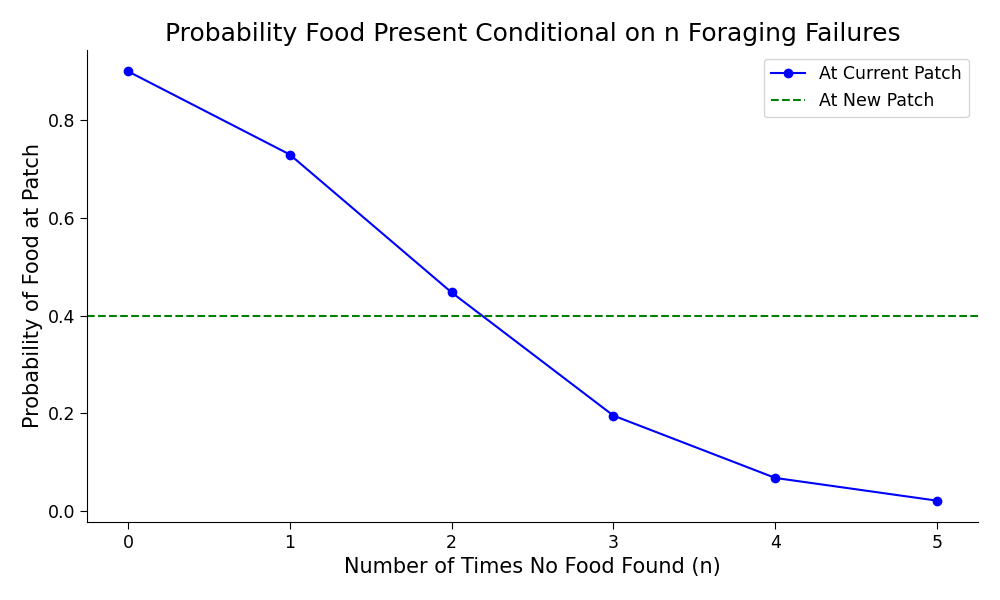

In [7]:
p_e = 0.4  # Probability of food being present at a new patch
p_s = 0.7  # Probability of foraging success
p_x = 0.1  # Probability of patch exhaustion after success

def prob_still_food_after_n_fails(n, p_s, p_x):
  return ((1 - p_s) ** n * (1 - p_x)) / ((1 - p_s) ** n * (1 - p_x) + p_x)

# Calculating probabilities different n values
n_values = np.arange(0, 6)  # From 0 to 5
prob_values = [prob_still_food_after_n_fails(n, p_s, p_x) for n in n_values]

# Plotting the probabilities
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(n_values, prob_values, marker='o', color='blue', label='At Current Patch')
ax.axhline(y=p_e, color='green', linestyle='--', label='At New Patch')

ax.set_title('Probability Food Present Conditional on n Foraging Failures')
ax.set_xlabel('Number of Times No Food Found (n)')
ax.set_ylabel('Probability of Food at Patch')
ax.grid(False)
ax.legend()
remove_ip_clutter(fig)

plt.show()

Looking at this figure it is clear that even after 2 failures, for these parameter values at least, it is still better to forage at the current patch. However after 3 consecutive foraging failures enough evidence against there being food present at the current patch has accumulated and its time for the forager to move on to a new patch.

## Optimal Thresholds

Summarizing our analysis thus far.
No matter what the parameter values a single foraging failure at a new patch should prompt the forager to move on to a new patch (provided there

Okay after that detour through probability calculations let's get back to our situations and the probability of finding food. At a new patch the probability of finding food is $p_e \cdot p_s$ (just multiply the probabilities along the path in the diagram).

In [ ]:
nodes_list = ["New", "Has Food", "No Food",
              "Didn't Find Food", "Found the Food",
              "No Food to Find",
              "Finally Found Food", "Still Didn't Find the Food",
              "Still No Food to Find",
              "Still Food", "Food Ran Out"]
edges_list = [("New", "Has Food"), ("New", "No Food"), ("Has Food", "Found the Food"),
              ("Has Food", "Didn't Find Food"), ("No Food", "No Food to Find"),
              ("Didn't Find Food", "Still Didn't Find the Food"),
              ("Didn't Find Food", "Finally Found Food"),
              ("Found the Food", "Still Food"), ("Found the Food", "Food Ran Out"),
              ("No Food to Find", "Still No Food to Find")]

latex_edge_labels = [
    ("New", "Has Food", "p_e"),
    ("New", "No Food", "1-p_e"),
    ("Has Food", "Didn't Find Food", "1-p_s"),
    ("Has Food", "Found the Food", "p_s"),
    ("No Food", "No Food to Find", "1"),
    ("No Food to Find", "Still No Food to Find", "1"),
    ("Didn't Find Food", "Finally Found Food", "p_s"),
    ("Didn't Find Food", "Still Didn't Find the Food", "1-p_s"),
    ("Found the Food", "Still Food", "1-p_x"),
    ("Found the Food", "Food Ran Out", "p_x"),
]

node_colors = {
    "New": "red",
    "Has Food": "red",
    "No Food": "red",
    "Didn't Find Food": "blue",
    "Found the Food": "green",
    "No Food to Find": "blue",
    "Finally Found Food": "orange",
    "Still No Food to Find": "purple",
    "Still Didn't Find the Food": "purple",
    "Still Food": "green",
    "Food Ran Out": "green"
}

node_labels = {
    "Didn't Find Food": "No Food Found",
    "No Food to Find": "No Food Found",
    "Finally Found Food": "Found the Food",
    "Still Didn't Find the Food": "Still No Food",
    "Still Food": "More Food There",
    "Still No Food to Find": "Still No Food"
}


output_path = create_and_render_graph(nodes_list, edges_list, latex_edge_labels,
                                      node_colors=node_colors,
                                      node_labels=node_labels)
Image(output_path, height=500)

## **Stochastic Dynamics**
Before starting to compute $V_{eat}$ and $V_{new}$ we need to take a little detour and map out all the possible situations a forager can encounter together with with associated probabilities of each situation occurring. To start, a forager is always in a New Patch (**NP**). From there one of two things can be true.
1. Either this is New Patch With Food(**NPWF**), which is the case with probability $p_e$, or
2. this is a New Patch with No Food (**NPNF**) which is the case with probability $1-p_e$.

This situation is visualized below:

In [ ]:
# @markdown **Run This Cell** to visualize these probabilities

nodes_list = ["NP", "NPWF", "NPNF"]
edges_list = [("NP", "NPWF"), ("NP", "NPNF")]

latex_edge_labels = [
    ("NP", "NPWF", "p_e"),
    ("NP", "NPNF", "1-p_e"),
]

output_path = create_and_render_graph(nodes_list, edges_list, latex_edge_labels)
Image(output_path, height=400)

When the forager is at a New Patch with No Food (**NPNF**), they will persistently forage there until either:
1. They hit their threshold number of attempts $\tau_{new}$ and move on to a new patch, the **NP** state. This happens with probability $\gamma^{\tau_{new}}$.  
2. The session ends before they reach this threshold. This happens with probability $1-\gamma^{\tau_{new}}$.

Let's add this to our visualization.

In [ ]:
# @markdown **Run This Cell** to visualize these probabilities

nodes_list = ["NP", "NPWF", "NPNF", "END"]
edges_list = [("NP", "NPWF"), ("NP", "NPNF"), ("NPNF", "END"), ("NPNF", "NP")]

latex_edge_labels = [
    ("NP", "NPWF", "p_e"),
    ("NP", "NPNF", "1-p_e"),
    ("NPNF", "END", "1-\gamma^{\\tau_{new}}"),
    ("NPNF", "NP", "\gamma^{\\tau_{new}}"),
]

output_path = create_and_render_graph(nodes_list, edges_list, latex_edge_labels)
Image(output_path, height=400)

Now things get trickier. At a New Patch With Food multiple outcomes are possible, but for simplification we'll lump these into two broad cases:
1. Nothing 'interesting', i.e. eating or dying, happens before the threshold number of turns passes and the forager moves on to a New Patch. We will denote the probability of nothing 'interesting' happening on a single forager turn as $p_n=(1-p_s)\gamma$, the probability that the forager doesn't find food and survives to the next round. Then extending this, the probability of $\tau_{new}$ uninteresting rounds in a row is ${p_n}^{\tau_{new}}$.
2. Something 'interesting' (food or death) happens before the threshold number of rounds passes. The probability this is $1 - {p_n}^{\tau_{new}}$. Let's call this the New Patch Something Happens state (**NPSH**).

Let's integrate this into our visualization.

In [ ]:
# @markdown **Run This Cell** to visualize these probabilities

nodes_list = ["NP", "NPWF", "NPNF", "END", "NPSH"]
edges_list = [("NP", "NPWF"), ("NP", "NPNF"), ("NPNF", "END"), ("NPNF", "NP"),
              ("NPWF", "NP"), ("NPWF", "NPSH")]

latex_edge_labels = [
    ("NP", "NPWF", "p_e"),
    ("NP", "NPNF", "1-p_e"),
    ("NPNF", "END", "1-\gamma^{\\tau_{new}}"),
    ("NPNF", "NP", "\gamma^{\\tau_{new}}"),
    ("NPWF", "NP", "{p_n}^{\\tau_{new}}"),
    ("NPWF", "NPSH", "1 - {p_n}^{\\tau_{new}}")
]

output_path = create_and_render_graph(nodes_list, edges_list, latex_edge_labels)
Image(output_path, width=800)

At a New Patch Something Happens state (**NPSH**), the forager experiences either death, eating, or both simultaneously. Let's break down the probabilities of each event.

For each round we have

1. No eating, no death: $(1-p_s) \gamma $
2. Eating, no death: $p_s \gamma$
3. No eating, death: $(1-p_s) (1-\gamma)$
4. Eating and death: $p_s (1-\gamma)$

However, **NPSH** is when one of cases 2, 3, or 4 occurred, on at least one round before $\tau_{new}$ rounds pass. We can focus our attention on the first interesting thing that happened as this is what determines our transition. Given that a first event occurs on a particular round, the probabilities for the possible types of first events on that round are:
* Eating, no death: $\frac{p_s \gamma}{1 - (1-p_s)\gamma}$
* No eating, death: $\frac{(1-p_s) (1-\gamma)}{1 - (1-p_s)\gamma}$
* Eating and death: $\frac{p_s (1-\gamma)}{1 - (1-p_s)\gamma}$

Now, because the probabilities of death and foraging success don't change from round to round, these are also the probabilities of each of those cases being the first interesting thing that happens, conditional on something interesting happening.

Two of these transitions lead to the **END** state, but one of the transitions results in a point for the forager whereas the other does not. If the forager eats without dying they transition to the Successful Eating **SE** state. Now, let's visualize these additions to our transition graph.

In [ ]:
# @markdown **Run This Cell** to visualize these probabilities

nodes_list = ["NP", "NPWF", "NPNF", "END", "NPSH", "SE"]
edges_list = [("NP", "NPWF"), ("NP", "NPNF"), ("NPNF", "END"), ("NPNF", "NP"),
              ("NPWF", "NP"), ("NPWF", "NPSH"),
              ("NPSH", "SE"), ("NPSH", "END"), ("NPSH", "END")]

latex_edge_labels = [
    ("NP", "NPWF", "p_e"),
    ("NP", "NPNF",  "1-p_e"),
    ("NPNF", "END", "1-\gamma^{\\tau_{new}}"),
    ("NPNF", "NP", "\gamma^{\\tau_{new}}"),
    ("NPWF", "NP", "{p_n}^{\\tau_{new}}"),
    ("NPWF", "NPSH", "1 - {p_n}^{\\tau_{new}}"),
    ("NPSH", "SE", "\\frac{p_s \\gamma}{1 - (1-p_s)\\gamma}"),
    ("NPSH", "END", "\\frac{(1-p_s) (1-\\gamma)}{1 - (1-p_s)\\gamma}"),
    ("NPSH", "END", "\\frac{p_s (1-\\gamma)}{1 - (1-p_s)\\gamma}")
]

output_path = create_and_render_graph(nodes_list, edges_list, latex_edge_labels)
Image(output_path, height=400)

The Successful Eating state (**SE**) is a lot like the **NP** state, except, now instead of $p_e$ giving the probability of food existing or not at the patch, the patch exhaustion probability $p_x$ determines whether this Successful Eating patch becomes a Successful Eating With Food patch (**SEWF**) or a Successful Eating No Food patch (**SENF**). Adding these states to our visualization we have.

In [ ]:
# @markdown **Run This Cell** to visualize these probabilities

nodes_list = ["NP", "NPWF", "NPNF", "END", "NPSH", "SE", "SEWF", "SENF"]

edges_list = [("NP", "NPWF"), ("NP", "NPNF"), ("NPNF", "END"), ("NPNF", "NP"),
                      ("NPWF", "NP"), ("NPWF", "NPSH"),
                      ("NPSH", "SE"), ("NPSH", "END"), ("NPSH", "END"),
                      ("SE", "SEWF"), ("SE", "SENF")]

latex_edge_labels = [
    ("NP", "NPWF", "p_e"),
    ("NP", "NPNF",  "1-p_e"),
    ("NPNF", "END", "1-\gamma^{\\tau_{new}}"),
    ("NPNF", "NP", "\gamma^{\\tau_{new}}"),
    ("NPWF", "NP", "{p_n}^{\\tau_{new}}"),
    ("NPWF", "NPSH", "1 - {p_n}^{\\tau_{new}}"),
    ("NPSH", "SE", "\\frac{p_s \\gamma}{1 - (1-p_s)\\gamma}"),
    ("NPSH", "END", "\\frac{(1-p_s) (1-\\gamma)}{1 - (1-p_s)\\gamma}"),
    ("NPSH", "END", "\\frac{p_s (1-\\gamma)}{1 - (1-p_s)\\gamma}"),
    ("SE", "SEWF", "1-p_x"),
    ("SE", "SENF", "p_x")
]

output_path = create_and_render_graph(nodes_list, edges_list, latex_edge_labels)
Image(output_path, height=500)

And again, much like the transition probabilities out of New Patch With Food (**NPWF**) and the New Patch with No Food (**NPNF**) are determined largely by $\tau_{new}$, the transition probabilities out of Successful Eating patch With Food (**SEWF**) and Successful Eating patch with No Food (**SENF**) follow the same logic but are determined by $\tau_{eat}$. Adding these transitions and the Successful Eating Something Happened (**SESH**) state, and its transitions, which are identical to the the transitions out of the **NPSH** state, completes our visualization of the probabilistic dynamics of this foraging problem.

In [ ]:
# @markdown **Run This Cell** to visualize these probabilities

nodes_list = ["NP", "NPWF", "NPNF", "END", "NPSH", "SE", "SEWF", "SENF"]

edges_list = [("NP", "NPWF"), ("NP", "NPNF"),
              ("NPNF", "END"), ("NPNF", "NP"),
              ("NPWF", "NP"), ("NPWF", "NPSH"),
              ("NPSH", "SE"), ("NPSH", "END"), ("NPSH", "END"),
              ("SE", "SEWF"), ("SE", "SENF"),
              ("SENF", "END"), ("SENF", "NP"),
              ("SEWF", "NP"), ("SEWF", "SESH"),
              ("SESH", "SE"), ("SESH", "END"), ("SESH", "END")]

latex_edge_labels = [
    ("NP", "NPWF", "p_e"),
    ("NP", "NPNF",  "1-p_e"),
    ("NPNF", "END", "1-\gamma^{\\tau_{new}}"),
    ("NPNF", "NP", "\gamma^{\\tau_{new}}"),
    ("NPWF", "NP", "{p_n}^{\\tau_{new}}"),
    ("NPWF", "NPSH", "1 - {p_n}^{\\tau_{new}}"),
    ("NPSH", "SE", "\\frac{p_s \\gamma}{1 - (1-p_s)\\gamma}"),
    ("NPSH", "END", "\\frac{(1-p_s) (1-\\gamma)}{1 - (1-p_s)\\gamma}"),
    ("NPSH", "END", "\\frac{p_s (1-\\gamma)}{1 - (1-p_s)\\gamma}"),
    ("SE", "SEWF", "1-p_x"),
    ("SE", "SENF", "p_x"),
    ("SENF", "END", "1-\gamma^{\\tau_{eat}}"),
    ("SENF", "NP", "\gamma^{\\tau_{eat}}"),
    ("SEWF", "NP", "{p_n}^{\\tau_{eat}}"),
    ("SEWF", "SESH", "1 - {p_n}^{\\tau_{new}}"),
    ("SESH", "SE", "\\frac{p_s \\gamma}{1 - (1-p_s)\\gamma}"),
    ("SESH", "END", "\\frac{(1-p_s) (1-\\gamma)}{1 - (1-p_s)\\gamma}"),
    ("SESH", "END", "\\frac{p_s (1-\\gamma)}{1 - (1-p_s)\\gamma}")
]
output_path = create_and_render_graph(nodes_list, edges_list, latex_edge_labels)
Image(output_path, height=800)

States:

1. **NP**: New Patch - Represents the initial state when a forager enters a new patch.
2. **NPWF**: New Patch With Food - A state in which the forager is in a new patch, and there's food available.
3. **NPNF**: New Patch No Food - A state in which the forager is in a new patch, but there's no food.
4. **NPSH**: New Patch Something Happens - Represents events that can occur in a new patch: eating, death, or both.
5. **SE**: Successful Eating - Indicates a forager successfully eating in a patch.
6. **SEWF**: Successful Eating With Food - A state post-successful eating where food remains in the patch.
7. **SENF**: Successful Eating No Food - A state post-successful eating where no food remains in the patch.
8. **SESH**: Successful Eating Something Happens - Represents events that can occur post-successful eating.
9. **END**: End - Represents the end state, which could be due to the forager dying or another terminal event.

Note that **NP**, **NPWF**, and **NPNF** are all the same from the forager's perspective, similarly **SE**, **SEWF**, and **SENF** are all the same from the forager's perspective. We've introduced these states to keep track of the underlying dynamics, not the forager's experience of the environment. The **NPSH** and **SESH** states are also just helpful 'book keeping' states for helping us think about the underlying probabilities of the system and don't directly correspond to the forager's experience.

  Transitions:
  
  * **NP** to **NPWF**: $p_e$ - Probability that the new patch is food-rich.
  
  * **NP** to **NPNF**: $1-p_e$ - Probability that the new patch is food-less.
  
  * **NPNF** to **END**: $1-\gamma^{\tau_{new}}$ - Probability of a terminal event while foraging at a food-less patch over set number of rounds ($\tau_{new}$).
  
  * **NPNF** to **NP**: $\gamma^{\tau_{new}}$ - Probability of foraging and surviving at a food-less patch for a set number (\tau_{new}) of rounds, and then as a result leaving to find a new patch.
  
  * **NPWF** to **NP**: ${p_n}^{\tau_{new}}$ - Probability of no event (eating or death) occurring while foraging and surviving at a food-rich patch for a set number ($\tau_{new}$) of rounds and as a result leaving to find a new patch.
  
  * **NPWF** to **NPSH**: $1 - {p_n}^{\tau_{new}}$ - Probability of an event (eating, death) while foraging at at food-rich patch over a set number ($/tau_{new}$) of rounds.
  
  * **NPSH** to **SE**: $\frac{p_s \gamma}{1 - (1-p_s)\gamma}$ - Probability of eating without dying conditional on something having happened (being in the NPSH state).
  
  * **NPSH** to **END** (due to death without eating): $\frac{(1-p_s) (1-\gamma)}{1 - (1-p_s)\gamma}$.
  
  * **NPSH** to **END** (due to eating then dying): $\frac{p_s (1-\gamma)}{1 - (1-p_s)\gamma}$.
  
  * **SE** to **SEWF**: $1-p_x$ - Probability of food still existing post successful eating.
  
  * **SE** to **SENF**: $p_x$ - Probability of no food existing post successful eating.

  * **SENF** to **END**: $1-\gamma^{\tau_{eat}}$ - Probability of a terminal event while foraging at a food-less patch over set number of rounds ($\tau_{eat}$).
  
  * **SENF** to **NP**: $\gamma^{\tau_{eat}}$ - Probability of foraging and surviving at a food-less patch for a set number (\tau_{eat}) of rounds, and then as a result leaving to find a new patch.
  
  * **SEWF** to **NP**: ${p_n}^{\tau_{eat}}$ - Probability of no event (eating or death) occurring while foraging and surviving at a food-rich patch for a set number ($\tau_{new}$) of rounds and as a result leaving to find a new patch.
  
  * **SEWF** to **SESH**: 1 - ${p_n}^{\tau_{eat}}$ - Probability of an event (eating, death) while foraging at at food-rich patch over a set number ($/tau_{eat}$) of rounds.
  
  * **SESH** to **SE**: $\frac{p_s \gamma}{1 - (1-p_s)\gamma}$ - Probability of eating without dying conditional on something having happened (being in the SESH state).
  
  * **SESH** to **END** (due to death without eating): $\frac{(1-p_s) (1-\gamma)}{1 - (1-p_s)\gamma}$.
  
  * **SESH** to **END** (due to eating then dying): $\frac{p_s (1-\gamma)}{1 - (1-p_s)\gamma}$.

(Math Box: Stochastic processes like this, where the probabilities of transitioning into any given state, depend only on the current state of the system are called Markov processes (sometimes Markov chains), and are a cornerstone of Reinforcement Learning.)

## **Value Functions**

Those transition probabilities ended up being a bit much but we're now in a good position to both start writing down some critical ***Values*** and to appreciate how the concept of ***Value*** as **expected future cumulative reward** can help simplify a problem. Specifically we will compute:

1. $V(\text{NP})$: Value of being in a new patch.
2. $V(\text{SE})$: Value of being in a patch immediately after successful foraging.

We will compute these in terms of:
3. $V(\text{NPWF})$: Value of being in a patch with food, given a threshold $\tau_{new}$ for unsuccessful foraging attempts before moving on.
4. $V(\text{NPNF})$: Value of being in a patch without food, given a threshold
$\tau_{new}$ for unsuccessful foraging attempts before moving on.
5. $V(\text{SEWF})$: Value of being in a patch with food, given a threshold $\tau_{eat}$ for unsuccessful foraging attempts before moving on.
6. $V(\text{SENF})$: Value of being in a patch without food, given a threshold
$\tau_{eat}$ for unsuccessful foraging attempts before moving on.

But first we notice that 3 and and 5 are very similar, as are 4 and 6 so we can simplify and write:
* $V_{\tau}(\text{WF}$): Value of being in a patch with food, given threshold $\tau$.
* $V_{\tau}(\text{NF})$: Value of being in a patch with no food, given threshold $\tau$.

Upon arriving at a New Patch, there's a $p_e$ probability it has food and a $1-p_e$ probability it doesn't.

$$
V(\text{NP}) = p_e \cdot V_{\tau_{new}}(\text{WF}) + (1-p_e) \cdot V_{\tau_{new}}(\text{NF})
$$

After Successful Eating, there's a $p_x$ probability the food runs out and a $1-p_x$ probability it remains.

$$
V(\text{SE}) = (1-p_x) \cdot V_{\tau_{eat}}(\text{WF}) + p_x \cdot V_{\tau_{eat}}(\text{NF})
$$

Given a threshold $\tau$ for unsuccessful attempts:
- The forager will move on to new patch after $\tau$ unsuccessful attempts, which happens with probability $(1-p_s)^\tau \gamma^{\tau}$. They will survive this journey to the new patch with probability $\gamma$
- Or, the organism finds food in one of the first $\tau$ attempts.

Thus, the value of being at a patch that With Food, given the organism will leave after $\tau$ failed foraging attempts is:

$$
V_{\tau}(\text{WF}) = (1-p_s)^\tau \cdot \gamma^{\tau+1} \cdot V(\text{NP}) + p_s \cdot (1+\gamma V(\text{SE})) \cdot \sum_{i=0}^{\tau-1} (1-p_s)^i \cdot \gamma^i
$$

For an organism in a patch with no food, there is no chance of finding food on any attempt, and so after $\tau$ unsuccessful attempts, it moves on to a new patch, and it survives this journey with probability $\gamma$. Thus the value of being in such a state is:

$$
V_{\tau}(\text{NF}) = \gamma^{\tau+1} \cdot V_{\text{new}}
$$

With each unsuccessful forage attempt that does not pass the threshold, the organism stays in the current state, but the value is discounted by $\gamma$ the probability of the the session ending. Note that the transitions the the **END** state that introduced a lot of complications in our state transition diagram are all nicely rolled into these recurrence relations.

## **Optimal Thresholds**

These recurrence relations between the values of different states allows us to write the $V(\text{NP})$ and $V(\text{SE})$ in terms of each other, the parameters of the model and the thresholds.

Substituting $V_{\tau_{new}}(\text{WF})$ and $V_{\tau_{new}}(\text{WF})$ into $V(NP)$ we have:
$$V(\text{NP}) = $$
$$
p_e \cdot \left[ (1-p_s)^{\tau_{new}} \cdot \gamma^{\tau_{new}+1} \cdot V(\text{NP}) + p_s \cdot (1+\gamma V(\text{SE})) \cdot \sum_{i=0}^{\tau_{new}-1} (1-p_s)^i \cdot \gamma^i \right]
$$
$$
+ (1-p_e) \cdot \gamma^{\tau_{new}+1} \cdot V(\text{NP})
$$

Similarly substituting $V_{\tau_{eat}}(\text{WF})$ and $V_{\tau_{eat}}(\text{WF})$ into $V(SE)$ we have:
$$V(\text{SE}) = $$
$$(1-p_x) \cdot \left[ (1-p_s)^{\tau_{eat}+1} \cdot \gamma^{\tau_{eat}} \cdot V(\text{NP}) + p_s \cdot (1+\gamma V(\text{SE})) \cdot \sum_{i=0}^{\tau_{eat}-1} (1-p_s)^i \cdot \gamma^i \right]
$$
$$
+ p_x \cdot \gamma^{\tau_{eat}+1} \cdot V(\text{NP})
$$

We can further re-arrange these into a nice system of linear equations

$$ \mathbf{v} = A \mathbf{v} + \mathbf{b} $$ with

$$\mathbf{v} = \begin{bmatrix}
V(\text{NP}) \\
V(\text{SE}) \\
\end{bmatrix}, $$

and with

$$ A = \begin{bmatrix}
a_{11} & a_{12} \\
a_{21} & a_{22} \\
\end{bmatrix},$$

where

$$a_{11} = p_e \cdot (1-p_s)^{\tau_{new}} \cdot \gamma^{\tau_{new}+1} + (1-p_e) \cdot \gamma^{\tau_{new}+1}$$

$$a_{12} = p_e \cdot p_s \cdot \gamma \cdot \sum_{i=0}^{\tau_{new}-1} (1-p_s)^i \cdot \gamma^i$$

$$a_{21} = (1-p_x) \cdot (1-p_s)^{\tau_{eat}+1} \cdot \gamma^{\tau_{eat}} + p_x \cdot \gamma^{\tau_{eat}+1}$$

$$a_{22} = (1-p_x) \cdot p_s \cdot \gamma \cdot \sum_{i=0}^{\tau_{eat}-1} (1-p_s)^i \cdot \gamma^i,$$

and with

$$ \mathbf{b} = \begin{bmatrix}
b_1 \\
b_2 \\
\end{bmatrix}, $$

where
$$ b_1 = p_e \cdot p_s \cdot \sum_{i=0}^{\tau_{new}-1} (1-p_s)^i \cdot \gamma^{i+1} $$
$$b_2 = (1-p_x) \cdot p_s \cdot \sum_{i=0}^{\tau_{eat}-1} (1-p_s)^i \cdot \gamma^{i+1}.$$

When all of the parameters of the model are known and the thresholds are set, this becomes a system of linear equations with two variables, $V(NP)$ and $V(SE)$, that can be solved using linear algebra. Let's write a little function that computes $A$ and $\mathbf{b}$ and then solves for $\mathbf{v}$.

In [ ]:
###############################################################################
# TODO for students: Uncomment each line starting with ... and replace each
# instance of ... with one of a11, a12, a21, a22, b1 and b2
# to assign the correct computations to the correct elements of A and b
raise NotImplementedError("Exercise: implement linear system of equations")
################################################################################


def compute_A_b_solve_v(p_e, p_x, p_s, gamma, tau_new, tau_eat, verbose=True):
  # Summation terms for tau_new and tau_eat
  sum_new = sum([(1-p_s)**i * gamma**i for i in range(tau_new)])
  sum_eat = sum([(1-p_s)**i * gamma**i for i in range(tau_eat)])

  # Coefficients for the matrix A and vector b
  # ... = p_e * (1-p_s)**(tau_new) * gamma**(tau_new+1) + (1-p_e) * gamma**(tau_new+1)
  # ... = p_e * p_s * gamma * sum_new
  # ... = p_e * p_s * sum_new

  # ... = (1 - p_x) * (1-p_s)**tau_eat * gamma**(tau_eat+1) + p_x * gamma**(tau_eat+1)
  # ... = (1 - p_x) * p_s * gamma * sum_eat
  # ... = (1 - p_x) * p_s * sum_eat

  A = np.array([[a11, a12],
                [a21, a22]])

  b = np.array([b1, b2])

  I = np.identity(2)

  if verbose:
    print("Matrix A:")
    print(A)
    print("\nVector b:")
    print(b)
    print("\nMatrix I - A:")
    print(I - A)

  # Solve the system of equations
  v = np.linalg.solve(I - A, b)

  return v[0], v[1]

# Parameters from earlier simulations
p_e = 0.5
p_x = 0.2
p_s = 0.9
gamma = (1 - 0.05)
tau_new = 1
tau_eat = 0

V_NP, V_SE = compute_A_b_solve_v(p_e, p_x, p_s, gamma, tau_new, tau_eat)
print("\nV(NP) =", V_NP)
print("V(SE) =", V_SE)

In [ ]:
# to_remove solution

def compute_A_b_solve_v(p_e, p_x, p_s, gamma, tau_new, tau_eat, verbose=True):
  # Summation terms for tau_new and tau_eat
  sum_new = sum([(1-p_s)**i * gamma**i for i in range(tau_new)])
  sum_eat = sum([(1-p_s)**i * gamma**i for i in range(tau_eat)])

  # Coefficients for the matrix A and vector b
  a11 = p_e * (1-p_s)**(tau_new) * gamma**(tau_new+1) + (1-p_e) * gamma**(tau_new+1)
  a12 = p_e * p_s * gamma * sum_new
  b1  = p_e * p_s * sum_new

  a21 = (1 - p_x) * (1-p_s)**tau_eat * gamma**(tau_eat+1) + p_x * gamma**(tau_eat+1)
  a22 = (1 - p_x) * p_s * gamma * sum_eat
  b2  = (1 - p_x) * p_s * sum_eat

  A = np.array([[a11, a12],
                [a21, a22]])

  b = np.array([b1, b2])

  I = np.identity(2)

  if verbose:
    print("Matrix A:")
    print(A)
    print("\nVector b:")
    print(b)
    print("\nMatrix I - A:")
    print(I - A)

  # Solve the system of equations
  v = np.linalg.solve(I - A, b)

  return v[0], v[1]

# Parameters from earlier simulations
p_e = 0.5
p_x = 0.2
p_s = 0.9
gamma = (1 - 0.05)
tau_new = 1
tau_eat = 0

V_NP, V_SE = compute_A_b_solve_v(p_e, p_x, p_s, gamma, tau_new, tau_eat)
print("\nV(NP) =", V_NP)
print("V(SE) =", V_SE)

At first glance this function may not seem all the different from other policy evaluation functions we have used in the past. However, there is both a profound and a practical difference. Our previous evaluation functions have relied on running many simulations of a game scenario (often in parallel) to get an ***estimate*** of policy effectiveness based on a stochastic sample of possible scenarios. This analytic approach is radically different. Here we have ***directly computed*** the true *expected* performance of the policy. It is not an estimate. In theory we could further analyze the value of being in a New Patch, $V(NP)$, as an implicit function of the policy parameters $\tau_{new}$ and $\tau_{eat}$ and directly derive the optimal thresholds. However, such an analysis quickly becomes quite complicated, and in practice it is much easier to search the parameter space using this analytic value function in an optimization process. Here, the parameter space of the policy is quite small. There are only two positive integer parameters. Use the widget below to find the best threshold policy.

In [ ]:
# @markdown **Run This Cell** to evaluate the expected value of this foraging scenario under different threshold combinations

class ValueHeatmapWidget:

  def __init__(self, p_e, p_x, p_s, gamma):
    self.p_e = p_e
    self.p_x = p_x
    self.p_s = p_s
    self.gamma = gamma
    self.heatmap_data = np.zeros((12, 12))
    self.fig, self.ax = plt.subplots(figsize=(10, 8))
    self.ax.set_xlabel('Eat Threshold')
    self.ax.set_ylabel('New Patch Threshold')
    self.ax.set_xlim(-0.5, 10.5)
    self.ax.set_ylim((11.5, -0.5))
    self.ax.xaxis.tick_top()
    self.ax.xaxis.set_label_position('top')
    self.ax.spines['top'].set_visible(True)
    self.ax.spines['right'].set_visible(True)
    self.ax.spines['bottom'].set_visible(True)
    self.ax.spines['left'].set_visible(True)
    remove_ip_clutter(self.fig)
    #y_ticks = self.ax.get_yticks().tolist()
    # Adjust the labels
    #y_labels = [str(int(tick+1)) for tick in y_ticks if 0 <= tick < 11]
    # Set the new labels without altering the tick positions
    #self.ax.set_yticklabels(y_labels)
    self.text_annotations = []

    # Create sliders
    self.tau_new_slider = widgets.IntSlider(min=1, max=11, step=1, value=5)
    self.tau_eat_slider = widgets.IntSlider(min=0, max=10, step=1, value=5)
    self.tau_new_label = widgets.Label(value="New Patch Threshold")
    self.tau_eat_label = widgets.Label(value="Successful Eating Threshold")
    self.tau_new_box = widgets.VBox([self.tau_new_label, self.tau_new_slider])
    self.tau_eat_box = widgets.VBox([self.tau_eat_label, self.tau_eat_slider])

    # Create compute button
    self.compute_button = widgets.Button(description="Compute Value")
    self.compute_button.on_click(self.update_plot)

    # Put the display together with the VBoxes and button
    self.sliders = widgets.VBox([self.tau_new_box, self.tau_eat_box, self.compute_button])
    self.final_display = widgets.HBox([self.sliders, self.fig.canvas])

  def update_cax(self, data):
    if hasattr(self, 'cax'):
      self.cax.set_data(data)
      self.cax.autoscale()
      self.colorbar.remove()
    else:
      self.cax = self.ax.matshow(data, cmap='gray_r')

    self.colorbar = self.fig.colorbar(self.cax, ax=self.ax)

  def update_plot(self, change=None):
    tau_new = self.tau_new_slider.value
    tau_eat = self.tau_eat_slider.value
    V_NP, _ = compute_A_b_solve_v(p_e, p_x, p_s, gamma,
                                    tau_new, tau_eat, verbose=False)
    # Update heatmap_data
    self.heatmap_data[tau_new, tau_eat] = V_NP

    # Plot
    self.update_cax(self.heatmap_data)

    for txt in self.text_annotations:
      txt.remove()
    self.text_annotations.clear()

    # Annotate heatmap
    for i in range(11):
      for j in range(12):
        c = self.heatmap_data[j, i]
        if c != 0:
          txt = self.ax.text(i, j, f"{c:.2f}", va='center', ha='center', color='w' if c > 0.5 else 'k')
          self.text_annotations.append(txt)

    self.fig.canvas.draw()


def compute_A_b_solve_v(p_e, p_x, p_s, gamma, tau_new, tau_eat, verbose=True):
  # Summation terms for tau_new and tau_eat
  sum_new = sum([(1-p_s)**i * gamma**i for i in range(tau_new)])
  sum_eat = sum([(1-p_s)**i * gamma**i for i in range(tau_eat)])

  # Coefficients for the matrix A and vector b
  a11 = p_e * (1-p_s)**(tau_new) * gamma**(tau_new+1) + (1-p_e) * gamma**(tau_new+1)
  a12 = p_e * p_s * gamma * sum_new
  b1  = p_e * p_s * sum_new

  a21 = (1 - p_x) * (1-p_s)**tau_eat * gamma**(tau_eat+1) + p_x * gamma**(tau_eat+1)
  a22 = (1 - p_x) * p_s * gamma * sum_eat
  b2  = (1 - p_x) * p_s * sum_eat

  A = np.array([[a11, a12],
                [a21, a22]])

  b = np.array([b1, b2])

  I = np.identity(2)

  if verbose:
    print("Matrix A:")
    print(A)
    print("\nVector b:")
    print(b)
    print("\nMatrix I - A:")
    print(I - A)

  # Solve the system of equations
  v = np.linalg.solve(I - A, b)

  return v[0], v[1]

# Using the class
vh_widget = ValueHeatmapWidget(p_e=0.5, p_x=0.2, p_s=0.9, gamma=(1 - 0.05))
display(vh_widget.fig.canvas)
clear_output()
display(vh_widget.final_display)

[Answer](## "Answer: New Patch Threshold = 1, Successful Eating Threshold = 2")

To help appreciate the practical difference between these two approaches we will time and compare a simulation based approach to policy evaluation, together with this analytic approach

In [ ]:
# Simulation based policy evaluation
%%timeit
pfg = PatchyForagingGame(batch_size=50, food_patch_prob=0.5, food_extinct_prob=0.2,
                         death_rate=0.05, food_regen_prob=0)
stp = SimpleThresholdPlayer(pfg, critter_index=1, threshold_new=1, threshold_known=2)
result = pfg.play_game([stp])

In [ ]:
# Analytical policy evaluation
%%timeit
p_e = 0.5
p_x = 0.2
p_s = 0.9
gamma = (1 - 0.05)
tau_new = 1
tau_eat = 0

V_NP, V_SE = compute_A_b_solve_v(p_e, p_x, p_s, gamma, tau_new, tau_eat, verbose=False)

With some thought and effort we can get an exact answer in less the 1/1000 of the time it takes to get a rough estimate based on simulation. In this particular case the parameter space (after we introduced the idea of a threshold policy) is relatively small so these difference don't affect the overall tractability of the problem, but in other more complicated parameter spaces this kind of difference in function evaluation cost can mean the difference between getting a solution in minutes or getting a solution in weeks.

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M2")

# **1.2.3.3 Propose and Test versus Reasoning**

Now that we've reasoned about policies and used our analysis to determine the optimal policy let's see how our old standby approach 'Propose and Test' does with this same problem.

In [ ]:
# @title Propose and Test
# @markdown Run this cell to use the propose and test method to find good parameters for this patchy foraging problem.

def evaluate(params, game):
  stp = SimpleThresholdPlayer(game, critter_index=1, threshold_new=params[0],
                              threshold_known=params[1])
  result = game.play_game([stp])
  return(np.mean(result['scores']))


def patchy_propose_and_test(batch_size=400,
                            initial_params=None,
                            max_rejected=200,
                            verbose=True):

  game = PatchyForagingGame(batch_size=batch_size, food_patch_prob=0.5,
                            food_extinct_prob=0.2, death_rate=0.05,
                            food_regen_prob=0)
  tested_params_dict = {}
  # Initialize parameters
  if initial_params is None:
    initial_params = 5*np.ones(2, dtype=int)
  best_params = initial_params
  best_avg_score = evaluate(best_params, game)
  print(f"Initial score: {best_avg_score}")
  rejected_count = 0
  total_tests = 0  # Number of iterations
  if verbose:
    intermediate_params = []
    intermediate_params.append(best_params)
    intermediate_values = [best_avg_score]
    iterations = [0]

  # Propose-and-test loop
  start_time = time.time()
  while rejected_count < max_rejected:
    total_tests +=1
    # Propose new parameters: sample custom list of small discrete steps
    # centered at best_params
    delta_dim1 = np.random.choice([-2, -1, 0, 1, 2])
    delta_dim2 = np.random.choice([-2, -1, 0, 1, 2])
    delta_params = np.array([delta_dim1, delta_dim2])
    proposal_params = best_params + delta_params
    # Ensure that the values for the first dimension don't go below 0
    proposal_params[0] = max(0, proposal_params[0])
    proposal_params[1] = max(1, proposal_params[1])

    if tuple(proposal_params) in tested_params_dict.keys():  # Step 2: Check if the proposed parameters have been tested before.
      #print('already tested' + str(proposal_params))
      rejected_count += 1
      continue

    #print('now testing' + str(proposal_params))
    avg_score = evaluate(proposal_params, game)
    tested_params_dict[tuple(proposal_params)] = avg_score

    if avg_score > best_avg_score:
      best_params = proposal_params
      best_avg_score = avg_score
      if verbose:
        print('best params so far:')
        display(best_params)
        print(f"Best score so far: {best_avg_score}")
        print(f"Found after a total of {time.time() - start_time:.2f} seconds")
        rejected_count = 0
    else:
      rejected_count += 1

  end_time = time.time()
  elapsed_time = end_time - start_time
  iterations.append(total_tests)

  if verbose:
    # Print the best found parameters and score
    print("Best Parameters:", best_params)
    print("Best Average Score:", best_avg_score)
    print("Parameter combinations tested:", total_tests)
    print(f"Time taken for the optimization loop: {elapsed_time:.2f} seconds")
    return (best_params, best_avg_score, tested_params_dict)
  else:
    return best_params, best_avg_score

best_params, best_score, tested_params_dict = patchy_propose_and_test()

Questions:
1. Did the propose and test method using simulation based evaluation find the same optimal parameters as we did using analytical policy evaluation? [Answer](## "Using simulation based evaluation sometimes finds the true optimal parameters as determined using analytical policy evaluation, but due to the stochastic nature of this evaluation method sometimes propose and test only finds parameters that are close to optimal.")
2. What about the best scores reported by the propose and test algorithm using simulation based evaluation, are these higher, lower or about the same as determined using an analytical approach? [Answer](## "The best scores reported by the propose and test algorithm using simulation based evaluation are usually close to the true expected value, but again due to stochastic evaluation they are never exactly the same.")

## **Multiple Perspectives on Optima**

In this sequence we have looked at the same patchy foraging problem in two different ways.

The first perspective was to interact with and observe a 'full' simulation of the problem, where an organism plays through rounds of a game according to some policy and receives a score. This is how we have approached everything so far in this book. Although this perspective and this game are highly simplified compared to lived reality, this general approach of 'run it and see' is exactly what evolution is doing. Variations on the policy emerge due to recombination and mutation, organisms live their lives, and the effectiveness of their policy is 'evaluated' via natural selection, roughly as the number of offspring surviving to the next generation. Importantly, the evolutionary selective process needs no analytic insight into the nature of the environment in which organisms are born and execute their policies. It is a black box, 'run it and see' approach.

The second perspective, which we introduced here was to think about the nature of the problem, to write out a symbolic mathematical expressions that described the problem, and then through deductive reasoning arrive at an exact analytical method of evaluating threshold policy performance in this problem.

These perspectives, for the most part, converged on the same optimal policy. Why is this? The optimal solution of a problem is inherent to the problem itself, not the method used to find the solution. Thus, different optimization approaches applied to the same problem, will arrive at the same conclusions, to the extent that each different approach is effective. This insight has been a powerful tool in understanding evolved behaviours and traits, with optimality models helping to explain a staggering array of animal behaviours (and the behaviour of all kinds of life). These are just a few examples:

1. **Humming Bird Foraging**: Many animals are under selection pressure to maximize their net energy intake while minimizing the risk. The sequence in which hummingbirds feed on the flowers in their territory can be understood as minimizing flight distance and thus saving energy and time. This behavior exemplifies an energy-efficient strategy that boosts survival and reproductive chances.

2. **Web Building in Spiders**: Considering the metabolic cost of producing silk, spiders build their webs to capture the most prey while using the least amount of material. Different spider species, depending on their ecological niche, have optimized their web designs accordingly - from the dense tangle webs of the funnel-web spiders to the expansive orb webs of garden spiders.

3. **Echolocation in Bats**: Bats optimize the frequency and duration of their echolocation calls based on their environment and prey type. In cluttered environments, bats often use shorter frequency-modulated calls to detect nearby objects. However, in open spaces, they employ longer calls for detection over a more extended range. This behavioral adaptation can be viewed as an optimization problem where bats adjust their call parameters for maximum prey detection.

4. **Migratory Paths of Birds**: Migratory birds traverse vast distances, optimizing their routes to conserve energy, avoid predators, and capitalize on food sources. For example, the Arctic tern, traveling from its Arctic breeding grounds to the Antarctic coast, chooses a path that, although not the shortest, exploits prevailing wind patterns and abundant food sources.

5. **Root Architecture in Plants**: The way a plant structures its root system is crucial for both nutrient uptake and stability. For instance, in areas prone to drought, plants like mesquite trees invest in deep taproots that reach far into the soil, tapping into groundwater sources. In contrast, plants in nutrient-rich but unstable environments, like riverbanks, invest in expansive but shallow root systems to maximize nutrient absorption while anchoring themselves against fast-moving water.

6. **Leaf Orientation and Sun Tracking**: Sunflower fields during a sunny day offer a mesmerizing sight: rows of flowers all facing the sun. This behavior, known as heliotropism, allows the plant to maximize sunlight absorption. By tracking the sun across the sky, sunflowers optimize photosynthesis rates. Similarly, desert plants like the creosote bush have small, vertically-oriented leaves, reducing their exposure to the intense midday sun and minimizing water loss due to transpiration.

7. **Thermoregulation in Reptiles**: Cold-blooded reptiles, such as lizards and snakes, primarily thermoregulate through behaviour (not metabolically, like warm-blooded mammals and birds). Take the diurnal behavior of desert lizards: by basking in the morning sun, they quickly elevate their body temperature, optimizing their physiological functions for the day ahead. As midday approaches with its peak heat, these reptiles retreat to cooler shades or burrows, ensuring they don't overheat. This can be understood as an optimization strategy, balancing the need for warmth to maintain metabolic rates with the imperative to avoid lethal high temperatures.

8. **Camouflage and Coloration**: The appearance of many plants and animals appearances can be understood as optimization for avoiding detection. Consider the peppered moth in industrial England. Historically, the majority of these moths were light-colored, blending seamlessly with the lichen-covered trees. However, during the Industrial Revolution, pollution darkened the trees, giving an advantage to rare dark-colored moths. As these darker moths thrived in their new environment, their numbers surged, demonstrating a rapid optimization of camouflage in response to environmental changes.



Each of the examples above takes an 'Ultimate' evolutionary functional perspective to explain behaviours or traits. However, this is but one of four perspectives from which to understand a behaviour.

## **Different Kinds of Understanding: Tinbergen's Four Questions**

Building on work by Julian Huxley, Niko Tinbergen described four "whys" or perspectives for understanding an observed behaviour (adapted from Aristotle's four causes). These continue to ground and inform interdisciplinary work across the behavioural sciences.

1. **Mechanistic** (Sensory and Biophysical Causes): This approach seeks to understand the immediate causes of a behaviour from the sensory input that elicits it through to the biophysical processes of the organism which produce the behaviour in response to a particular environmental input. While the 'Ultimate' perspective might explain why a bird sings in terms of its evolutionary function, e.g. to attract a mate, the mechanistic perspective looks at how a bird's vocal cords, brain circuits, and hormones function together to produce the song in response to certain environmental conditions, but not others.

2. **Ontogenetic** (Developmental Causes): This perspective examines how a behavior develops in an individual over their lifetime. It encompasses aspects of both learning and maturation. For example, while many birds are born with the inherent capability to sing, they often refine their songs through interactions with their environment and other birds, improving their repertoire and accuracy over time.

3. **Functional** (Adaptive Evolutionary Causes): This is the perspective we have focused on so far. It seeks to understand behavior in terms of the selective advantage it confers to the organism. How does the behavior increase the chances of survival and reproduction? The hummingbird foraging and the spider web-building examples fit into this category, showcasing behaviors that have been optimized over generations for increased fitness.

4. **Phylogenetic** (Historical Evolutionary Causes): This perspective traces the behavior's lineage through evolutionary history. Why does a particular species exhibit this behavior, but not another? Did the common ancestor of these species also exhibit this behavior? How has evolutionary history set the conditions and constraints on which adaptive new forms are possible? For instance, the vertebrate eye (including the human eye) has a blind spot, whereas octopus eyes do not. In each of these two lineages, the eye originally developed in one of two distinct ways. Once this initial development program for the vertebrate eye was set, there were no intermediate forms that were both adaptive and would have enabled it to evolve without a blind spot.

Scientific work can be done using one, several, or all of these perspectives combined. No single perspective is inherently better or more important. What is deeply valuable though, for any project within the life sciences, is knowing which kinds of understanding are being aimed at, and how work from the other perspectives might guide and constrain understanding in the area(s) of focus.

In this book we will often take a functional perspective. However, understanding how phylogeny, ontogeny, and mechanism constrain and determine the optimization problems to be analyzed is critical to the relevance and validity of the functional perspective.

Where does this four-perspective framework situate neuroscience within the broader behavioral sciences? Traditionally, neuroscience has largely been part of a mechanistic understanding of behaviour, i.e. how do the brain circuits compute and produce muscles activations that generate appropriate behaviour given environmental inputs. Learning is also obvious and important part of what brains do. To the extent that neuroscience research is focused on learning, i.e. adaptive neural plasticity, it is also a part of the ontogenetic understanding of behaviour.

We believe that new kinds of understanding, in particular, understanding grounded in an ontogenetic and functional perspective, have recently become possible based on new insights into the optimization of high-dimensional systems emerging from Machine Learning research. At the same time, again based on insights from Machine Learning research, we believe that neuroscience as a field is approaching the natural limits of what can be comprehended about the brain and its behavioural outputs in a certain mechanistic sense. Given this, we advocate a shift away from attempts at 'circuit diagram understanding' of how brains compute and determine behaviour. In the field of ML 'circuit diagrams' of large complicated models that generate adaptive behaviour in complex environments are readily available for comprehensive and detailed inspection, all within completely controllable artificial environments. Yet, despite this total visibility, a satisfactory 'understanding' of how these many parameter systems compute and determine behaviour, so called 'interpretability', is so far largely absent. Conversely, ML researchers do have understanding of the learning algorithms that produce these complex and largely inscrutable models, i.e. the ontogeny of the these models, and the mechanisms of this ontogeny are relaitvely clear. It is for this reason that we encourage a 'learning first' approach to neuroscience, focused on understanding the adaptive neural plasticity dynamics governing brain development and the ongoing learning and behavioural plasticity that this supports. We posit that this, together with the mechanistic underpinnings of these learning dynamics, all considered in light of the overarching adaptive functional role of the brain, will lead to a predictive and integrative understanding of the brain.

In the next chapter, we will focus primarily on evolution, aiming to elucidate the general adaptive functions of the brain. Then, in subsequent parts of the book we will connect different classes of machine learning algorithms to the specific adaptive challenges they might address. In each case we will show how insights from effective ML algorithms on a specific class of adaptive problem can both integrate existing empirical neuroscience work and inform future empirical work, within a 'learning first' perspective on brain function.

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M3")